In [1]:
#Load Required Packages

using Plots
using DifferentialEquations
using DataStructures
using ProfileView
using POMDPs
using Distributions: Normal
using Random
import POMDPs: initialstate_distribution, actions, gen, discount, isterminal
using POMDPModels, POMDPSimulators, ARDESPOT, POMDPModelTools, POMDPPolicies
using ParticleFilters
using BenchmarkTools
using Debugger
using LinearAlgebra

┌ Info: Precompiling ProfileView [c46f51b8-102a-5cf2-8d2c-8597cb0e0da7]
└ @ Base loading.jl:1273
Gtk-Message: 22:51:32.110: Failed to load module "canberra-gtk-module"
Gtk-Message: 22:51:32.110: Failed to load module "canberra-gtk-module"
Gtk-Message: 22:51:43.043: Failed to load module "canberra-gtk-module"
Gtk-Message: 22:51:43.044: Failed to load module "canberra-gtk-module"
Gtk-Message: 22:52:02.169: Failed to load module "canberra-gtk-module"
Gtk-Message: 22:52:02.170: Failed to load module "canberra-gtk-module"
┌ Info: Precompiling POMDPs [a93abf59-7444-517b-a68a-c42f96afdd7d]
└ @ Base loading.jl:1273
┌ Info: Precompiling POMDPModels [355abbd5-f08e-5560-ac9e-8b5f2592a0ca]
└ @ Base loading.jl:1273
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for POMDPModels [355abbd5-f08e-5560-ac9e-8b5f2592a0ca]
│   exception = ErrorException("Required dependency POMDPModelTools [08074719-1b2a-587c-a292-00f91cc44415] failed to load from a cache file.")
└ @ B

In [202]:
#Global Variables

plot_size = 800; #number of pixels
cart_size = 1; # radius in meters

In [203]:
#Various different Struct definitions

struct location
    x::Float64
    y::Float64
end

mutable struct human_state
    x::Float64
    y::Float64
    v::Float64
    goal::location
    id::Float64
end

struct obstacle_location
    x::Float64
    y::Float64
    r::Float64 #Radius of the obstacle which is assumed to be a circle
end

mutable struct cart_state
    x::Float64
    y::Float64
    theta::Float64
    v::Float64
    L::Float64
    goal::location
end

struct human_probability_over_goals
    distribution::Array{Float64,1}
end

struct SP_POMDP_state
    cart:: cart_state
    pedestrians:: Array{human_state,1}
    current_path_covered_index:: Int64
end

mutable struct experiment_environment 
    length::Float64
    breadth::Float64
    num_humans::Int64
    goals::Array{location,1}
    humans::Array{human_state,1}
    obstacles::Array{obstacle_location,1}
    cart::cart_state
    cart_lidar_data::Array{human_state,1}
    cart_hybrid_astar_path::Array{Float64,1}
end

mutable struct graph_node
    x::Float64
    y::Float64
    theta::Float64
    actual_cost::Float64
    heuristic_cost::Float64
    action_taken_to_reach_here::Float64
    discrete_x::Float64
    discrete_y::Float64
    discrete_theta::Float64
    parent::Union{graph_node,Nothing}
    time_stamp::Float64
end

ErrorException: invalid redefinition of constant graph_node

In [204]:
#Modifying the show function to display the environment

function Base.show(io::IO, mime::MIME, env::experiment_environment)
    
    #Plot Boundaries
    p = plot([0.0],[0.0],legend=false,grid=false)
    plot!([env.length], [env.breadth],legend=false)
    
    #Plot Humans
    for i in 1: length(env.humans)
        scatter!([env.humans[i].x], [env.humans[i].y],color="red",msize=plot_size/env.length)
    end
    
    #Plot Obstacles
    for i in 1: length(env.obstacles)
        scatter!([env.obstacles[i].x], [env.obstacles[i].y],color="black",shape=:circle,msize=plot_size*env.obstacles[i].r/env.length)
    end
    
    #Plot Golfcart
    scatter!([env.cart.x], [env.cart.y], shape=:sq, color="blue", msize= plot_size*cart_size/env.length)
    
    plot!(size=(plot_size,plot_size))
    show(io, mime, p)
end

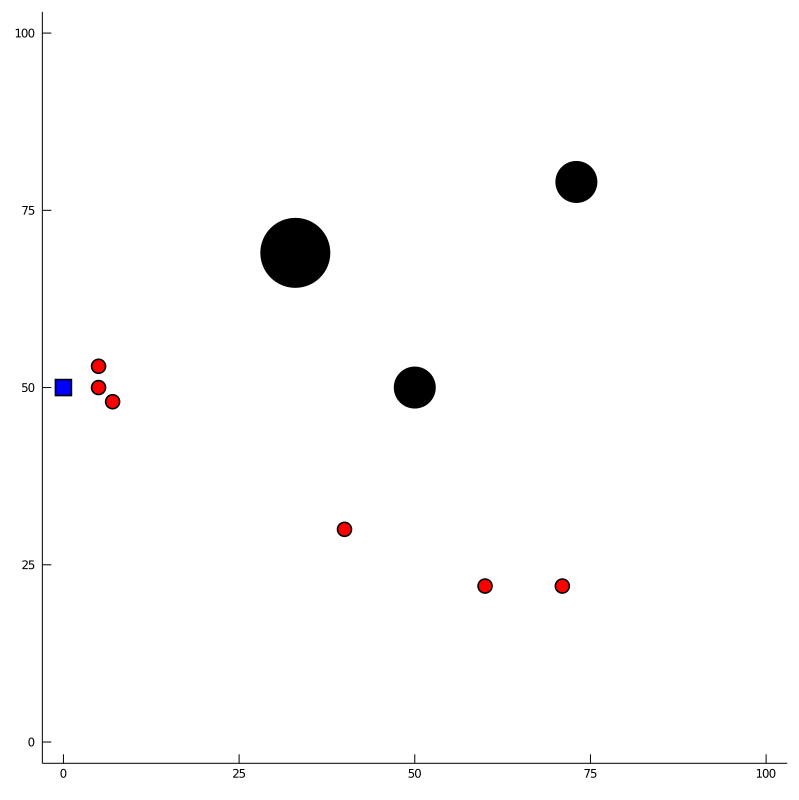

In [205]:
#Define the Environment

g1 = location(0.0,0.0)
g2 = location(0.0,100.0)
g3 = location(100.0,100.0)
g4 = location(100.0,0.0)
cart_goal = location(100.0,50.0)
terminal_cart_state = location(-100.0,-100.0)
all_goals_list = [g1,g2,g3,g4]

h1 = human_state(40.0,30.0,1.0,g3,1.0)
h2 = human_state(60.0,22.0,1.0,g4,2.0)
h3 = human_state(71.0,22.0,1.0,g2,3.0)
h4 = human_state(5.0,53.0,1.0,g1,4.0)
h5 = human_state(7.0,48.0,1.0,g2,5.0)
h6 = human_state(5.0,50.0,1.0,g3,6.0)
human_state_start_list = [h1,h2,h3,h4,h5,h6]

o1 = obstacle_location(50.0,50.0,3.0)
o2 = obstacle_location(33.0,69.0,5.0)
o3 = obstacle_location(73.0,79.0,3.0)
all_obstacle_list = [o1,o2,o3]

initial_human_dis = human_probability_over_goals([0.25, 0.25, 0.25, 0.25])
initial_human_dis_list = Array{human_probability_over_goals,1}()

golfcart = cart_state(0.0,50.0,0.0,1.0,1.0,cart_goal)
initial_cart_lidar_data = Array{human_state,1}()

env = experiment_environment(100.0,100.0,length(human_state_start_list),
    all_goals_list,human_state_start_list,all_obstacle_list,golfcart,initial_cart_lidar_data,Float64[])

In [206]:
# using Debugger

# function foo(n)
#     x = n+1
#     ((BigInt[1 1; 1 0])^x)[2,1]
# end

# @enter foo(20)

In [234]:
#Function for actually moving human in the environment

function get_new_human_position_actual_environemnt(human, world, time_step)

    rand_num = (rand() - 0.5)*0.5
    #@show(rand_num)

    #First Quadrant
    if(human.goal.x >= human.x && human.goal.y >= human.y)
        if(human.goal.x == human.x)
            new_x = human.x
            new_y = human.y + (human.v)*time_step + rand_num
        elseif(human.goal.y == human.y)
            new_x = human.x + (human.v)*time_step + rand_num
            new_y = human.y
        else
            heading_angle = atan((human.goal.y - human.y) / (human.goal.x - human.x))
            new_x = human.x + ((human.v)*time_step + rand_num)*cos(heading_angle)
            new_y = human.y + ((human.v)*time_step + rand_num)*sin(heading_angle)
        end
    #Second Quadrant
    elseif(human.goal.x <= human.x && human.goal.y >= human.y)
        if(human.goal.x == human.x)
            new_x = human.x
            new_y = human.y + (human.v)*time_step + rand_num
        elseif(human.goal.y == human.y)
            new_x = human.x - (human.v)*time_step - rand_num
            new_y = human.y
        else
            heading_angle = atan((human.goal.y - human.y) / (human.goal.x - human.x))
            new_x = human.x - ((human.v)*time_step + rand_num)*cos(heading_angle)
            new_y = human.y - ((human.v)*time_step + rand_num)*sin(heading_angle)
        end
    #Third Quadrant
    elseif(human.goal.x <= human.x && human.goal.y <= human.y)
        if(human.goal.x == human.x)
            new_x = human.x
            new_y = human.y - (human.v)*time_step - rand_num
        elseif(human.goal.y == human.y)
            new_x = human.x - (human.v)*time_step - rand_num
            new_y = human.y
        else
            heading_angle = atan((human.goal.y - human.y) / (human.goal.x - human.x))
            new_x = human.x - ((human.v)*time_step + rand_num)*cos(heading_angle)
            new_y = human.y - ((human.v)*time_step + rand_num)*sin(heading_angle)
        end
    #Fourth Quadrant
    else(human.goal.x >= human.x && human.goal.y <= human.y)
        if(human.goal.x == human.x)
            new_x = human.x
            new_y = human.y - (human.v)*time_step - rand_num
        elseif(human.goal.y == human.y)
            new_x = human.x + (human.v)*time_step + rand_num
            new_y = human.y
        else
            heading_angle = atan((human.goal.y - human.y) / (human.goal.x - human.x))
            new_x = human.x + ((human.v)*time_step + rand_num)*cos(heading_angle)
            new_y = human.y + ((human.v)*time_step + rand_num)*sin(heading_angle)
        end
    end
    
    new_x = clamp(new_x,0,world.length)
    new_y = clamp(new_y,0,world.breadth)
    #@show(new_x,new_y)
    new_human_state = human_state(new_x, new_y, human.v, human.goal,human.id)
    
    return new_human_state
    
end


get_new_human_position_actual_environemnt (generic function with 1 method)

In [238]:
#Functions for tracking belief

function is_within_range(location1, location2, threshold_distance)
    euclidean_distance = ((location1.x - location2.x)^2 + (location1.y - location2.y)^2)^0.5
    if(euclidean_distance<=threshold_distance)
        return true
    else
        return false
    end
end
#@code_warntype is_within_range(location(0,0,-1), location(3,4,-1), 1)


#This function returns the distance of a human's position to all the possible goal locations 
function calculate_human_dist_from_all_goals(human_position,list_of_goals)
    distance_list = Float64[]
    for goal in list_of_goals
        distance = ((human_position.x-goal.x)^2 + (human_position.y-goal.y)^2)^0.5
        push!(distance_list,distance)
    end
    return distance_list
end

function is_human_present_in_the_list(human,old_lidar_data)
    for human_old_data_index in 1:length(old_lidar_data)
        if(human.id == old_lidar_data[human_old_data_index].id)
            return human_old_data_index
        end
    end
    return -1
end


function update_belief(current_belief,all_goals_list, old_cart_lidar_data, new_cart_lidar_data)
    #@show("INSIDE",current_belief, old_cart_lidar_data, new_cart_lidar_data,"*****")
    new_belief = Array{human_probability_over_goals,1}()
    for human_index_in_new_lidar_data in 1:length(new_cart_lidar_data)
        human_index_in_old_lidar_data = is_human_present_in_the_list(new_cart_lidar_data[human_index_in_new_lidar_data],
            old_cart_lidar_data)
        if(human_index_in_old_lidar_data == -1)
            push!(new_belief,human_probability_over_goals([0.25,0.25,0.25,0.25]))
        else
            old_human_dist_from_all_goals_list = calculate_human_dist_from_all_goals(
                old_cart_lidar_data[human_index_in_old_lidar_data],all_goals_list)
            new_human_dist_from_all_goals_list = calculate_human_dist_from_all_goals(
                new_cart_lidar_data[human_index_in_new_lidar_data],all_goals_list)
            human_prob_over_goals_list = old_human_dist_from_all_goals_list .- new_human_dist_from_all_goals_list
            minimum_unnormalized_value = abs(minimum(human_prob_over_goals_list))
            for i in 1:length(human_prob_over_goals_list)
                human_prob_over_goals_list[i] += (minimum_unnormalized_value + 1)
            end
            #human_prob_over_goals_list = broadcast(x-> x+1+abs(minimum(human_prob_over_goals_list)),human_prob_over_goals_list)
            updated_belief_for_current_human = (current_belief[human_index_in_old_lidar_data].distribution).*human_prob_over_goals_list
            updated_belief_for_current_human = updated_belief_for_current_human/sum(updated_belief_for_current_human)
            #@show(updated_belief_for_current_human)
            push!(new_belief,human_probability_over_goals(updated_belief_for_current_human))
        end
    end
    return new_belief
end

# temp_old_lidar_data = [env.humans[1], env.humans[3], env.humans[5]]
# temp_current_belief = [human_probability_over_goals([0.25, 0.25, 0.25, 0.25]),
# human_probability_over_goals([0.25, 0.25, 0.25, 0.25]),
# human_probability_over_goals([0.25, 0.25, 0.25, 0.25])]
# temp_new_lidar_data = [get_new_human_position_actual_environemnt(env.humans[1],env,1),
#     get_new_human_position_actual_environemnt(env.humans[2],env,1),
#     get_new_human_position_actual_environemnt(env.humans[3],env,1),
#     get_new_human_position_actual_environemnt(env.humans[4],env,1),
#     get_new_human_position_actual_environemnt(env.humans[5],env,1)]

# @code_warntype update_belief(temp_current_belief, env.goals,temp_old_lidar_data,temp_new_lidar_data)
#lala = update_belief(temp_current_belief, env.goals,temp_old_lidar_data,temp_new_lidar_data)
#lala = @code_warntype update_belief([], env.goals,[],temp_new_lidar_data)

update_belief (generic function with 1 method)

In [239]:
function wrap_between_0_and_2Pi(theta)
   return mod(theta,2*pi) 
end

function is_goal(node, goal_x, goal_y, threshold)
    euclidean_distance =  ( (node.x - goal_x)^2 + (node.y - goal_y)^2 )^ 0.5
    if(euclidean_distance < threshold)
        return true
    else
        return false
    end
end

function find_max_ele_and_index(some_array, len)
    max_ele::Float64 = -1.0
    index::Int64 = 0
    for i in 1:len
        if(max_ele<some_array[i])
            max_ele = some_array[i]
            index = i
        end
    end
    return (max_ele,index)
end
        

function calculate_heuristic_cost(node_x, node_y, node_theta, goal_x, goal_y, world)
    euclidean_distance =  ( (node_x - goal_x)^2 + (node_y - goal_y)^2 )^ 0.5
    direct_line_to_goal_slope = wrap_between_0_and_2Pi(atan(goal_y-node_y,goal_x-node_x))
    orientation_cost = 10* dot( (cos(direct_line_to_goal_slope), sin(direct_line_to_goal_slope)) , 
                                (cos(node_theta), sin(node_theta)) )    
    return euclidean_distance - orientation_cost
end

function get_path(current_node)
    steering_angle_controls_sequence = [] 
    @show(current_node.actual_cost)
    while(current_node.parent!= nothing)
        push!(steering_angle_controls_sequence, current_node.action_taken_to_reach_here)
        current_node = current_node.parent
    end
    return reverse(steering_angle_controls_sequence)
end     

function get_new_x_y_theta(current_x, current_y, current_theta, steering_angle,time_interval, env, arc_length)
    if(steering_angle == 0.0)
        new_theta = current_theta
        new_x = current_x + arc_length*cos(current_theta)*time_interval
        new_y = current_y + arc_length*sin(current_theta)*time_interval
    else
        new_theta = current_theta + (arc_length * tan(steering_angle) * time_interval / env.cart.L)
        new_theta = wrap_between_0_and_2Pi(new_theta)

        new_x = current_x + ((env.cart.L / tan(steering_angle)) * (sin(new_theta) - sin(current_theta)))
        new_y = current_y + ((env.cart.L / tan(steering_angle)) * (cos(current_theta) - cos(new_theta)))
    end
    return float(new_x), float(new_y), float(new_theta)
end

function get_discrete_state(environment, x, y)
    discretization_width = 0.5
    max_num_bins_x = ceil(environment.length/discretization_width)
    discrete_x = clamp(ceil(x/discretization_width),1,max_num_bins_x)
    max_num_bins_y = ceil(environment.breadth/discretization_width)
    discrete_y = clamp(ceil(y/discretization_width),1,max_num_bins_y)
    return discrete_x::Float64,discrete_y::Float64
end

function get_action_cost(environment, current_belief, final_x::Float64, final_y::Float64, obs_thresold::Float64, hum_threshold::Float64, action::Float64)
    total_cost::Float64 = 0.0

    #Cost from going out of bounds
    if(final_x<=0.0 || final_x>=env.length)
        return Inf
    end
    if(final_y<=0.0 || final_y>=env.breadth)
        return Inf
    end

    padding_radius = 5.0
    lidar_range = 10.0
    
    #Cost from obstacles
    for obstacle in environment.obstacles
        euclidean_distance::Float64 = ( (final_x - obstacle.x)^2 + (final_y - obstacle.y)^2 )^ 0.5
        if(euclidean_distance >= obstacle.r + padding_radius)
            continue
        elseif(euclidean_distance <= obstacle.r)
            total_cost = Inf
        else
            distance_between_cart_and_obstacle = euclidean_distance - obstacle.r
            total_cost += obs_thresold* (padding_radius - distance_between_cart_and_obstacle) 
        end
    end

    #Cost from humans seen by lidar
    for human_index in 1:length(environment.cart_lidar_data)
        #@show(human_index)
        human = environment.cart_lidar_data[human_index]
        euclidean_distance::Float64 = ( (final_x - human.x)^2 + (final_y - human.y)^2 )^ 0.5
        if(euclidean_distance >= lidar_range)
            continue
        elseif(euclidean_distance <= 2)
            total_cost = Inf
        else
            max_ele, max_ele_index = find_max_ele_and_index(current_belief[human_index].distribution, 
                                        length(current_belief[human_index].distribution))
            if(max_ele < 0.5)
                total_cost += hum_threshold * hum_threshold * (1/euclidean_distance) 
            else
                estimated_human_goal = environment.goals[max_ele_index]
                direction_human = (estimated_human_goal.x - human.x , estimated_human_goal.y - human.y)
                #direction_human = direction_human/sum(direction_human)
                direction_cart = (final_x - human.x, final_y - human.y)
                #direction_cart = direction_cart/sum(direction_cart)
                t0 = dot(direction_cart,direction_human)/ dot(direction_human,direction_human) 
                if(t0 <= 0)
                    continue
                else
                    distance_of_cart_from_line = (direction_cart[1] - t0*direction_human[1],
                                                        direction_cart[2] - t0*direction_human[2])
                    distance_of_cart_from_line = sqrt(dot(distance_of_cart_from_line,distance_of_cart_from_line))
                    total_cost += hum_threshold * (1/distance_of_cart_from_line)
                end
            end
        end
    end

    #Cost from no change in steering angle 
    if(action == 0.0)
       total_cost += -0.1 
    end
    
    #Cost from Long Paths
    total_cost += 1

    return total_cost

end

function hybrid_a_star_search(start_x, start_y, start_theta, goal_x, goal_y, env, current_belief)
    
    #Action Set
    set_of_delta_angles = Array{Float64,1}([0.0])
#     for i in 1:3
#         push!(set_of_delta_angles, float(i*5*pi/180))
#         push!(set_of_delta_angles, float(-i*5*pi/180))
#     end
    for i in 1:10
        push!(set_of_delta_angles, float(2*i*pi/180))
        push!(set_of_delta_angles, float(-2*i*pi/180))
    end    
    
    #delta_t = 1 second
    time_step = 1
    #Radius of circle around goal = 1m
    radius_around_goal_threshold = 1.0
    #Obstacle collision threshold
    obstacle_collision_threshold = 10.0
    #Human collision threshold
    human_collision_threshold = 10.0
    #Distance covered in one time interval
    arc_length = 1.0
    #Factor to give less weight to distant points
    lambda = 0.99
        
    path = Array{Float64,1}() 
    open = PriorityQueue{String,Float64}(Base.Order.Forward)
    closed = Dict{String,graph_node}()
    dict_of_nodes = Dict{String,graph_node}()
    start_theta = wrap_between_0_and_2Pi(start_theta)
    start_discrete_x, start_discrete_y  = get_discrete_state(env,start_x,start_y)
    start_discrete_theta = ceil(start_theta*180/pi)
    
    start_node = graph_node(start_x, start_y, start_theta, 0.0, 
        calculate_heuristic_cost(start_x,start_y,start_theta,goal_x,goal_y,env), -100.0,
        start_discrete_x, start_discrete_y, start_discrete_theta, nothing, 0.0)
    
    node_key = "x"*string(start_node.discrete_x)*"y"*string(start_node.discrete_y)*"theta"*string(start_discrete_theta)
    open[node_key] = (lambda^start_node.time_stamp)*start_node.actual_cost + start_node.heuristic_cost
    dict_of_nodes[node_key] = start_node
    start_time = time()
    
    while(length(open) != 0)
        current_node = dict_of_nodes[dequeue!(open)]
        if(is_goal(current_node, goal_x, goal_y, radius_around_goal_threshold))
            path = get_path(current_node)
            return path
        end
        
        node_key = "x"*string(current_node.discrete_x)*"y"*string(current_node.discrete_y)*"theta"*string(current_node.discrete_theta)
        closed[node_key] = current_node
        current_state = [current_node.x,current_node.y,current_node.theta] 
        #@show([current_node.x,current_node.y,current_node.theta,current_node.actual_cost,
        #       current_node.discrete_x,current_node.discrete_y,node_key])
        #@show(current_node.x,current_node.y)
        for delta in set_of_delta_angles
            steering_angle = atan((env.cart.L*delta)/arc_length)
            final_x,final_y,final_theta = get_new_x_y_theta(current_node.x, current_node.y, 
                current_node.theta, steering_angle, time_step, env, arc_length)
            discrete_x, discrete_y = get_discrete_state(env,final_x,final_y)
            discrete_theta = current_node.discrete_theta + round(delta*180/pi)
            node_key = "x"*string(discrete_x)*"y"*string(discrete_y)*"theta"*string(discrete_theta)
            if(haskey(closed,node_key))
                continue
            end
            g = current_node.actual_cost + (lambda^(current_node.time_stamp+1))*get_action_cost(env, current_belief,
                final_x, final_y, obstacle_collision_threshold, human_collision_threshold, steering_angle)
            h = calculate_heuristic_cost(final_x, final_y, final_theta, goal_x, goal_y, env)
            new_node = graph_node(final_x, final_y, final_theta, g, h, 
                steering_angle, discrete_x, discrete_y,discrete_theta, current_node,current_node.time_stamp+1)
            if(new_node.actual_cost == Inf)
                closed[node_key] = new_node
                continue
            end
            if(haskey(open,node_key))
                if(dict_of_nodes[node_key].actual_cost > new_node.actual_cost)
                    dict_of_nodes[node_key] = new_node
                    open[node_key] = new_node.heuristic_cost + new_node.actual_cost
                end
            else
                dict_of_nodes[node_key] = new_node
                open[node_key] = new_node.heuristic_cost + new_node.actual_cost
            end
        end
        if(time()- start_time >= 0.3)
            return path
        end
    end
    return path
end

hybrid_a_star_search (generic function with 1 method)

In [240]:
env.cart_lidar_data = Array{human_state,1}() 
nld = Array{human_state,1}()
for human in env.humans
    if(is_within_range(location(env.cart.x,env.cart.y), location(human.x,human.y), 10))
        push!(nld,human)
    end
end

dummy_starting_belief = update_belief([], env.goals, env.cart_lidar_data, nld)
env.cart_lidar_data = nld
#env.cart_lidar_data
#dummy_starting_belief[2].distribution

3-element Array{human_state,1}:
 human_state(5.0, 53.0, 1.0, location(0.0, 0.0), 4.0)    
 human_state(7.0, 48.0, 1.0, location(0.0, 100.0), 5.0)  
 human_state(5.0, 50.0, 1.0, location(100.0, 100.0), 6.0)

In [243]:
env.cart_hybrid_astar_path = @time hybrid_a_star_search(env.cart.x, env.cart.y, env.cart.theta, env.cart.goal.x, env.cart.goal.y, env, dummy_starting_belief)
#@show(length(env.cart_hybrid_astar_path))
#@time hybrid_a_star_search(0.0, 90.0, pi/6, 100.0, 100.0, env);
length(env.cart_hybrid_astar_path)

current_node.actual_cost = 585.7190747097334
  0.111794 seconds (1.06 M allocations: 51.936 MiB)


113

In [214]:
#Define POMDP Struct

#Function to check terminal state
function isgoalstate_pomdp_planning(s,terminal_state)
    #terminal_cart_state = location(-100,-100,-100)
    if(terminal_state.x == s.cart.x && terminal_state.y == s.cart.y)
        return true
    else
        return false
    end
end

#POMDP struct
mutable struct Speed_Planner_POMDP <: POMDPs.POMDP{SP_POMDP_state,Int,Array{location,1}}
    discount_factor::Float64
    pedestrian_distance_threshold::Float64
    collision_penalty::Float64
    goal_reward_distance_threshold::Float64
    cart_goal_reached_distance_threshold::Float64
    goal_reward::Float64
    max_cart_speed::Float64
    world::experiment_environment
    start_path_index::Int64
end

In [215]:
#Functions for POMDP 


#************************************************************************************************

#Generate Initial POMDP state SparseCat distribution/ Generate the Belief from which POMDP states will be sampled. 

function generate_pomdp_states_and_probability(curr_human_index::Int64,num_humans::Int64,
        initial_human_states::Array{human_state,1},all_human_goal_locations::Array{location,1},
        num_goals::Int64,current_belief::Array{human_probability_over_goals,1},
        current_cart_state::cart_state, start_path_index::Int64,
        all_possible_POMDP_states::Array{SP_POMDP_state,1},
        all_probability_values::Array{Float64,1})::Tuple{Array{SP_POMDP_state,1},Array{Float64,1}}
    
    new_array_all_possible_POMDP_states = Array{SP_POMDP_state,1}()
    new_array_all_probability_values = Array{Float64,1}()
    
    if(length(all_possible_POMDP_states)==0)
        for goal_index in 1:num_goals
            sampled_human_state = human_state(initial_human_states[curr_human_index].x,
            initial_human_states[curr_human_index].y,initial_human_states[curr_human_index].v,
            all_human_goal_locations[goal_index],initial_human_states[curr_human_index].id)
            #sampled_human_state_array = Array{human_state,1}([sampled_human_state])
            generated_state = SP_POMDP_state(current_cart_state,[sampled_human_state],start_path_index)
            push!(new_array_all_possible_POMDP_states,generated_state)
            push!(new_array_all_probability_values,current_belief[curr_human_index].distribution[goal_index])
        end
    else
        for pomdp_state_index in 1:length(all_possible_POMDP_states)
            for goal_index in 1:num_goals
                sampled_human_state = human_state(initial_human_states[curr_human_index].x,
                initial_human_states[curr_human_index].y,initial_human_states[curr_human_index].v,
                all_human_goal_locations[goal_index],initial_human_states[curr_human_index].id)
                generated_state = SP_POMDP_state(current_cart_state,
                    vcat(all_possible_POMDP_states[pomdp_state_index].pedestrians,sampled_human_state),
                    start_path_index)
                push!(new_array_all_possible_POMDP_states,generated_state)
                push!(new_array_all_probability_values,
                    all_probability_values[pomdp_state_index]*(current_belief[curr_human_index].distribution[goal_index]))
            end
        end
    end
    if(curr_human_index == num_humans)
        return (new_array_all_possible_POMDP_states::Array{SP_POMDP_state,1},
                new_array_all_probability_values::Array{Float64,1}) 
    else        
        returned_tuple::Tuple{Array{SP_POMDP_state,1},Array{Float64,1}} = 
        generate_pomdp_states_and_probability(curr_human_index+1,num_humans,initial_human_states,
                all_human_goal_locations,num_goals,current_belief,current_cart_state, start_path_index,
                new_array_all_possible_POMDP_states,
                new_array_all_probability_values)::Tuple{Array{SP_POMDP_state,1},Array{Float64,1}}
        return returned_tuple
    end
end
#@code_warntype generate_pomdp_states_and_probability(1,6,env.humans,env.goals,length(env.goals),current_belief,env.cart,1,SP_POMDP_state[],Float64[])

function initialstate_distribution(m::Speed_Planner_POMDP,current_human_goal_probability)
    initial_cart_state = m.world.cart
    all_human_goal_locations = m.world.goals
    initial_human_states = m.world.cart_lidar_data
    initial_path_start_index = m.start_path_index
    num_goals::Int64 = length(all_human_goal_locations)
    num_humans::Int64 = length(initial_human_states)
    
    all_possible_states = SP_POMDP_state[]
    all_probability_values = Float64[]
    
    if(num_humans == 0)
        generated_state = SP_POMDP_state(initial_cart_state,human_state[],initial_path_start_index)
        push!(all_possible_states,generated_state)
        push!(all_probability_values,1.0)
    else    
        (all_possible_states,all_probability_values) = generate_pomdp_states_and_probability(1,
            num_humans,initial_human_states,all_human_goal_locations,num_goals,
            current_human_goal_probability,initial_cart_state,initial_path_start_index,
            all_possible_states,all_probability_values);
    end
    
    d = SparseCat(all_possible_states, all_probability_values)
    return d
end
#@code_warntype initialstate_distribution(golfcart_pomdp(),initial_human_dis_list)


#************************************************************************************************


#Simulating Human One step forward in POMDP planning

function get_pedestrian_discrete_position_pomdp_planning(new_x,new_y,world)
    discretization_step_length = 2.0
    discrete_x = floor(new_x/discretization_step_length) * discretization_step_length
    discrete_y = floor(new_y/discretization_step_length) * discretization_step_length
    discrete_x = clamp(discrete_x,0,world.length)
    discrete_y = clamp(discrete_y,0,world.breadth)
    return discrete_x, discrete_y
end

function update_human_position_pomdp_planning(human, world, time_step, rng)

    rand_num = (rand(rng) - 0.5)*0.5

    #First Quadrant
    if(human.goal.x >= human.x && human.goal.y >= human.y)
        if(human.goal.x == human.x)
            new_x = human.x
            new_y = human.y + (human.v)*time_step + rand_num
        elseif(human.goal.y == human.y)
            new_x = human.x + (human.v)*time_step + rand_num
            new_y = human.y
        else
            heading_angle = atan((human.goal.y - human.y) / (human.goal.x - human.x))
            new_x = human.x + ((human.v)*time_step + rand_num)*cos(heading_angle)
            new_y = human.y + ((human.v)*time_step + rand_num)*sin(heading_angle)
        end
    #Second Quadrant
    elseif(human.goal.x <= human.x && human.goal.y >= human.y)
        if(human.goal.x == human.x)
            new_x = human.x
            new_y = human.y + (human.v)*time_step + rand_num
        elseif(human.goal.y == human.y)
            new_x = human.x - (human.v)*time_step - rand_num
            new_y = human.y
        else
            heading_angle = atan((human.goal.y - human.y) / (human.goal.x - human.x))
            new_x = human.x - ((human.v)*time_step + rand_num)*cos(heading_angle)
            new_y = human.y - ((human.v)*time_step + rand_num)*sin(heading_angle)
        end
    #Third Quadrant
    elseif(human.goal.x <= human.x && human.goal.y <= human.y)
        if(human.goal.x == human.x)
            new_x = human.x
            new_y = human.y - (human.v)*time_step - rand_num
        elseif(human.goal.y == human.y)
            new_x = human.x - (human.v)*time_step - rand_num
            new_y = human.y
        else
            heading_angle = atan((human.goal.y - human.y) / (human.goal.x - human.x))
            new_x = human.x - ((human.v)*time_step + rand_num)*cos(heading_angle)
            new_y = human.y - ((human.v)*time_step + rand_num)*sin(heading_angle)
        end
    #Fourth Quadrant
    else(human.goal.x >= human.x && human.goal.y <= human.y)
        if(human.goal.x == human.x)
            new_x = human.x
            new_y = human.y - (human.v)*time_step - rand_num
        elseif(human.goal.y == human.y)
            new_x = human.x + (human.v)*time_step + rand_num
            new_y = human.y
        else
            heading_angle = atan((human.goal.y - human.y) / (human.goal.x - human.x))
            new_x = human.x + ((human.v)*time_step + rand_num)*cos(heading_angle)
            new_y = human.y + ((human.v)*time_step + rand_num)*sin(heading_angle)
        end
    end
    
    new_x = clamp(new_x,0,world.length)
    new_y = clamp(new_y,0,world.breadth)
    #@show(new_x,new_y)
    discrete_new_x, discrete_new_y = get_pedestrian_discrete_position_pomdp_planning(new_x,new_y,world)
    #@show(discrete_new_x,discrete_new_y)
    new_human_state = human_state(new_x, new_y, human.v, human.goal,human.id)
    observed_location = location(discrete_new_x, discrete_new_y)
    
    return new_human_state,observed_location
    
end
#@code_warntype update_human_position_pomdp_planning(env.humans[2], env, 1.0, MersenneTwister(1234))


#************************************************************************************************


#Simulating the cart one step forward in POMDP planning according to its new speed

function update_cart_position_pomdp_planning(current_cart_position, new_cart_velocity, starting_index, world)
    arc_length = 1.0
    time_interval = 1.0
    current_x, current_y, current_theta = current_cart_position.x, current_cart_position.y, current_cart_position.theta
    cart_path = Tuple{Float64,Float64,Float64}[]
    length_hybrid_a_star_path = length(world.cart_hybrid_astar_path)
    if(new_cart_velocity == 0.0)
         push!(cart_path,(Float64(current_x), Float64(current_y), Float64(current_theta)))
    else
        for i in (1:new_cart_velocity)
            #@show(starting_index, length(world.cart_hybrid_astar_path))
            steering_angle = world.cart_hybrid_astar_path[starting_index]
            if(steering_angle == 0.0)
                new_theta = current_theta
                new_x = current_x + arc_length*cos(current_theta)*time_interval
                new_y = current_y + arc_length*sin(current_theta)*time_interval
            else
                new_theta = current_theta + (arc_length * tan(steering_angle) * time_interval / world.cart.L)
                new_theta = wrap_between_0_and_2Pi(new_theta)
                new_x = current_x + ((world.cart.L / tan(steering_angle)) * (sin(new_theta) - sin(current_theta)))
                new_y = current_y + ((world.cart.L / tan(steering_angle)) * (cos(current_theta) - cos(new_theta)))
            end
            new_x = clamp(new_x,0,world.length)
            new_y = clamp(new_y,0,world.breadth)
            push!(cart_path,(Float64(new_x), Float64(new_y), Float64(new_theta)))
            current_x, current_y,current_theta = new_x,new_y,new_theta
            starting_index = starting_index + 1
            if(starting_index>length_hybrid_a_star_path)
                break
            end
        end
    end
    return cart_path
end
# @code_warntype update_cart_position_pomdp_planning(env.cart, 0.0, 1, env)
# update_cart_position_pomdp_planning(env.cart, 0, 1, env)


#************************************************************************************************


# Reward functions for the POMDP model 

# Collision Penalty
function collision_penalty_pomdp_planning(collision_flag, penalty)
    if(collision_flag)
        #@show(penalty)
        return penalty
    else
        return 0.0
    end
end

# Goal Reward
function goal_reward_pomdp_planning(s, distance_threshold, goal_reached_flag, goal_reward)
    total_reward = 0.0
    if(goal_reached_flag)
        total_reward = goal_reward
    else
        euclidean_distance = ((s.cart.x - s.cart.goal.x)^2 + (s.cart.y - s.cart.goal.y)^2)^0.5
        if(euclidean_distance<distance_threshold && euclidean_distance!=0.0)
            total_reward = goal_reward/euclidean_distance
        end
    end
    #@show(total_reward)
    return total_reward
end

# Low Speed Penalty
function speed_reward_pomdp_planning(s, max_speed)
    t = (s.cart.v - max_speed)/max_speed
    return t
end

# Penalty for excessive acceleration and deceleration 
function unsmooth_motion_penalty_pomdp_planning(s,a,sp)
    if(sp.cart.x==-100.0 && sp.cart.y==-100.0)
        return 0.0
    elseif(a==1.0 || a==-1.0)
        return -1.0
    else
        return 0.0
    end
end


#************************************************************************************************


#POMDP Generative Model

function POMDPs.gen(m::Speed_Planner_POMDP, s, a, rng)
    
    #Threshold to check if the cart has reached near the goal
    #cart_goal_reached_distance_threshold = 0.5
    cart_reached_goal_flag = false
    #Threshold to check if the cart is near a pedestrian
    #pedestrian_distance_threshold = 1.0
    collision_with_pedestrian_flag = false
    #Length of one time step
    one_time_step = 1.0

    new_human_states = human_state[]
    observed_positions = location[]
    if(is_within_range(location(s.cart.x,s.cart.y), s.cart.goal, m.cart_goal_reached_distance_threshold))
        new_cart_position = (-100.0, -100.0, -100.0)
        #@show("Goal reached",s)
        cart_reached_goal_flag = true
        new_cart_velocity = clamp(s.cart.v + a, 0.0, m.max_cart_speed)
    elseif(s.current_path_covered_index>length(m.world.cart_hybrid_astar_path))
        new_cart_position = (-100.0, -100.0, -100.0)
        cart_reached_goal_flag = true
        new_cart_velocity = clamp(s.cart.v + a, 0.0, m.max_cart_speed)
    else
        new_cart_velocity =clamp(s.cart.v + a, 0.0, m.max_cart_speed)
        cart_path::Vector{Tuple{Float64,Float64,Float64}} = update_cart_position_pomdp_planning(s.cart, new_cart_velocity, s.current_path_covered_index, m.world)
        new_cart_position = cart_path[end]
        for positions in cart_path
            for human in s.pedestrians
                if(is_within_range(location(s.cart.x,s.cart.y),location(human.x,human.y),m.pedestrian_distance_threshold))
                    #@show("Collision happened",s)
                    new_cart_position = (-100.0, -100.0, -100.0)
                    collision_with_pedestrian_flag = true
                    break
                end
            end
        end
    end                
    cart_new_state = cart_state(new_cart_position[1], new_cart_position[2], new_cart_position[3], new_cart_velocity, s.cart.L, s.cart.goal)

    # Simulate all the pedestrians
    for human in s.pedestrians
        modified_human_state,observed_location = update_human_position_pomdp_planning(human, m.world, one_time_step, rng)
        push!(new_human_states, modified_human_state)
        push!(observed_positions, observed_location)
    end

    # Generate starting index in Hybrid A* path for the next POMPD state
    new_path_index = s.current_path_covered_index + new_cart_velocity
    #@show(s.current_path_covered_index,new_cart_velocity,new_path_index)
    #@show(cart_reached_goal_flag,collision_with_pedestrian_flag)
    
    # Next POMDP State
    sp = SP_POMDP_state(cart_new_state, new_human_states, new_path_index)
    # Generated Observation
    o = observed_positions
    # R(s,a): Reward for being at state s and taking action a   
    r = collision_penalty_pomdp_planning(collision_with_pedestrian_flag, m.collision_penalty) 
        + goal_reward_pomdp_planning(s, m.goal_reward_distance_threshold, cart_reached_goal_flag, m.goal_reward) 
        + speed_reward_pomdp_planning(s, m.max_cart_speed) 
        + unsmooth_motion_penalty_pomdp_planning(s,a,sp)
    #Small Penalty for longer duration paths
    r = r - 1
    return (sp=sp, o=o, r=r)
end
#@code_warntype POMDPs.gen(golfcart_pomdp(), SP_POMDP_state(env.cart,env.humans,1), 1, MersenneTwister(1234))

    
#************************************************************************************************

    
#Upper bound value function for DESPOT

function is_collision_state_pomdp_planning(s,m)
    for human in s.pedestrians
        if(is_within_range(location(s.cart.x,s.cart.y),location(human.x,human.y),m.pedestrian_distance_threshold))
            return true
        end
    end
    return false
end

function time_to_goal_pomdp_planning(s,m)
    curr_vel = m.max_cart_speed
    remaining_path_length = length(m.world.cart_hybrid_astar_path) - s.current_path_covered_index
    time_needed_at_curr_vel = floor(remaining_path_length/curr_vel)
    return time_needed_at_curr_vel
end

function calculate_upper_bound_value_pomdp_planning(m, b)
    value_sum = 0.0
    for (s, w) in weighted_particles(b)
        if(is_within_range(location(s.cart.x,s.cart.y), s.cart.goal, m.cart_goal_reached_distance_threshold))
            value_sum += w*m.goal_reward
        elseif (is_collision_state_pomdp_planning(s,m))
            value_sum += w*m.collision_penalty
        else
            value_sum += w*((discount(m)^time_to_goal_pomdp_planning(s,m))*m.goal_reward)
        end
    end
    return value_sum
end
#@code_warntype calculate_upper_bound_value(golfcart_pomdp(), initialstate_distribution(golfcart_pomdp()))

calculate_upper_bound_value_pomdp_planning (generic function with 1 method)

In [216]:
# function lala(b)
#     return 1
# end

In [3]:
# b->1
# function (b)
#     return 1
# end


# f(b) = 1

# function f(b)
#     return 1
# end

In [217]:
golfcart_pomdp() = Speed_Planner_POMDP(0.9,4.0,-100.0,5.0,1.0,100.0,7.0,env,1)
discount(p::Speed_Planner_POMDP) = p.discount_factor 
isterminal(::Speed_Planner_POMDP, s::SP_POMDP_state) = isgoalstate_pomdp_planning(s,terminal_cart_state);

#Action Space for the POMDP
actions(::Speed_Planner_POMDP) = [-1.0, 0.0, 1.0] # Decelerate Maintain Accelerate

solver = DESPOTSolver(bounds=IndependentBounds(DefaultPolicyLB(FunctionPolicy(b->1)),
        calculate_upper_bound_value_pomdp_planning, check_terminal=true),K=100,D=50,T_max=0.33, tree_in_info=true)
planner = POMDPs.solve(solver, golfcart_pomdp());

m = golfcart_pomdp()
#a, info = action_info(planner, b);
#a = action(planner, b)
#@time action_info(planner, b)

In [71]:
#env.cart_hybrid_astar_path
#current_belief
#initialstate_distribution(m,dummy_starting_belief)

In [24]:
# m = golfcart_pomdp()

for i in 1:100
    b = initialstate_distribution(m,dummy_starting_belief)
    #@show(length(b.vals))
    a,info = action_info(planner, b);
    if(a>0)
        @show("WOW", a)
    end
end
# a
# info[:tree]

In [218]:
function wrap_between_0_and_2Pi(theta)
   return mod(theta,2*pi) 
end

function travel!(du,u,p,t)
    x,y,theta = u
    v,L,alpha = p 
    
    du[1] = v*cos(theta)
    du[2] = v*sin(theta)
    du[3] = (v/L)*tan(alpha)
end

function get_intermediate_points(initial_state, time_interval, extra_parameters)
    prob = ODEProblem(travel!,initial_state,time_interval,extra_parameters)
    sol = DifferentialEquations.solve(prob,saveat=0.1)
    x = []
    y = []
    theta = []
    
    for i in 1:length(sol.u)
        push!(x,sol.u[i][1])
        push!(y,sol.u[i][2])
        push!(theta,wrap_between_0_and_2Pi(sol.u[i][3]))
    end
    
    return x,y,theta
end

get_intermediate_points (generic function with 1 method)

In [219]:
debug_golf_cart_upper_bound

debug_golf_cart_upper_bound (generic function with 1 method)

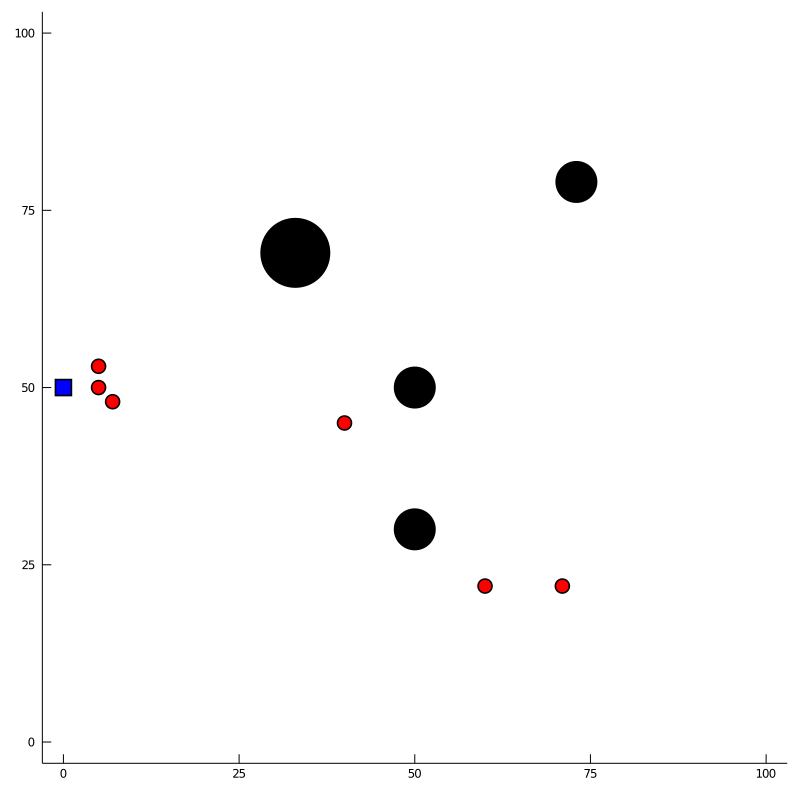

In [220]:
#Define the Environment

g1 = location(0.0,0.0)
g2 = location(0.0,100.0)
g3 = location(100.0,100.0)
g4 = location(100.0,0.0)
cart_goal = location(100.0,50.0)
terminal_cart_state = location(-100.0,-100.0)
all_goals_list = [g1,g2,g3,g4]

h1 = human_state(40.0,45.0,1.0,g3,1.0)
h2 = human_state(60.0,22.0,1.0,g4,2.0)
h3 = human_state(71.0,22.0,1.0,g2,3.0)
h4 = human_state(5.0,53.0,1.0,g1,4.0)
h5 = human_state(7.0,48.0,1.0,g2,5.0)
h6 = human_state(5.0,50.0,1.0,g3,6.0)
human_state_start_list = [h1,h2,h3,h4,h5,h6]

o1 = obstacle_location(50.0,50.0,3.0)
o2 = obstacle_location(33.0,69.0,5.0)
o3 = obstacle_location(73.0,79.0,3.0)
o4 = obstacle_location(50.0,30.0,3.0)
all_obstacle_list = [o1,o2,o3,o4]

initial_human_dis = human_probability_over_goals([0.25, 0.25, 0.25, 0.25])
initial_human_dis_list = Array{human_probability_over_goals,1}()

golfcart = cart_state(0.0,50.0,0.0,0.0,1.0,cart_goal)
initial_cart_lidar_data = Array{human_state,1}()

env = experiment_environment(100.0,100.0,length(human_state_start_list),
    all_goals_list,human_state_start_list,all_obstacle_list,golfcart,initial_cart_lidar_data,Float64[])

In [4]:
Base.copy(s::cart_state) = cart_state(s.x, s.y,s.theta,s.v,s.L,s.goal)
global i = 1
cart_throughout_path = []
one_time_step = 0.5
env_copy = deepcopy(env)
all_observed_environments = []
lidar_range = 30

#Create new POMDP for env_copy
golfcart_pomdp_copy() = Speed_Planner_POMDP(0.9,2.0,-100.0,1.0,1.0,100.0,7.0,env_copy,1)
discount(p::Speed_Planner_POMDP) = p.discount_factor 
isterminal(::Speed_Planner_POMDP, s::SP_POMDP_state) = isgoalstate_pomdp_planning(s,terminal_cart_state);
actions(::Speed_Planner_POMDP) = [-1.0, 0.0, 1.0]

solver = DESPOTSolver(bounds=IndependentBounds(DefaultPolicyLB(FunctionPolicy(b->1)),
        calculate_upper_bound_value_pomdp_planning, check_terminal=true),K=100,D=50,T_max=0.5, tree_in_info=true)
planner = POMDPs.solve(solver, golfcart_pomdp_copy());
m = golfcart_pomdp_copy()

#Sense humans near cart before moving
initial_cart_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
        push!(initial_cart_lidar_data,human)
    end
end
env_copy.cart_lidar_data = initial_cart_lidar_data

#Generate Initial Belief for humans near cart
initial_belief = update_belief([],env_copy.goals,[],env_copy.cart_lidar_data)

#Propogate humans for one time step
moved_human_positions = Array{human_state,1}()
for human in env_copy.humans
    push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
end
env_copy.humans = moved_human_positions

#Sense humans near cart after the first time step
new_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
        push!(new_lidar_data,human)
    end
end
    
global current_belief = update_belief(initial_belief, env_copy.goals, 
    env_copy.cart_lidar_data, new_lidar_data)
env_copy.cart_lidar_data = new_lidar_data

#Propogate humans for one more time step
moved_human_positions = Array{human_state,1}()
for human in env_copy.humans
    push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
end
env_copy.humans = moved_human_positions

#Sense humans near cart after the first time step
new_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
        push!(new_lidar_data,human)
    end
end
    
global current_belief = update_belief(current_belief, env_copy.goals, 
    env_copy.cart_lidar_data, new_lidar_data)
env_copy.cart_lidar_data = new_lidar_data

# @show(env_copy.cart_lidar_data)
# @show(current_belief)
#break

anim = @animate for j ∈ 1:10000
    @show("start")
    if(!is_within_range(location(env_copy.cart.x,env_copy.cart.y), env_copy.cart.goal, 1.0))
        env_copy.cart_hybrid_astar_path = hybrid_a_star_search(env_copy.cart.x, env_copy.cart.y, 
            env_copy.cart.theta, env_copy.cart.goal.x, env_copy.cart.goal.y, env_copy, current_belief);

        push!(all_observed_environments, (deepcopy(env_copy),current_belief))
        
        m = golfcart_pomdp_copy()
        b = initialstate_distribution(m,current_belief)
        a = action(planner, b)
        println("Action chosen " , a)
        env_copy.cart.v = clamp(env_copy.cart.v + a,0,m.max_cart_speed)
        if(length(env_copy.cart_hybrid_astar_path) == 0)
            @show("Some error")
            #break
            env_copy.cart.v = 0.0
        end
        if(env_copy.cart.v != 0.0)
            initial_state = [env_copy.cart.x,env_copy.cart.y,env_copy.cart.theta]
            for i in 1:Int64(env_copy.cart.v)
                if(i>length(env_copy.cart_hybrid_astar_path))
                    break
                end
                steering_angle = env_copy.cart_hybrid_astar_path[i]
                extra_parameters = [env_copy.cart.v, env_copy.cart.L, steering_angle]
                x,y,theta = get_intermediate_points(initial_state, 1.0/env_copy.cart.v, extra_parameters);
                env_copy.cart.x, env_copy.cart.y, env_copy.cart.theta = last(x), last(y), last(theta)
                initial_state = [env_copy.cart.x,env_copy.cart.y,env_copy.cart.theta]
            end
        else
            @show("LALA")
        end
        moved_human_positions = Array{human_state,1}()
        for human in env_copy.humans
            push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
        end
        env_copy.humans = moved_human_positions

        new_lidar_data = Array{human_state,1}()
        for human in env_copy.humans
            if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
                push!(new_lidar_data,human)
            end
        end
        
        global current_belief = update_belief(current_belief, env_copy.goals, 
            env_copy.cart_lidar_data, new_lidar_data)
        env_copy.cart_lidar_data = new_lidar_data
        
        #Propogate humans for one more time step
        moved_human_positions = Array{human_state,1}()
        for human in env_copy.humans
            push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
        end
        env_copy.humans = moved_human_positions

        #Sense humans near cart after the first time step
        new_lidar_data = Array{human_state,1}()
        for human in env_copy.humans
            if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
                push!(new_lidar_data,human)
            end
        end

        global current_belief = update_belief(current_belief, env_copy.goals, 
            env_copy.cart_lidar_data, new_lidar_data)
        env_copy.cart_lidar_data = new_lidar_data

        display(env_copy);
        push!(cart_throughout_path,(a,copy(env_copy.cart)))
#         push!(all_observed_environments, (deepcopy(env_copy),current_belief))
        @show(j)
    else
        @show("Goal reached")
        break
    end
end

gif(anim, "og_pipeline_new.gif", fps = 2)

UndefVarError: UndefVarError: cart_state not defined

In [247]:
#Debugging Upper bound for DESPOT

function is_collision_state_pomdp_planning_debugging(s,m)
    for human in s.pedestrians
        if(is_within_range(location(s.cart.x,s.cart.y),location(human.x,human.y),m.pedestrian_distance_threshold))
            @show(human)
            return true
        end
    end
    return false
end

function time_to_goal_pomdp_planning_debugging(s,m)
    curr_vel = m.max_cart_speed
    remaining_path_length = length(m.world.cart_hybrid_astar_path) - s.current_path_covered_index
    time_needed_at_curr_vel = floor(remaining_path_length/curr_vel)
    return time_needed_at_curr_vel
end

function debug_golf_cart_upper_bound(m,b)
    
    #println(propertynames(b))
    #@show(b.depth)
    
    lower = lbound(DefaultPolicyLB(FunctionPolicy(b->1), max_depth=100),m , b)
    
    value_sum = 0.0
    for (s, w) in weighted_particles(b)
        if(is_within_range(location(s.cart.x,s.cart.y), s.cart.goal, m.cart_goal_reached_distance_threshold))
            value_sum += w*m.goal_reward
        elseif (is_collision_state_pomdp_planning(s,m))
            value_sum += w*m.collision_penalty
        else
            value_sum += w*((discount(m)^time_to_goal_pomdp_planning(s,m))*m.goal_reward)
        end
    end
#     @show("*********************************************************************")
#     @show(value_sum)
    u = (value_sum)/weight_sum(b)
    if lower > u
        push!(bad, (lower,u,b))
        @show("IN DEBUG",lower,u)
    end
    return u
end

bad = []
which_env = 16
# pomdp_ub_debugging_env = deepcopy(all_observed_environments[which_env][1])
# current_belief_debugging = all_observed_environments[which_env][2]

golfcart_pomdp_debug() = Speed_Planner_POMDP(0.9,2.0,-1000.0,1.0,1.0,100.0,7.0,pomdp_ub_debugging_env,1)
discount(p::Speed_Planner_POMDP) = p.discount_factor 
isterminal(::Speed_Planner_POMDP, s::SP_POMDP_state) = isgoalstate_pomdp_planning(s,terminal_cart_state);
actions(::Speed_Planner_POMDP) = [-1.0, 0.0, 1.0]

solver = DESPOTSolver(bounds=IndependentBounds(DefaultPolicyLB(FunctionPolicy(b->1)),
        debug_golf_cart_upper_bound, check_terminal=true),K=100,D=50,T_max=0.5, tree_in_info=true)
planner = POMDPs.solve(solver, golfcart_pomdp_debug());
m_ub_debugging = golfcart_pomdp_debug()
b_ub_debugging = initialstate_distribution(m_ub_debugging,current_belief_debugging)
a, info = action_info(planner, b_ub_debugging)



┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ|

┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @

"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = 

┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ|

┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @


"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -10

┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-629.6296296296296)   |ϕ| = 3
└ @

┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (

┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ|

-1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -629.6296296296296
"IN DEBUG" =

┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (

┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (

-1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -1000.0
"IN

┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (

┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ|

┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ| = 3
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-259.25925925925924)   |ϕ|


"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"
lower = -1.0
u = -259.25925925925924
"IN DEBUG" = "IN DEBUG"

┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (-1.0) > U_0 (-1000.0)   |ϕ| = 1
└ @ ARDESPOT /home/himanshu/.julia/packages/ARDESPOT/GpKMg/src/bounds.jl:8
┌ Warning: L_0 (

(0, Dict{Symbol,Any}(:tree => ARDESPOT.DESPOT{SP_POMDP_state,Int64,Array{location,1}}(Array{Pair{Int64,SP_POMDP_state},1}[[1 => SP_POMDP_state(cart_state(44.723118930554286, 43.492694712571016, 5.8992128717408345, 7.0, 1.0, location(100.0, 50.0)), human_state[human_state(51.34737555672255, 55.401760926995664, 1.0, location(100.0, 100.0), 1.0), human_state(59.66845303140834, 34.448741740142964, 1.0, location(0.0, 100.0), 3.0), human_state(18.61054012445789, 57.16344217076731, 1.0, location(100.0, 0.0), 6.0)], 1), 2 => SP_POMDP_state(cart_state(44.723118930554286, 43.492694712571016, 5.8992128717408345, 7.0, 1.0, location(100.0, 50.0)), human_state[human_state(51.34737555672255, 55.401760926995664, 1.0, location(100.0, 0.0), 1.0), human_state(59.66845303140834, 34.448741740142964, 1.0, location(0.0, 100.0), 3.0), human_state(18.61054012445789, 57.16344217076731, 1.0, location(100.0, 100.0), 6.0)], 1), 3 => SP_POMDP_state(cart_state(44.723118930554286, 43.492694712571016, 5.89921287174083

In [252]:
# info[:tree].l
pomdp_ub_debugging_env.cart_lidar_data

3-element Array{human_state,1}:
 human_state(51.34737555672255, 55.401760926995664, 1.0, location(100.0, 100.0), 1.0)
 human_state(59.66845303140834, 34.448741740142964, 1.0, location(0.0, 100.0), 3.0)  
 human_state(18.61054012445789, 57.16344217076731, 1.0, location(100.0, 100.0), 6.0) 

In [255]:
println(pomdp_ub_debugging_env.humans)
println(pomdp_ub_debugging_env.goals)

human_state[human_state(51.34737555672255, 55.401760926995664, 1.0, location(100.0, 100.0), 1.0), human_state(73.58907931389027, 14.526006377360337, 1.0, location(100.0, 0.0), 2.0), human_state(59.66845303140834, 34.448741740142964, 1.0, location(0.0, 100.0), 3.0), human_state(3.4865437389158798, 36.95736363250833, 1.0, location(0.0, 0.0), 4.0), human_state(4.824873608574869, 64.15808176487239, 1.0, location(0.0, 100.0), 5.0), human_state(18.61054012445789, 57.16344217076731, 1.0, location(100.0, 100.0), 6.0)]
location[location(0.0, 0.0), location(0.0, 100.0), location(100.0, 100.0), location(100.0, 0.0)]


In [251]:
#fieldnames(typeof(bad[10][3]))
pomdp_ub_debugging_env.cart_lidar_data
current_belief_debugging

3-element Array{human_probability_over_goals,1}:
 human_probability_over_goals([0.005295129427505493, 0.08350479194364982, 0.8071390451389894, 0.10406103348985533])    
 human_probability_over_goals([0.24057964141291807, 0.43902345507460006, 0.2537315268431532, 0.06666537666932866])     
 human_probability_over_goals([1.0718965206502831e-8, 0.0006903564447698633, 0.9870447438118521, 0.012264889024412815])

In [229]:
@show(bad[10][1], bad[10][2], bad[10][3].depth)
value_sum = 0.0

for (s,w) in weighted_particles(bad[10][3])
    @show(s)
    #@show(s.cart)
    if(is_within_range(location(s.cart.x,s.cart.y), s.cart.goal, m_ub_debugging.cart_goal_reached_distance_threshold))
        @show("A")
        value_sum += w*m_ub_debugging.goal_reward
    elseif (is_collision_state_pomdp_planning_debugging(s,m))
        @show("B")
        value_sum += w*m_ub_debugging.collision_penalty
    else
        @show("C")
        value_sum += w*((discount(m)^time_to_goal_pomdp_planning_debugging(s,m_ub_debugging))*m_ub_debugging.goal_reward)
    end
    @show(POMDPs.gen(m::Speed_Planner_POMDP, s, a, MersenneTwister(1234)))
end

#lbound(DefaultPolicyLB(FunctionPolicy(b->1), max_depth=100),m_ub_debugging , b_ub_debugging)

(bad[10])[1] = -1.0
(bad[10])[2] = -1000.0
((bad[10])[3]).depth = 8
s = SP_POMDP_state(cart_state(52.33402912425319, 41.03475895742852, 5.959052731809212, 7.0, 1.0, location(100.0, 50.0)), human_state[human_state(56.81612831734953, 60.41478429090372, 1.0, location(100.0, 100.0), 1.0), human_state(54.19188214237235, 40.46525623795714, 1.0, location(0.0, 100.0), 3.0), human_state(25.962917038410648, 61.03311423074245, 1.0, location(100.0, 100.0), 6.0)], 57)
human = human_state(54.19188214237235, 40.46525623795714, 1.0, location(0.0, 100.0), 3.0)
"B" = "B"
POMDPs.gen(m::Speed_Planner_POMDP, s, a, MersenneTwister(1234)) = (sp = SP_POMDP_state(cart_state(-100.0, -100.0, -100.0, 7.0, 1.0, location(100.0, 50.0)), human_state[human_state(57.58676570830401, 61.12120189927865, 1.0, location(100.0, 100.0), 1.0), human_state(53.42894109815309, 41.30341682174731, 1.0, location(0.0, 100.0), 3.0), human_state(26.877142609227544, 61.514285583803975, 1.0, location(100.0, 100.0), 6.0)], 64), o = locatio

In [233]:
?pomdp_ub_debugging_env

search: pomdp_ub_debugging_env



No documentation found.

`pomdp_ub_debugging_env` is of type `experiment_environment`.

# Summary

```
mutable struct experiment_environment <: Any
```

# Fields

```
length                 :: Float64
breadth                :: Float64
num_humans             :: Int64
goals                  :: Array{location,1}
humans                 :: Array{human_state,1}
obstacles              :: Array{obstacle_location,1}
cart                   :: cart_state
cart_lidar_data        :: Array{human_state,1}
cart_hybrid_astar_path :: Array{Float64,1}
```


pomdp_ub_debugging_env = experiment_environment(100.0, 100.0, 6, location[location(0.0, 0.0), location(0.0, 100.0), location(100.0, 100.0), location(100.0, 0.0)], human_state[human_state(51.34737555672255, 55.401760926995664, 1.0, location(100.0, 100.0), 1.0), human_state(73.58907931389027, 14.526006377360337, 1.0, location(100.0, 0.0), 2.0), human_state(59.66845303140834, 34.448741740142964, 1.0, location(0.0, 100.0), 3.0), human_state(3.4865437389158798, 36.95736363250833, 1.0, location(0.0, 0.0), 4.0), human_state(4.824873608574869, 64.15808176487239, 1.0, location(0.0, 100.0), 5.0), human_state(18.61054012445789, 57.16344217076731, 1.0, location(100.0, 100.0), 6.0)], obstacle_location[obstacle_location(50.0, 50.0, 3.0), obstacle_location(33.0, 69.0, 5.0), obstacle_location(73.0, 79.0, 3.0), obstacle_location(50.0, 30.0, 3.0)], cart_state(44.723118930554286, 43.492694712571016, 5.8992128717408345, 7.0, 1.0, location(100.0, 50.0)), human_state[human_state(51.34737555672255, 55.401760

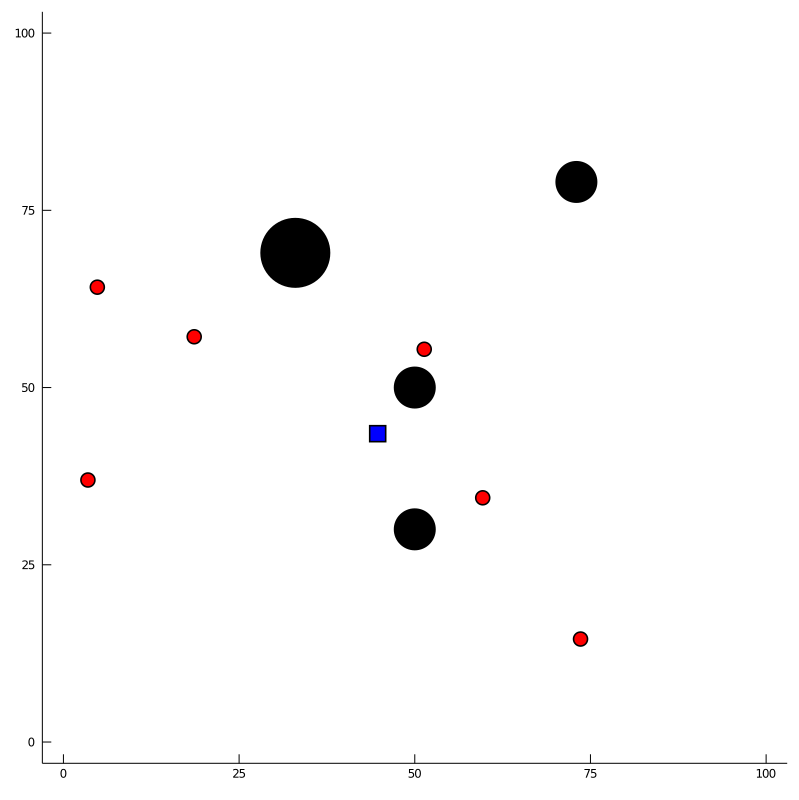

In [232]:
@show(pomdp_ub_debugging_env)

In [178]:
pomdp_ub_debugging_env.cart_lidar_data

3-element Array{human_state,1}:
 human_state(51.34737555672255, 55.401760926995664, 1.0, location(100.0, 100.0), 1.0)
 human_state(59.66845303140834, 34.448741740142964, 1.0, location(0.0, 100.0), 3.0)  
 human_state(18.61054012445789, 57.16344217076731, 1.0, location(100.0, 100.0), 6.0) 

In [135]:
c = (52.33402912425319, 41.03475895742852)
d = (53.77070239879013, 40.92796074499114)

sqrt( (c[1]-d[1])^2 + (c[2]-d[2])^2 )

1.4406373436602646

In [165]:
for i in cart_throughout_path
    println(i)
end

(0, cart_state(0.0, 50.0, 0.0, 0.0, 1.0, location(100.0, 50.0)))
(0, cart_state(0.0, 50.0, 0.0, 0.0, 1.0, location(100.0, 50.0)))
(1, cart_state(0.9798155360548726, 50.172767914926844, 0.3490658503988659, 1.0, 1.0, location(100.0, 50.0)))
(1, cart_state(2.4809800318753608, 51.43239448309178, 1.0471975511965976, 2.0, 1.0, location(100.0, 50.0)))
(-1, cart_state(2.821266399934584, 52.36732358373484, 1.3962634015954636, 1.0, 1.0, location(100.0, 50.0)))
(0, cart_state(2.8212664036414914, 53.36225435302653, 1.7453292519943295, 1.0, 1.0, location(100.0, 50.0)))
(0, cart_state(2.4809800426507924, 54.29718345637606, 2.0943951023931953, 1.0, 1.0, location(100.0, 50.0)))
(0, cart_state(1.841450874504606, 55.059344645867824, 2.443460952792061, 1.0, 1.0, location(100.0, 50.0)))
(1, cart_state(0.4358772583496786, 56.46429344138284, 2.0943951023931953, 2.0, 1.0, location(100.0, 50.0)))
(0, cart_state(0.008545727783522833, 58.39415331272399, 1.5707963267948963, 2.0, 1.0, location(100.0, 50.0)))
(-1,

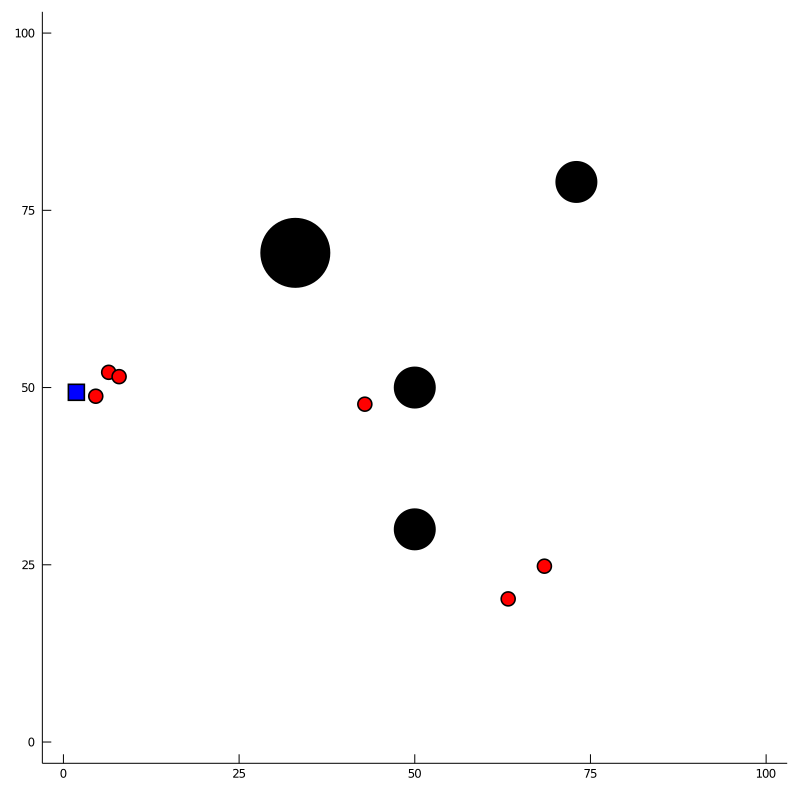

In [90]:
all_observed_environments[4][1]

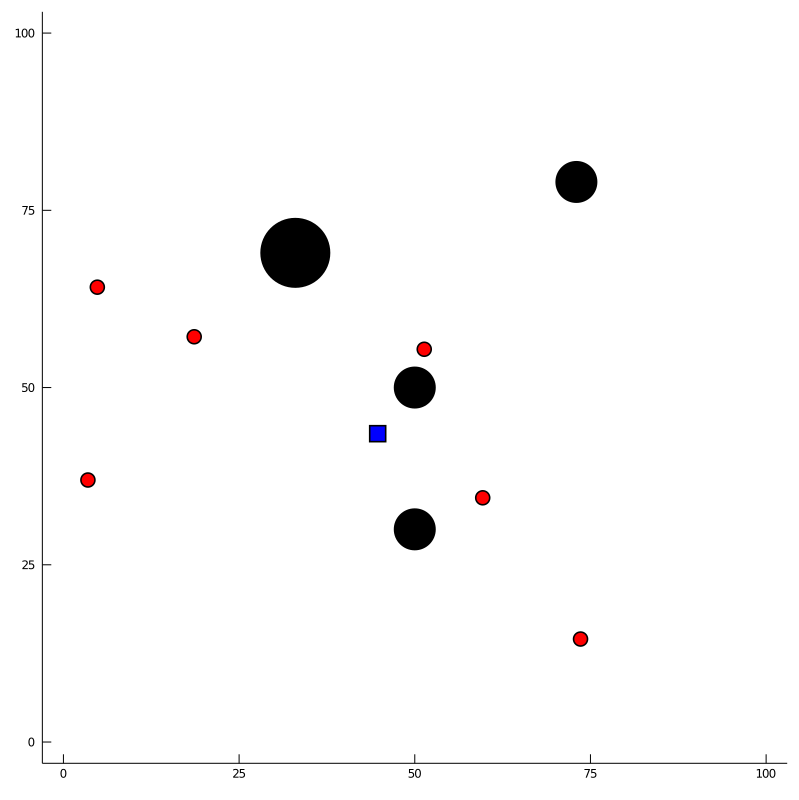

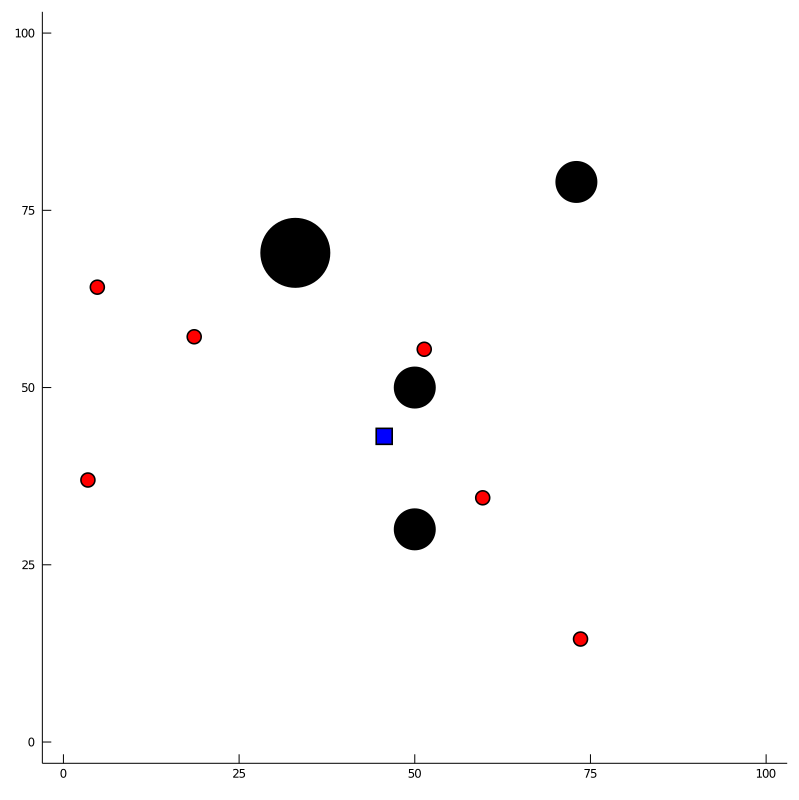

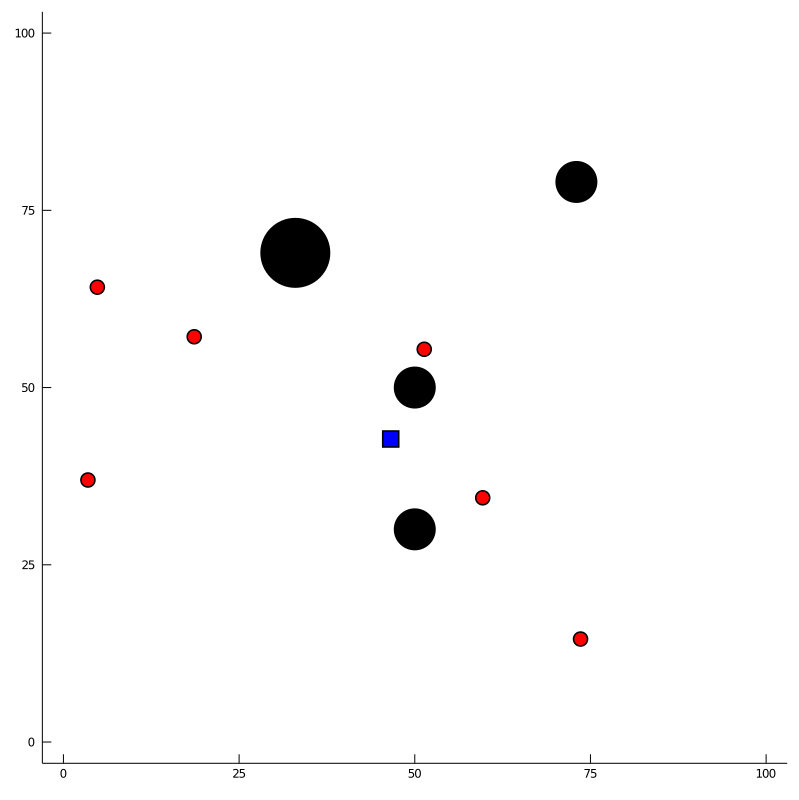

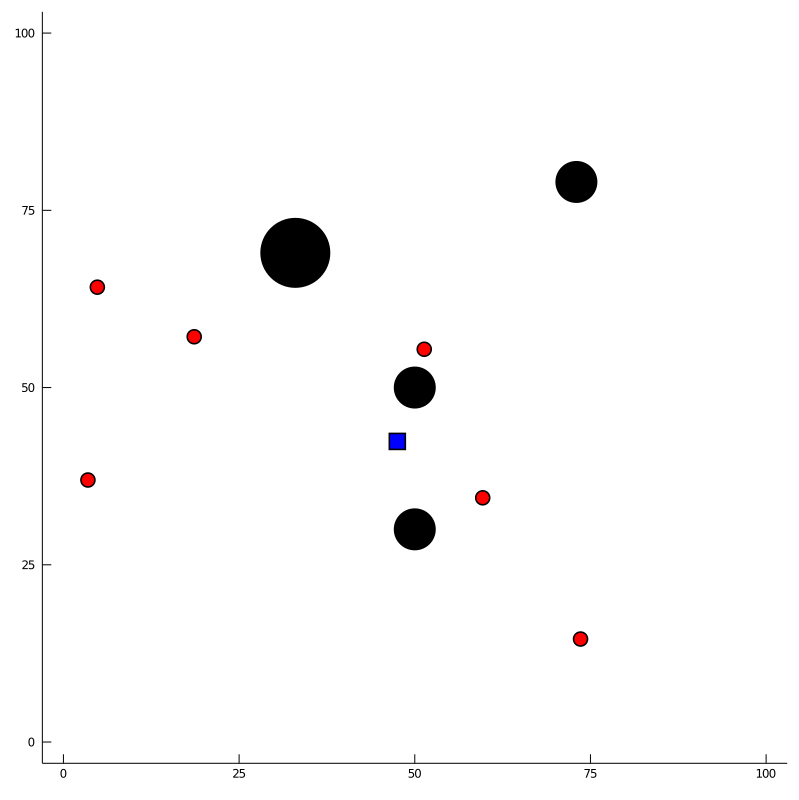

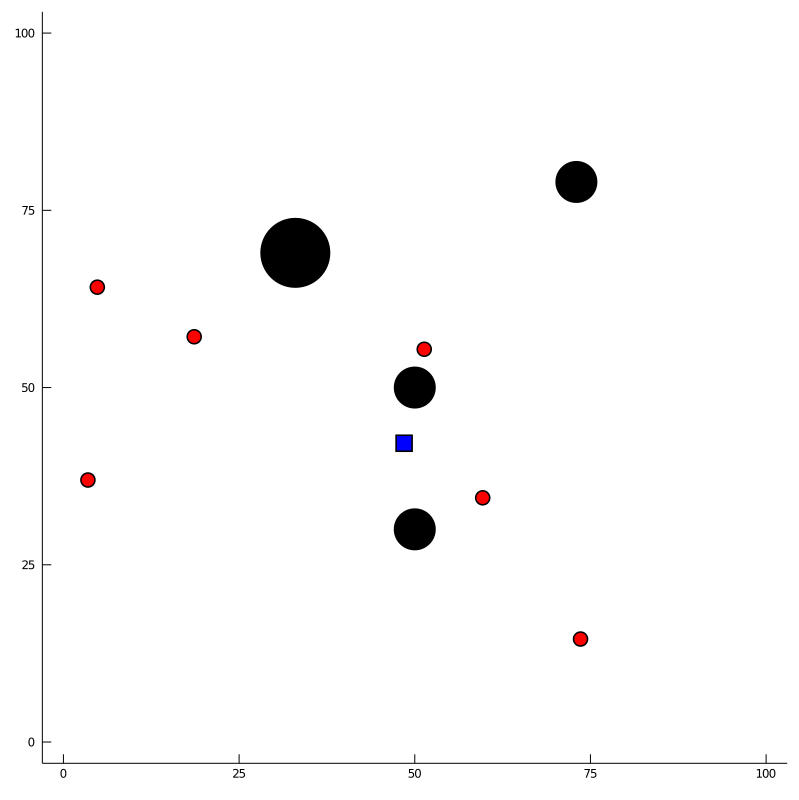

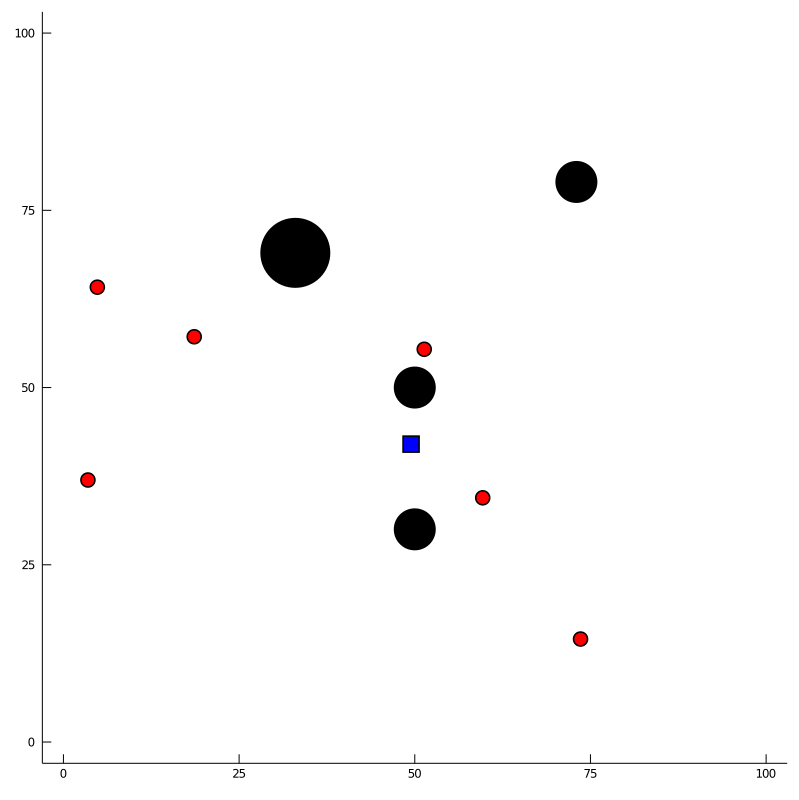

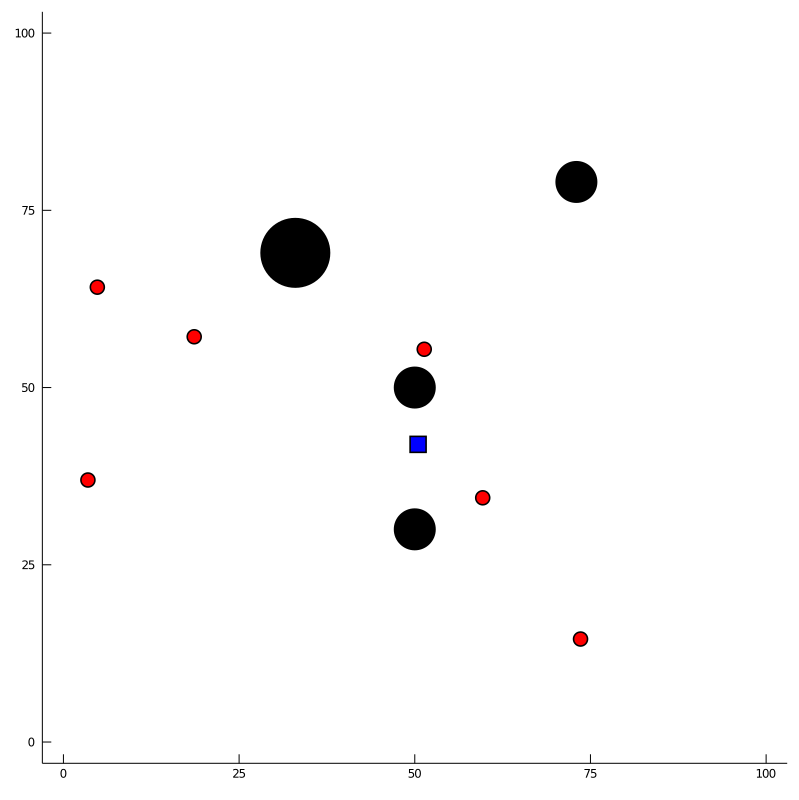

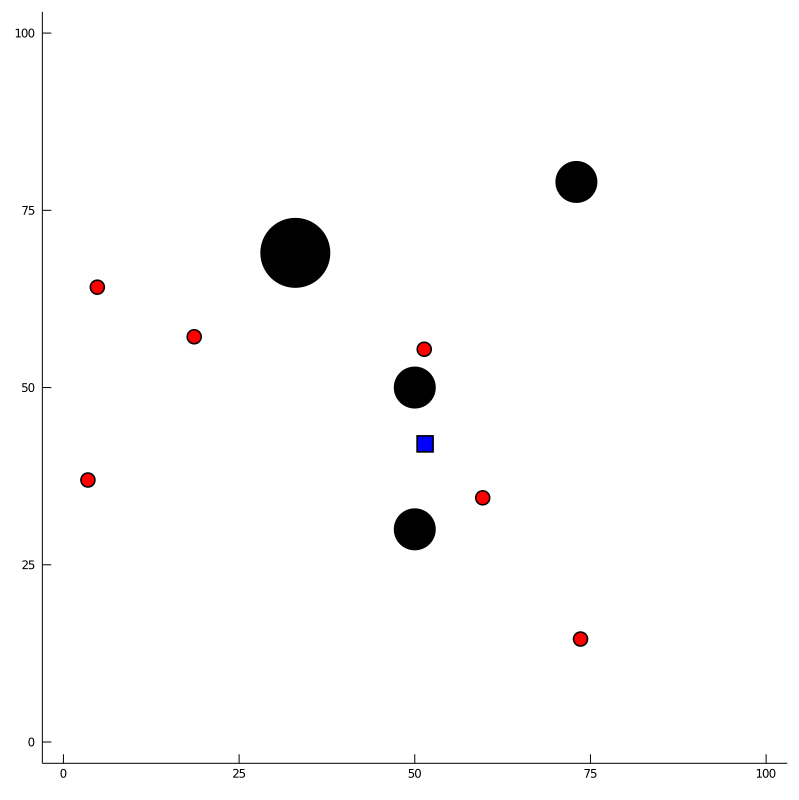

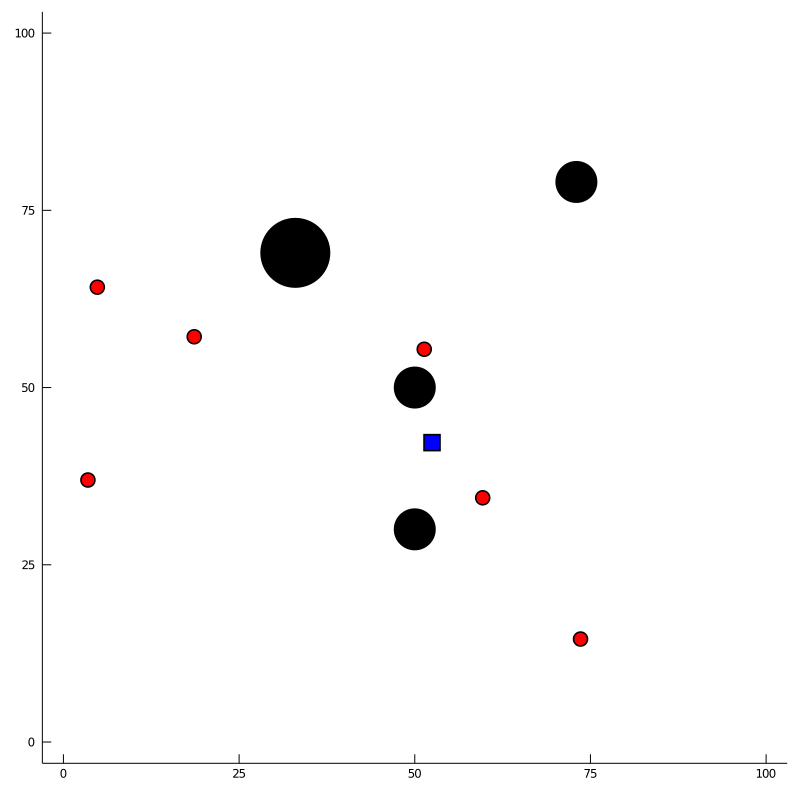

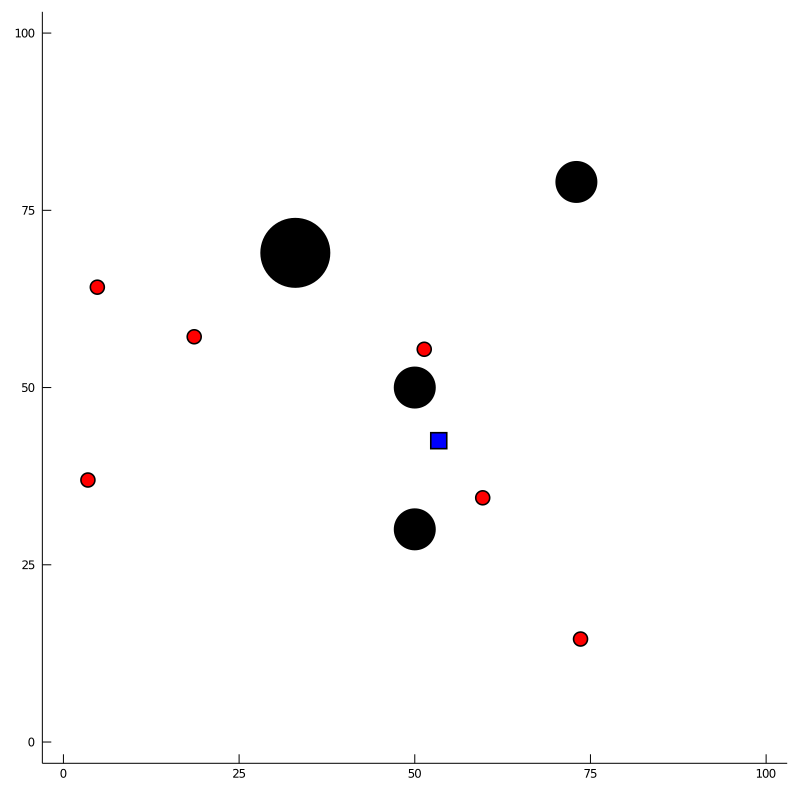

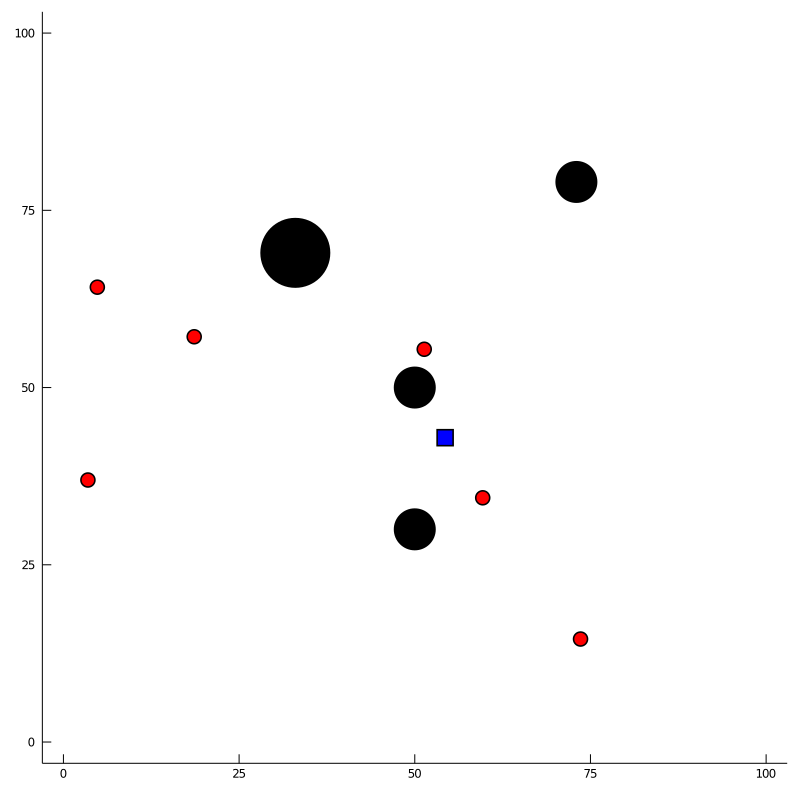

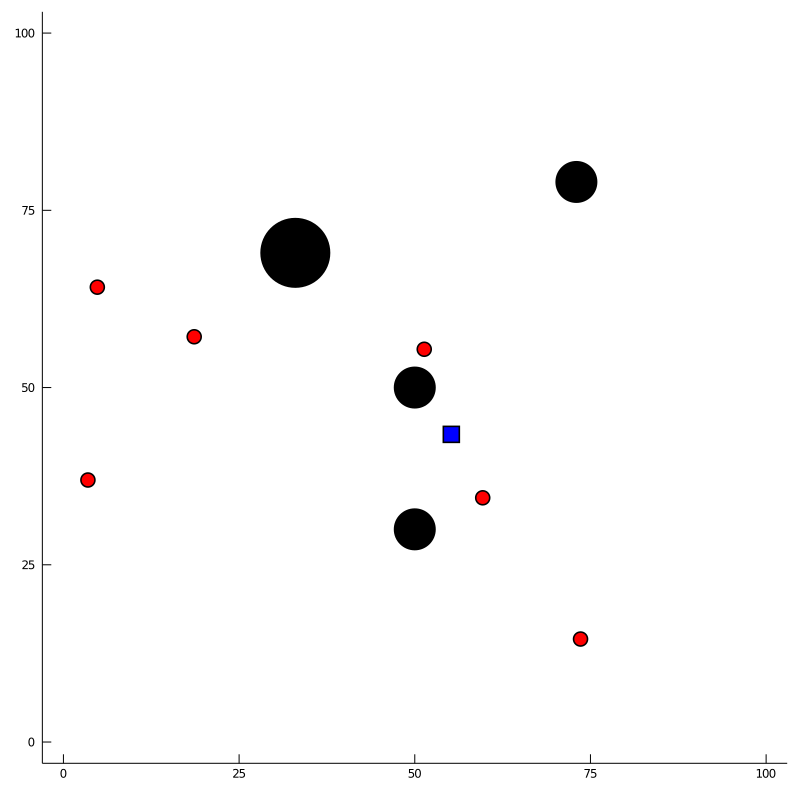

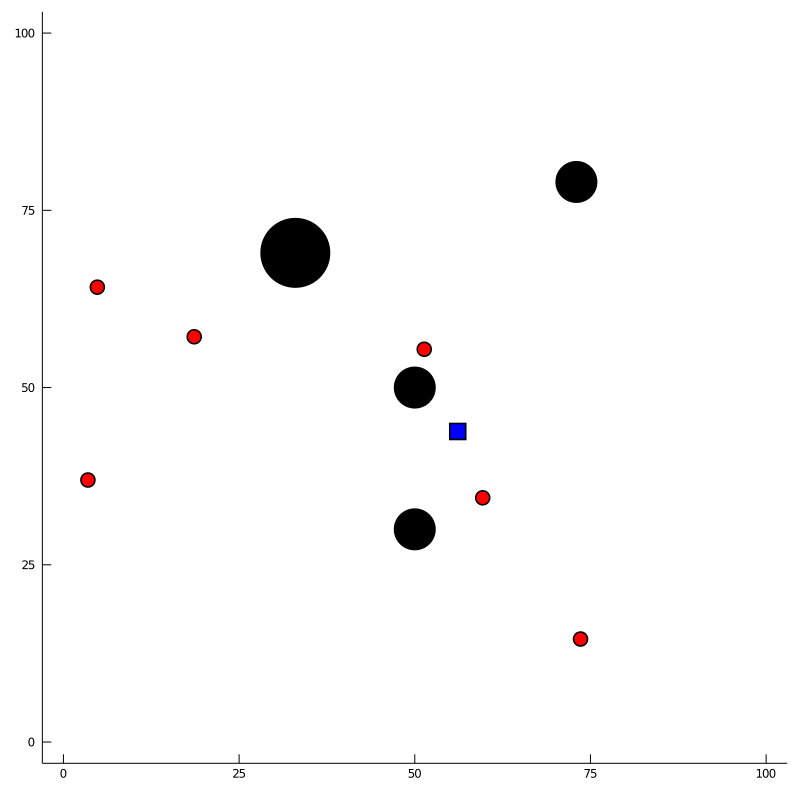

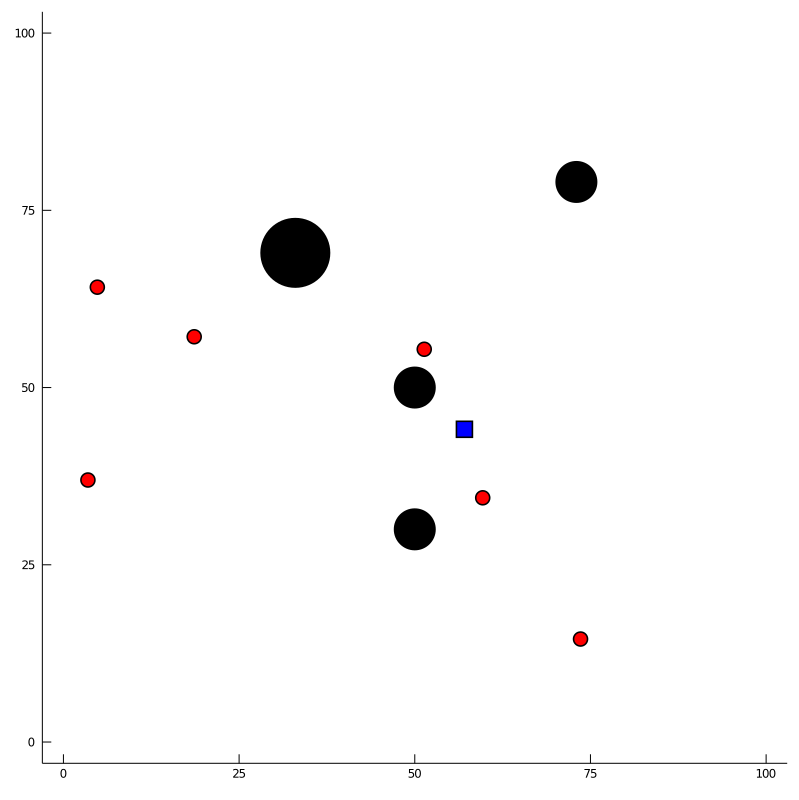

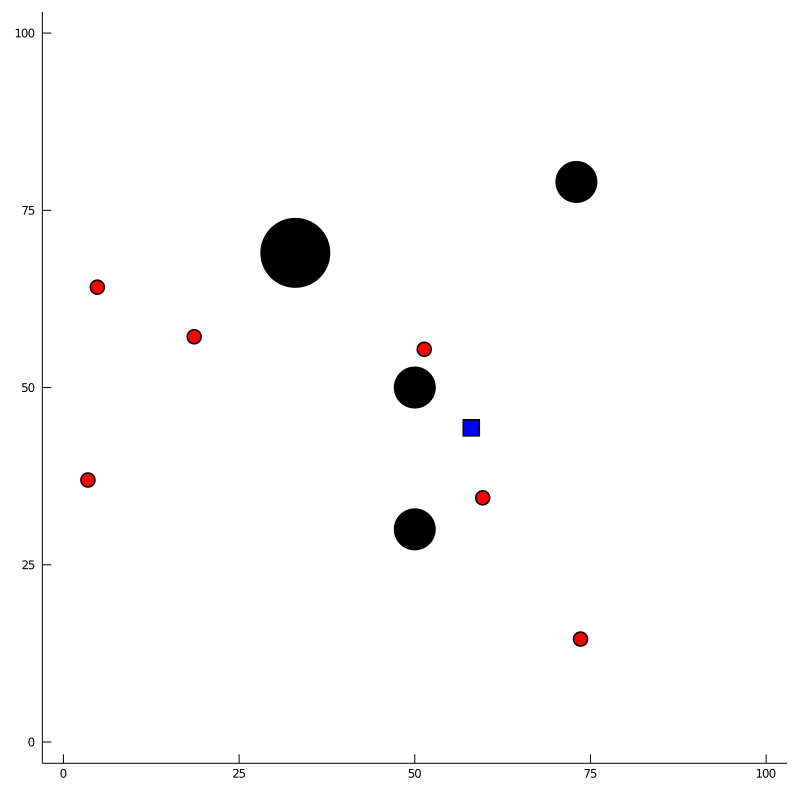

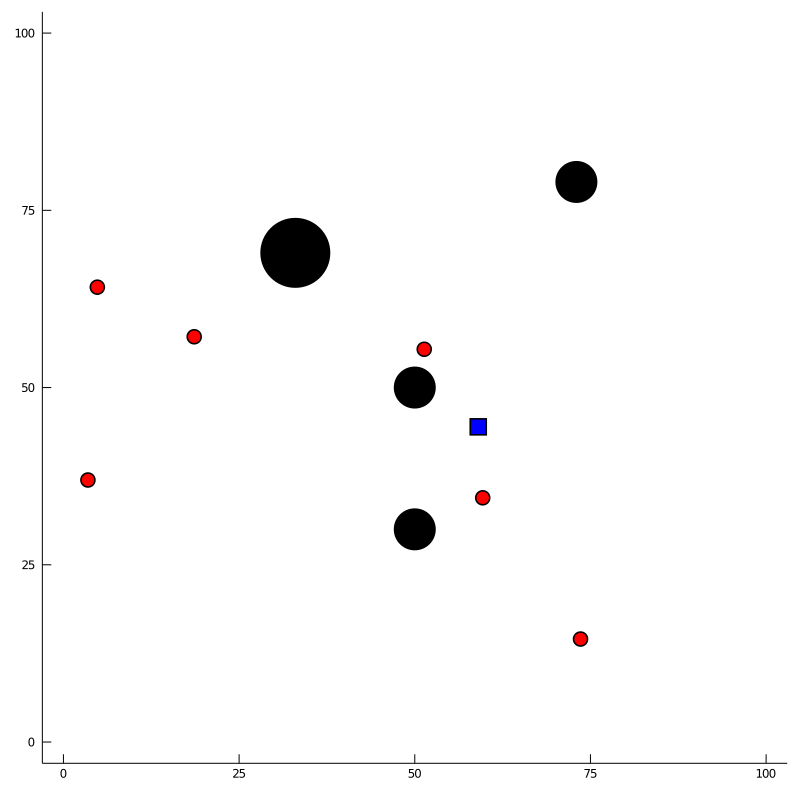

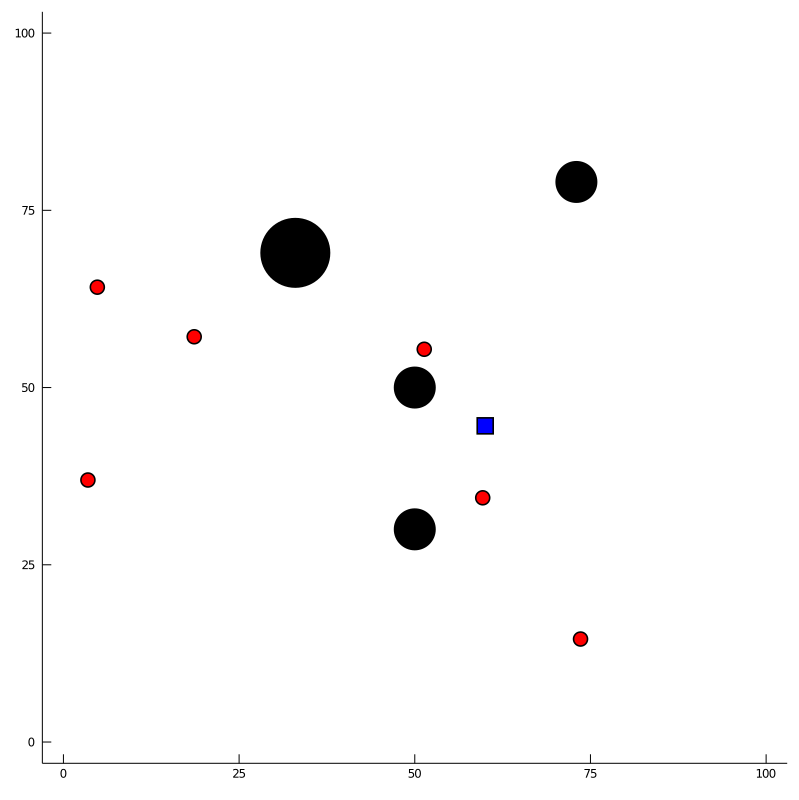

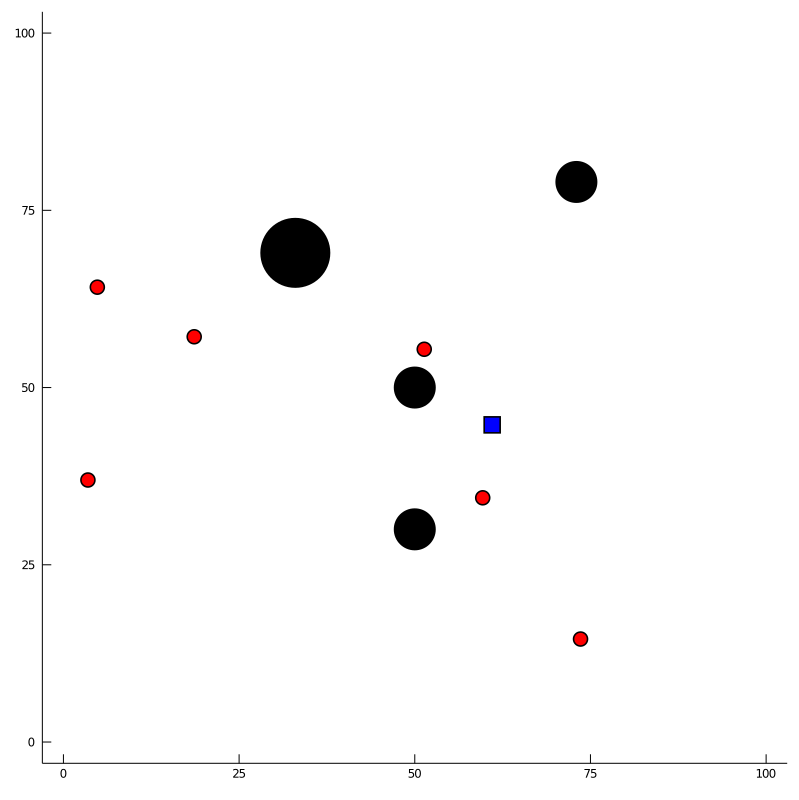

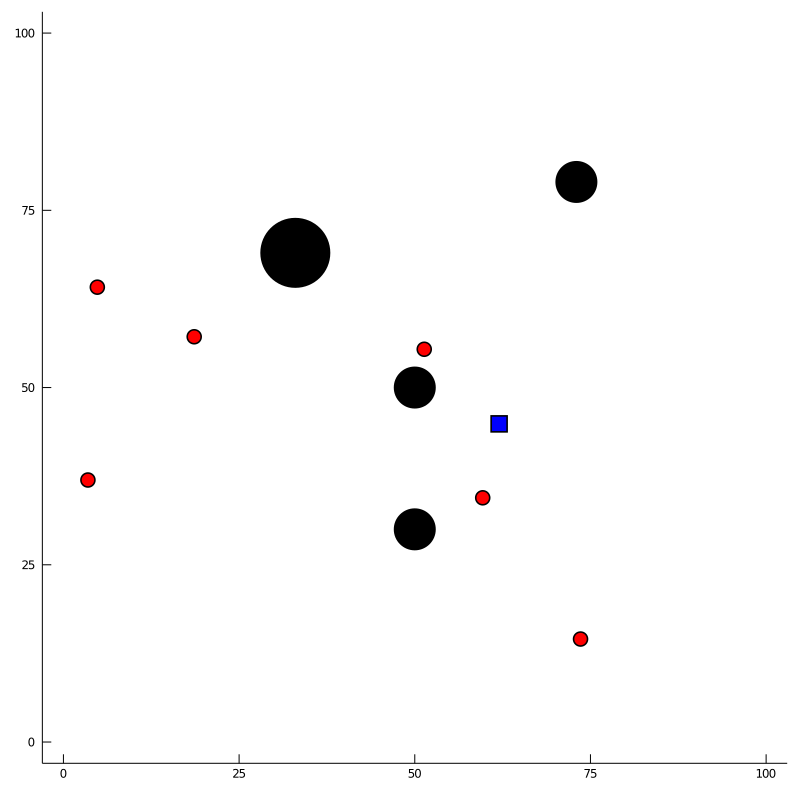

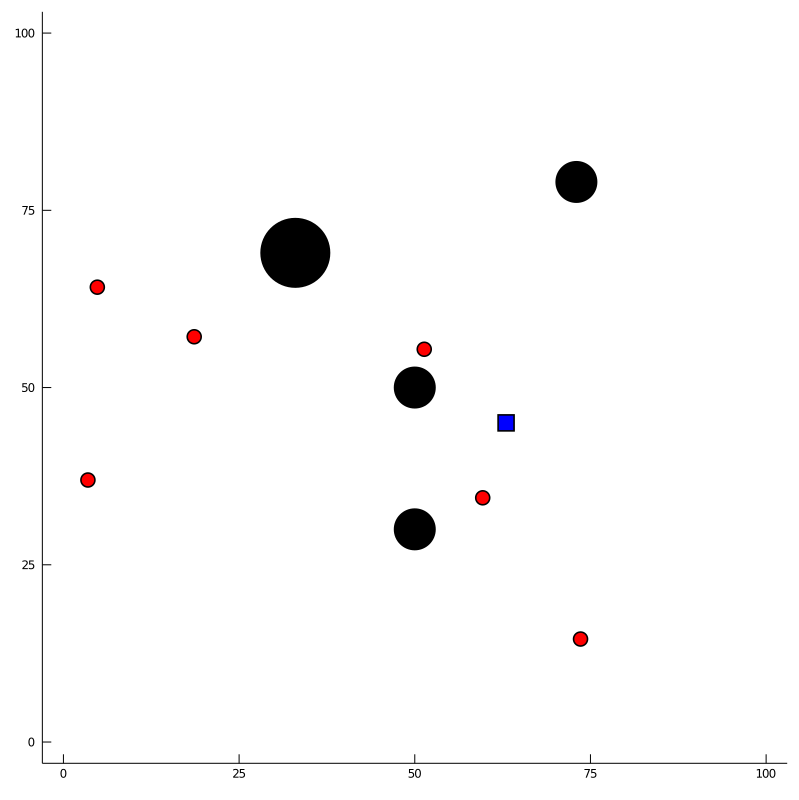

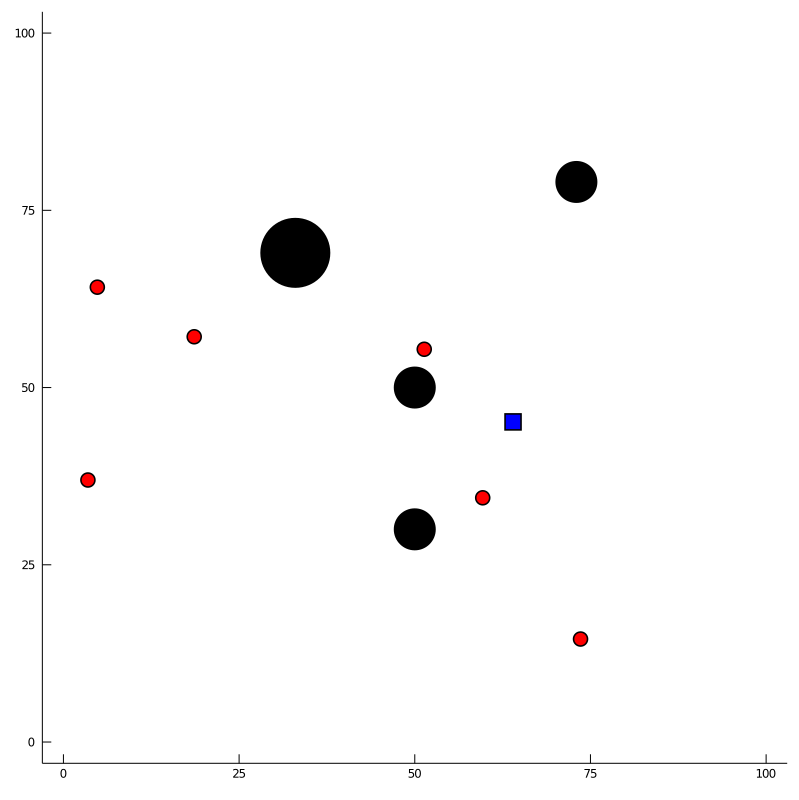

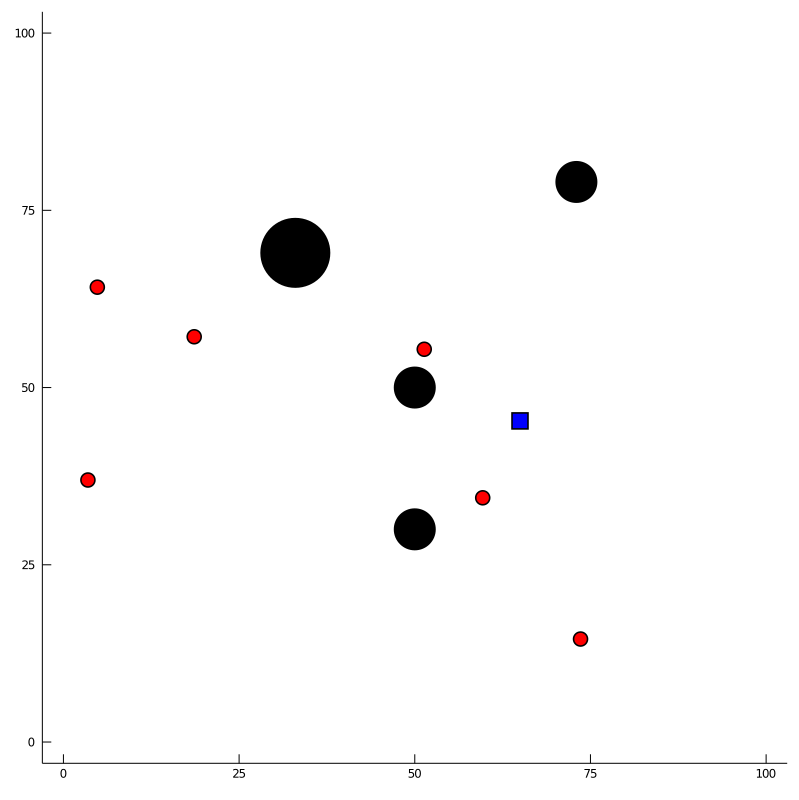

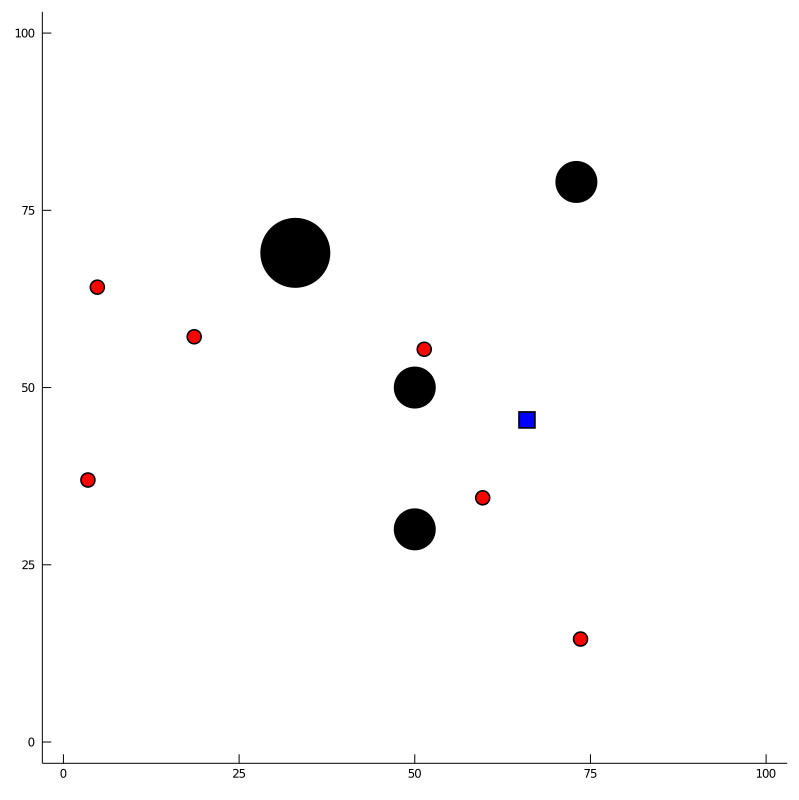

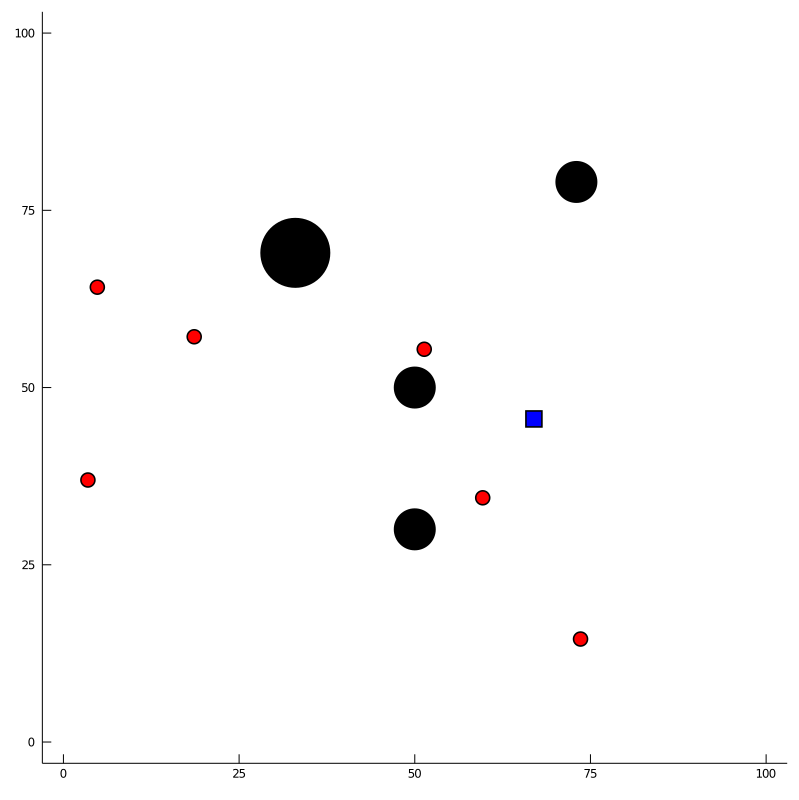

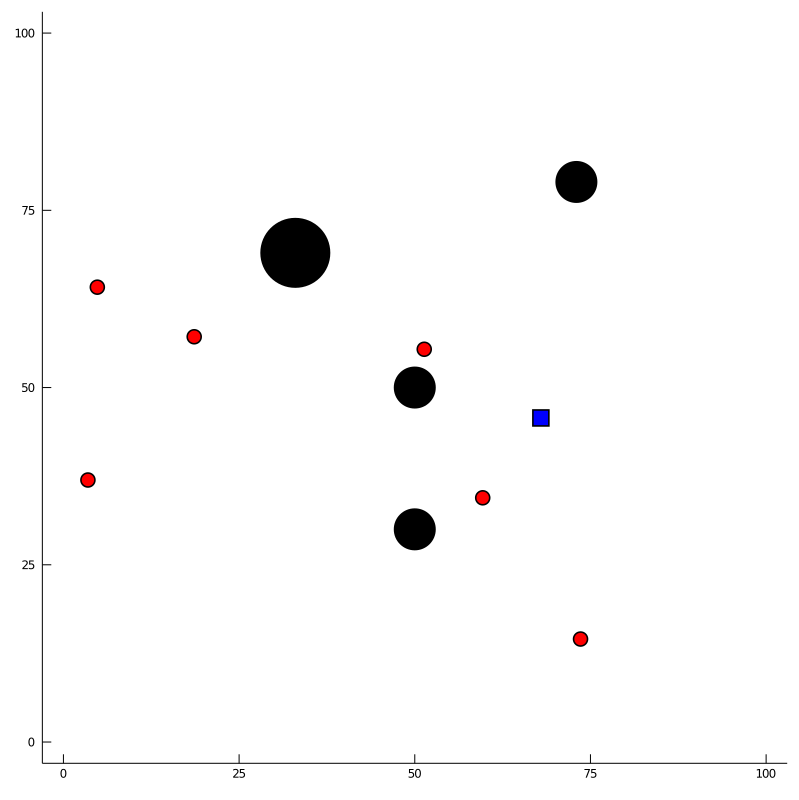

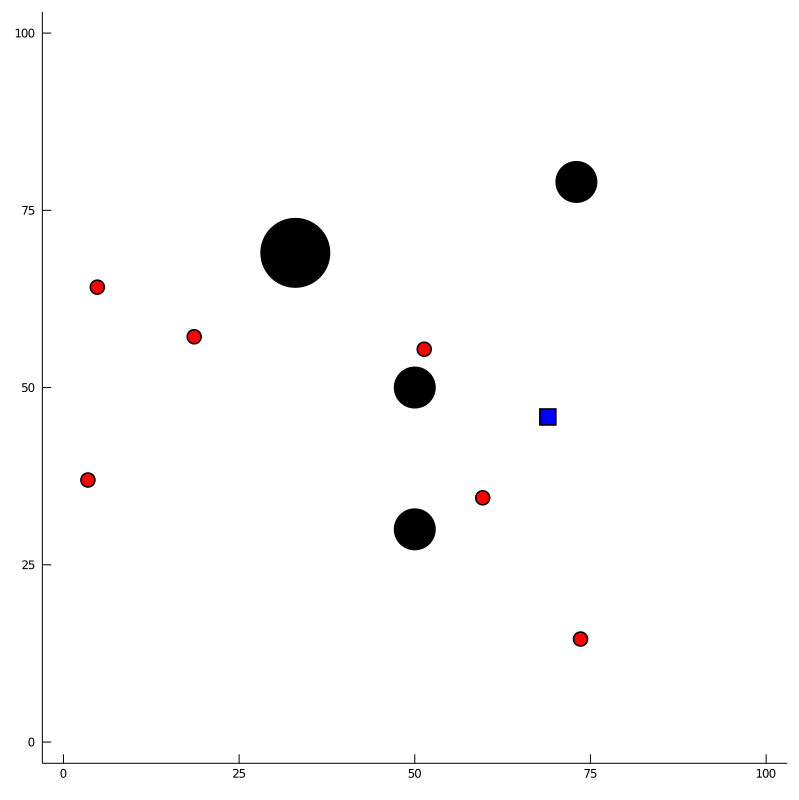

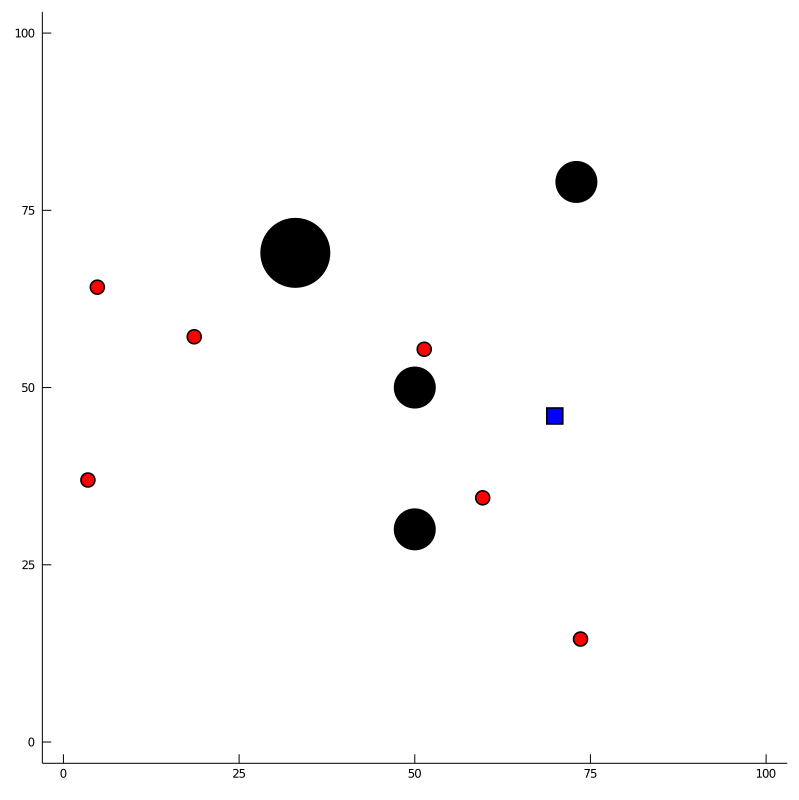

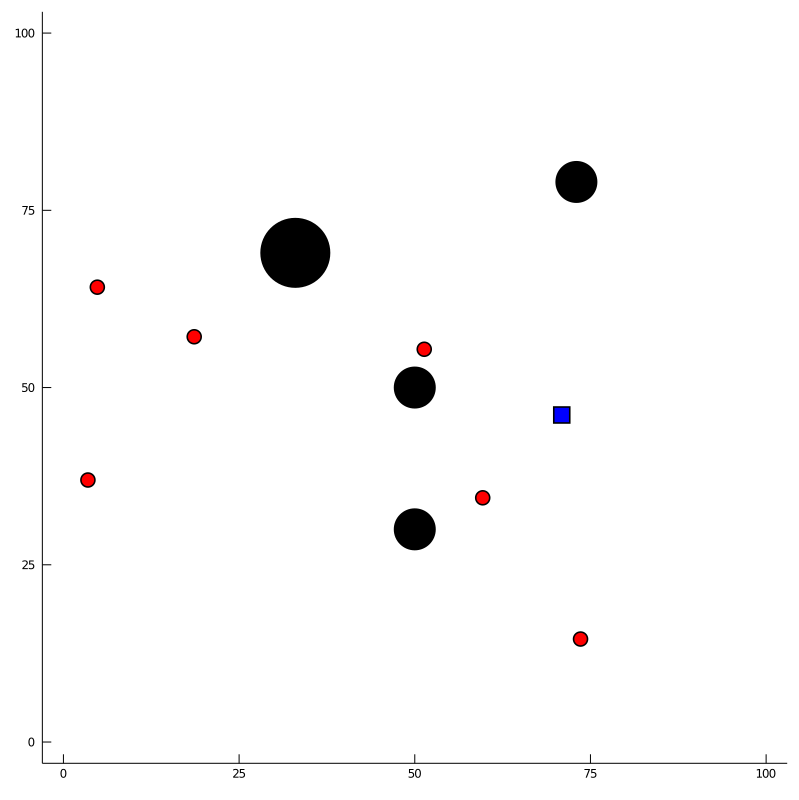

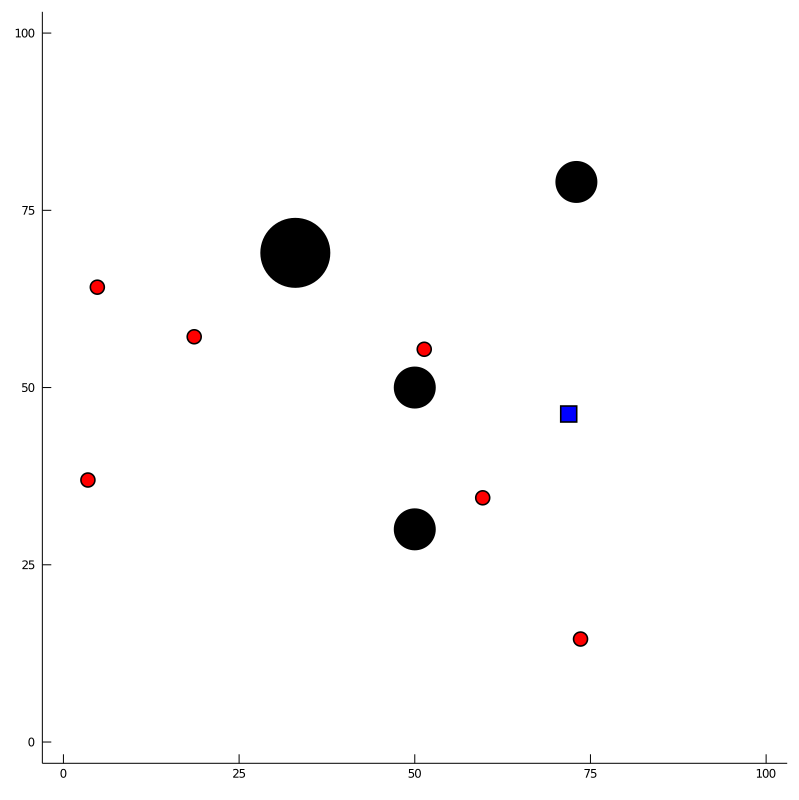

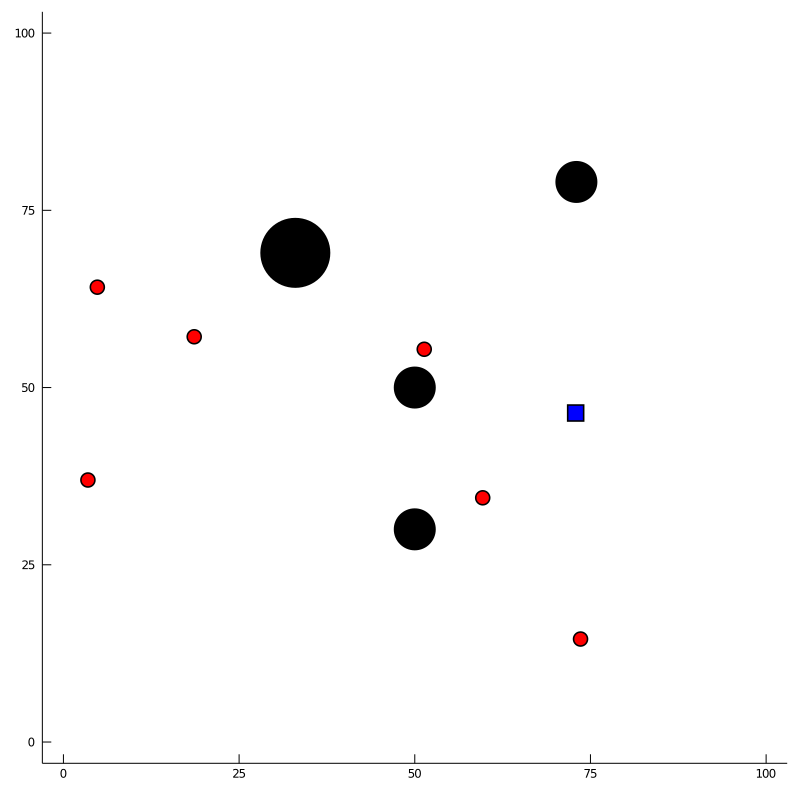

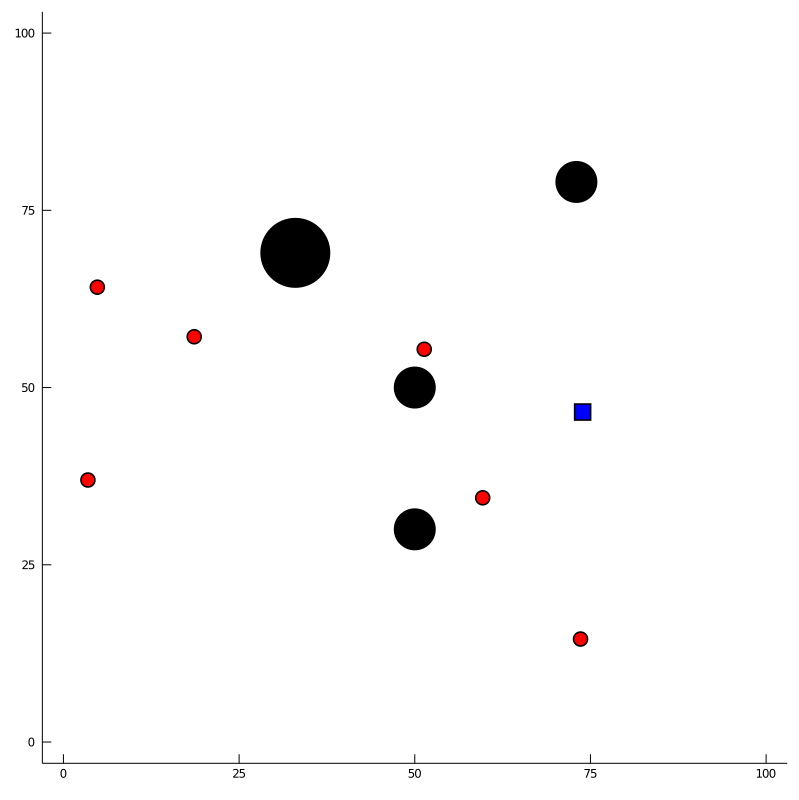

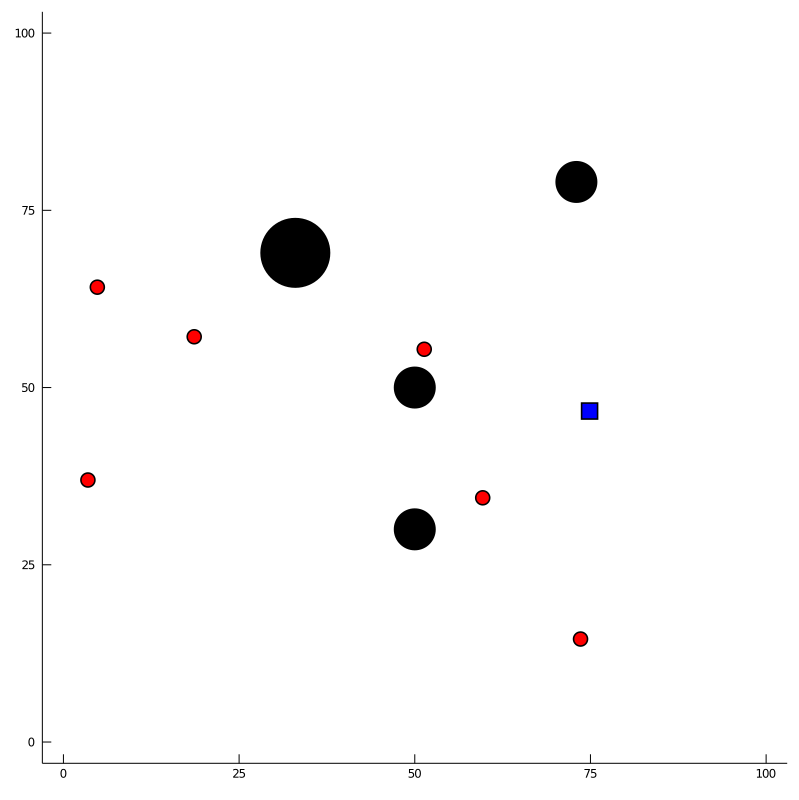

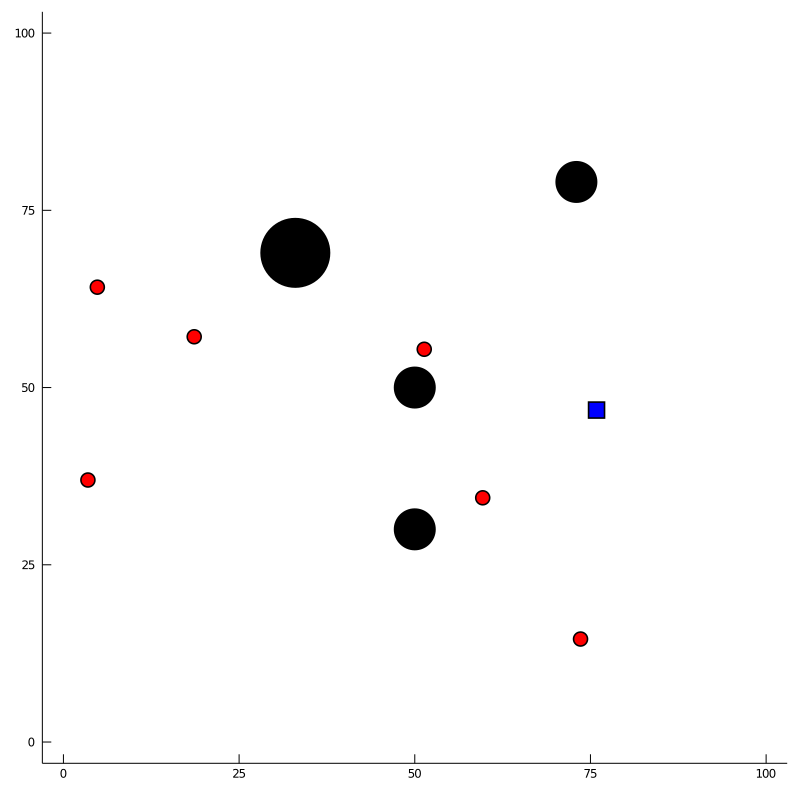

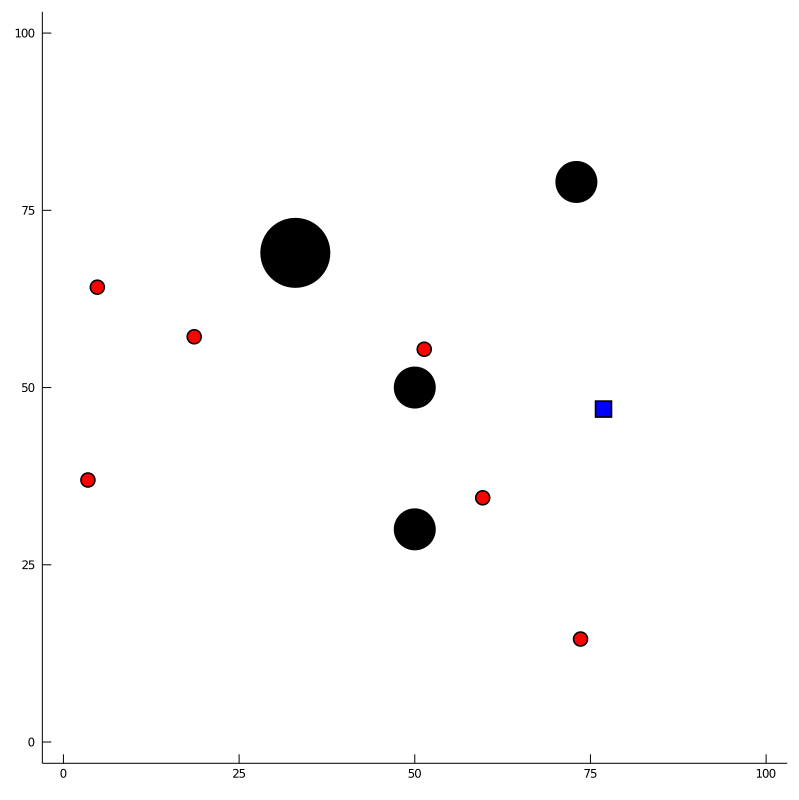

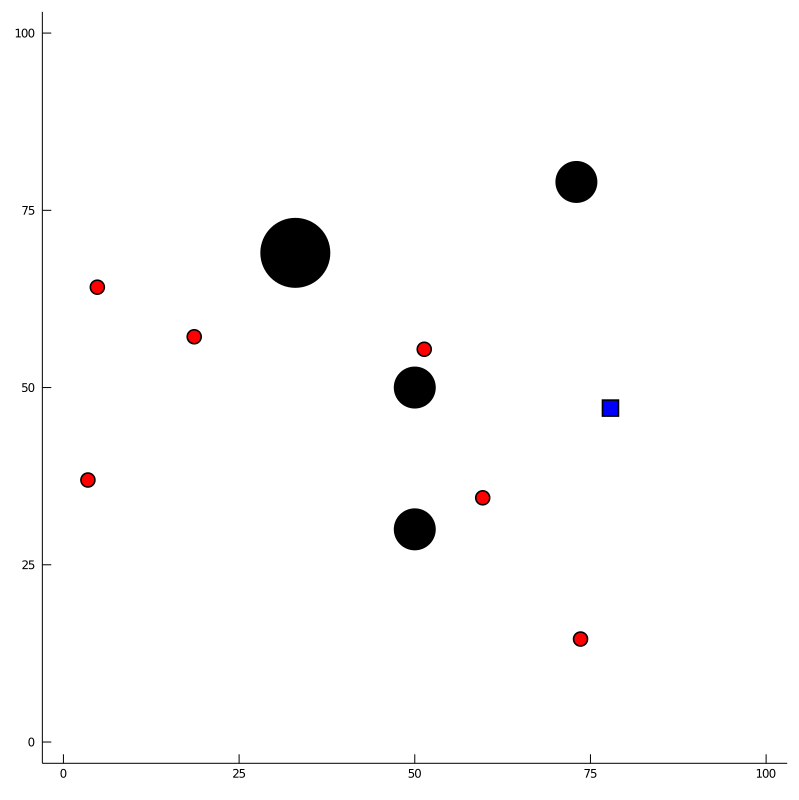

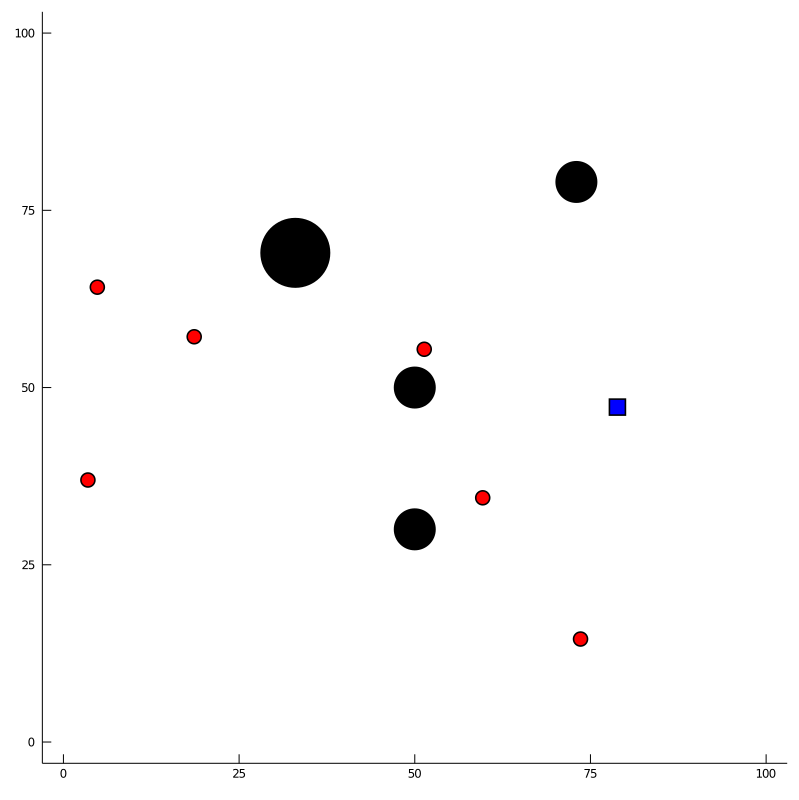

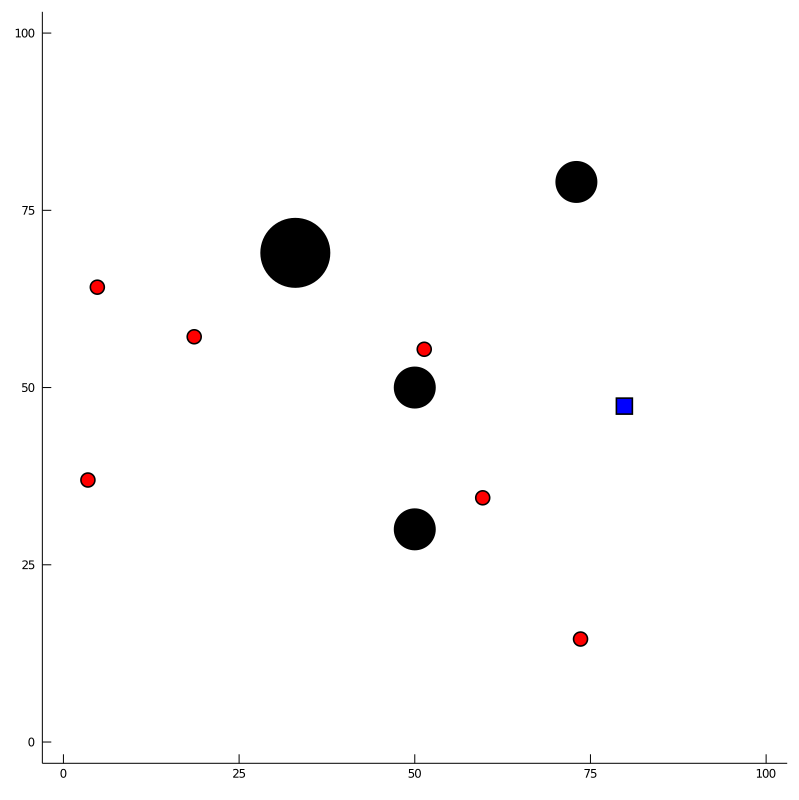

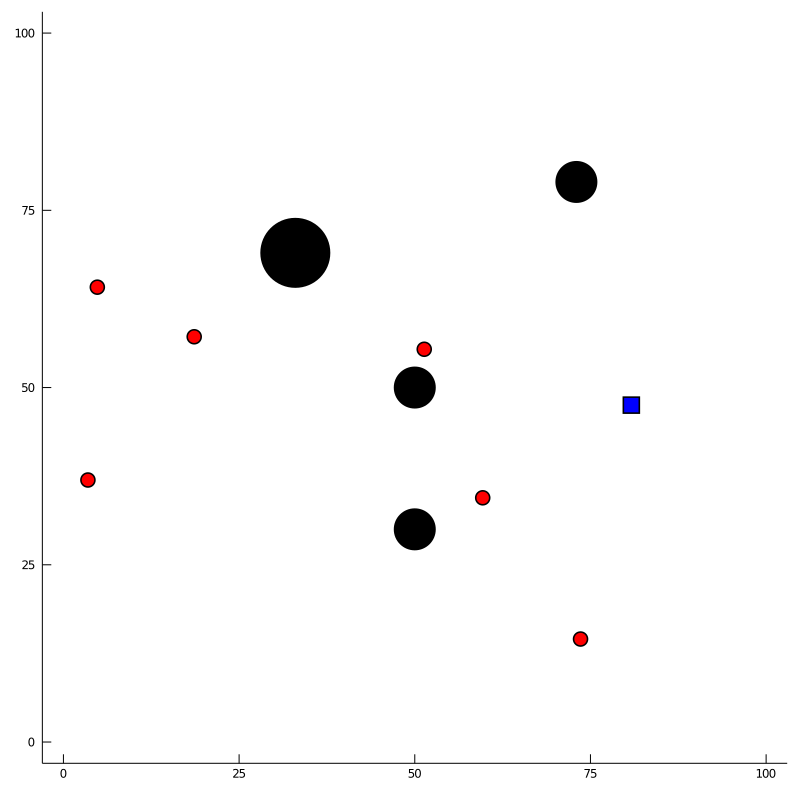

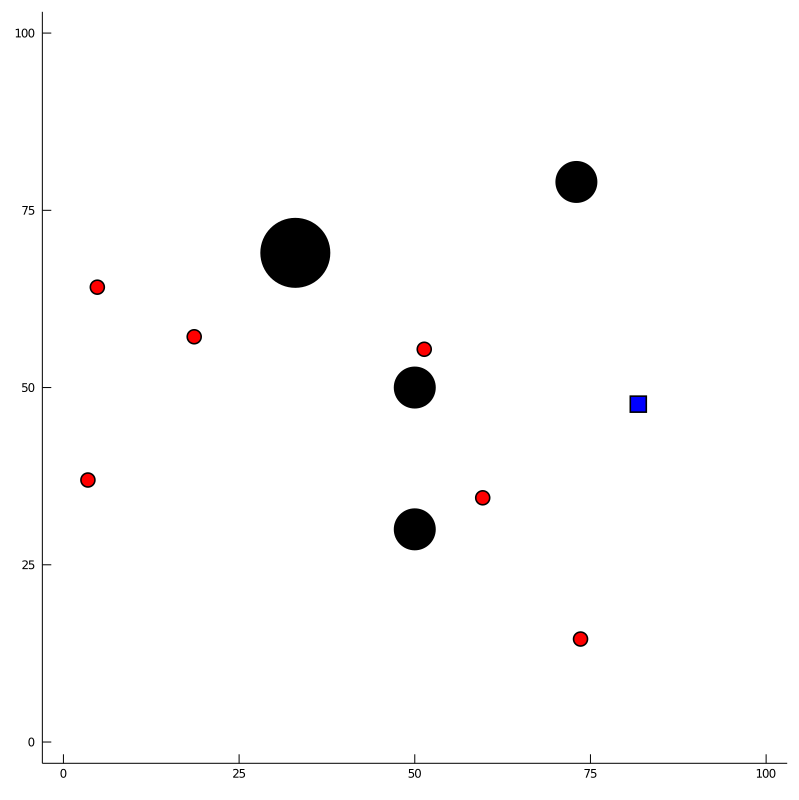

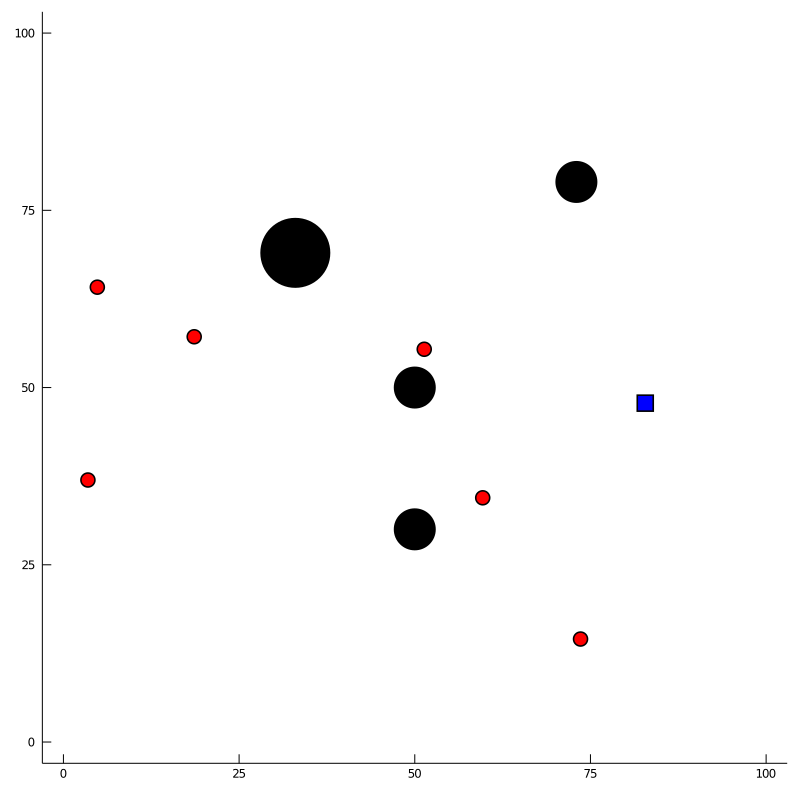

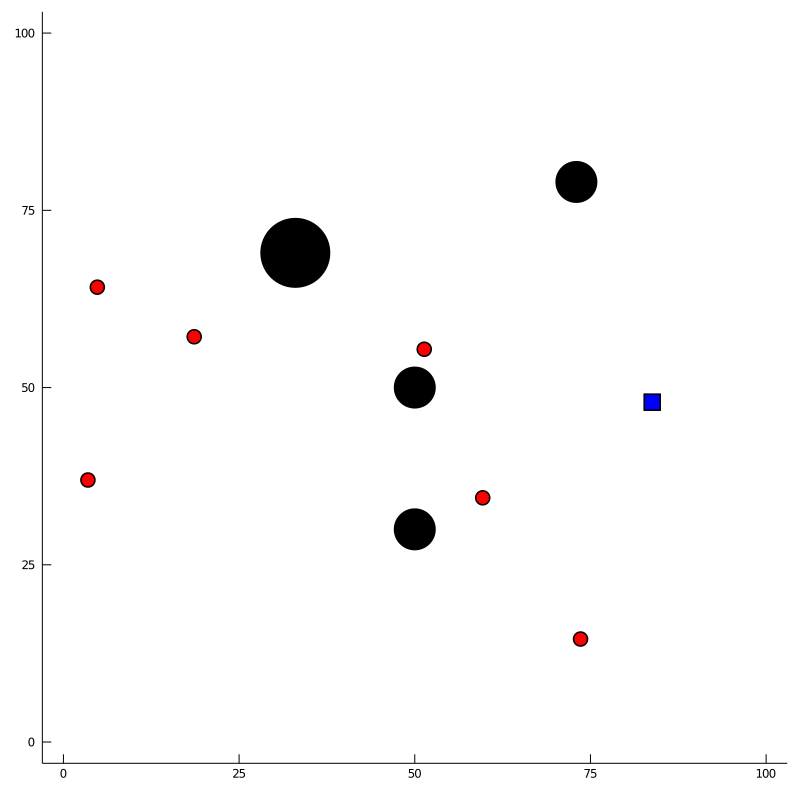

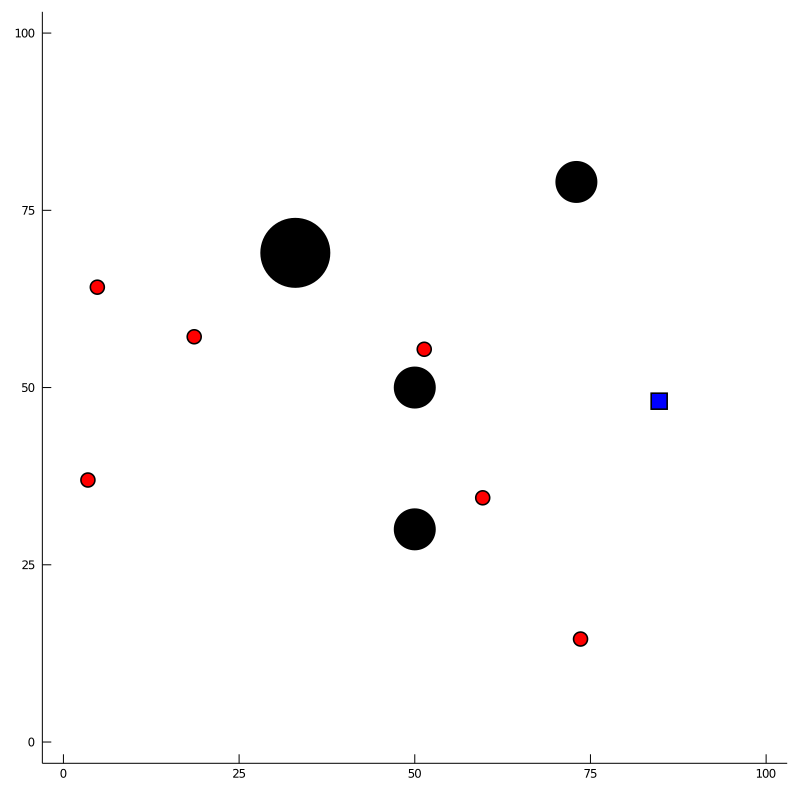

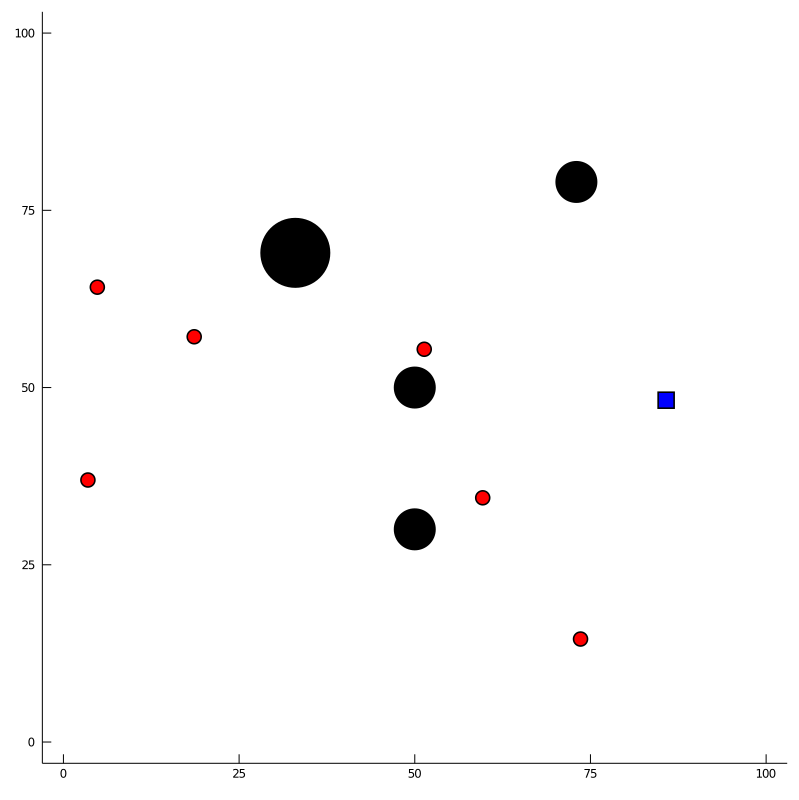

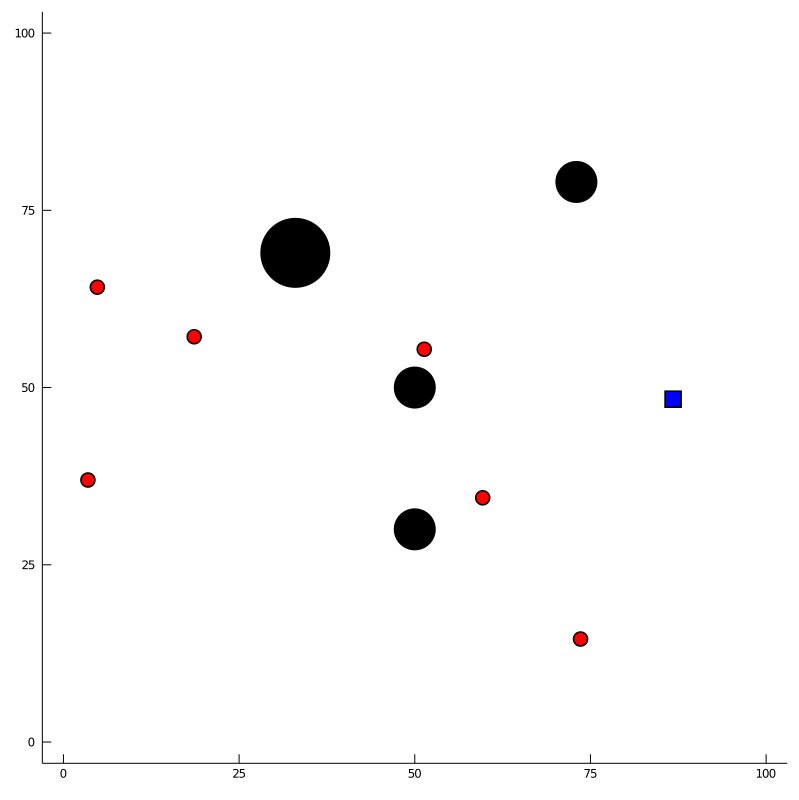

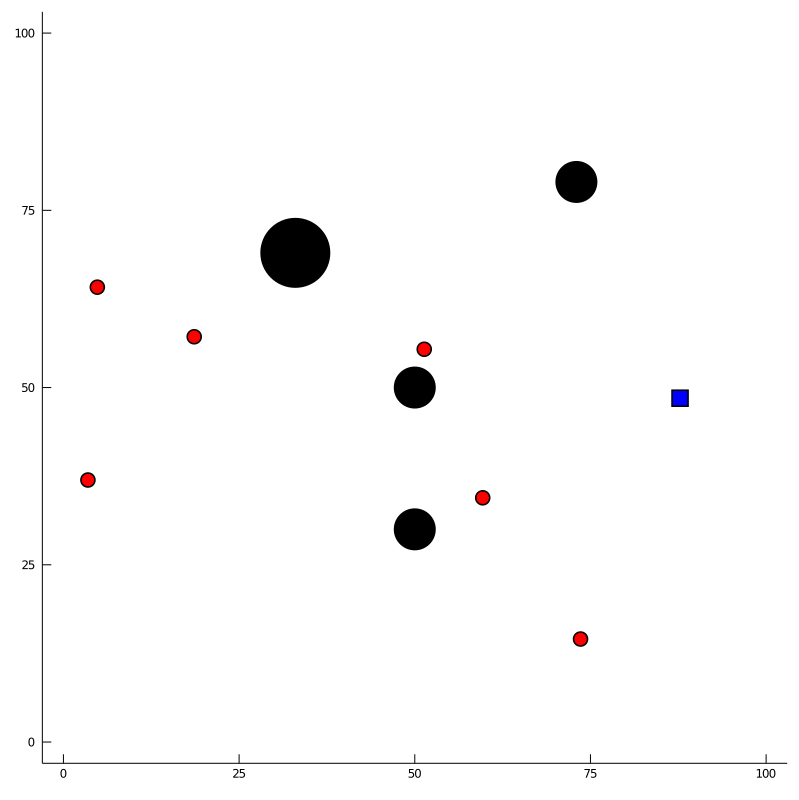

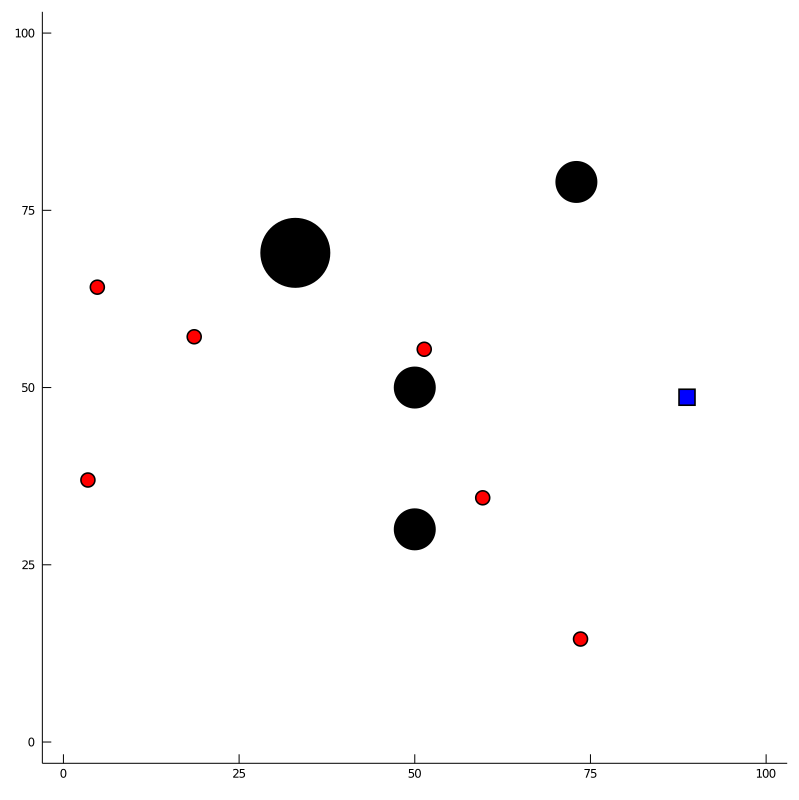

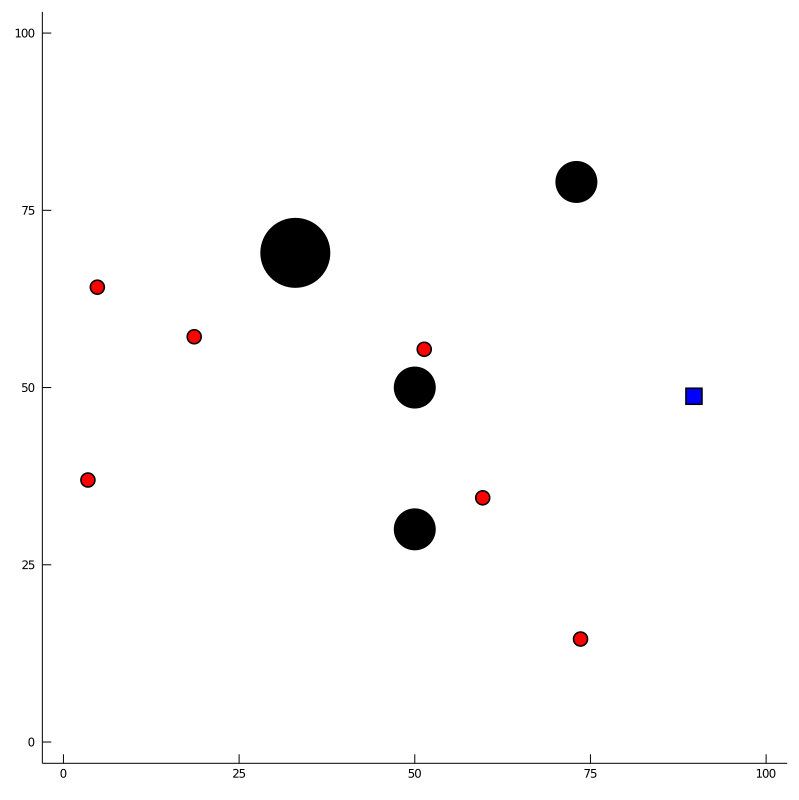

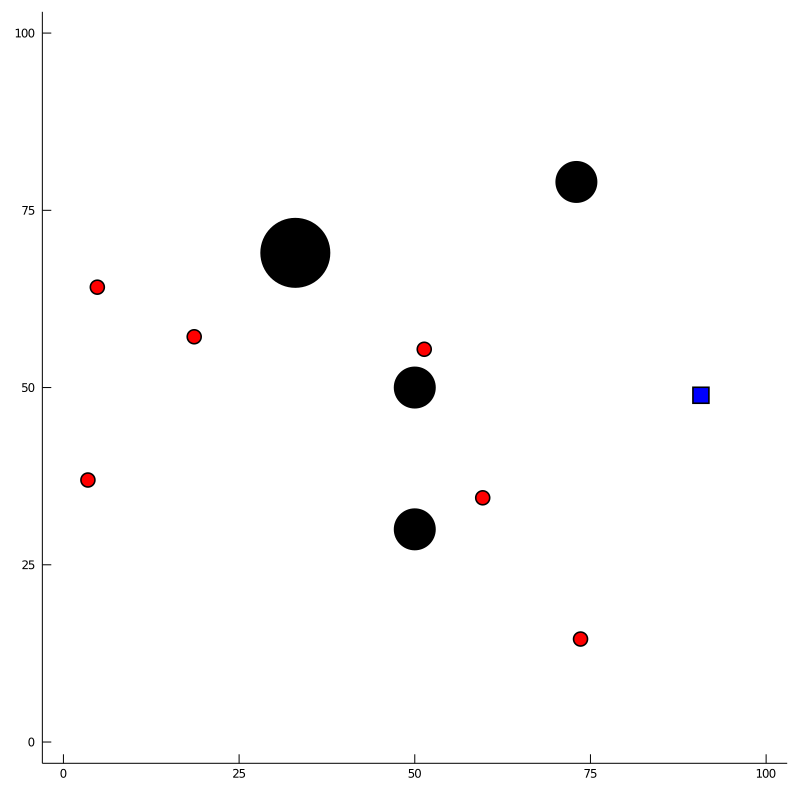

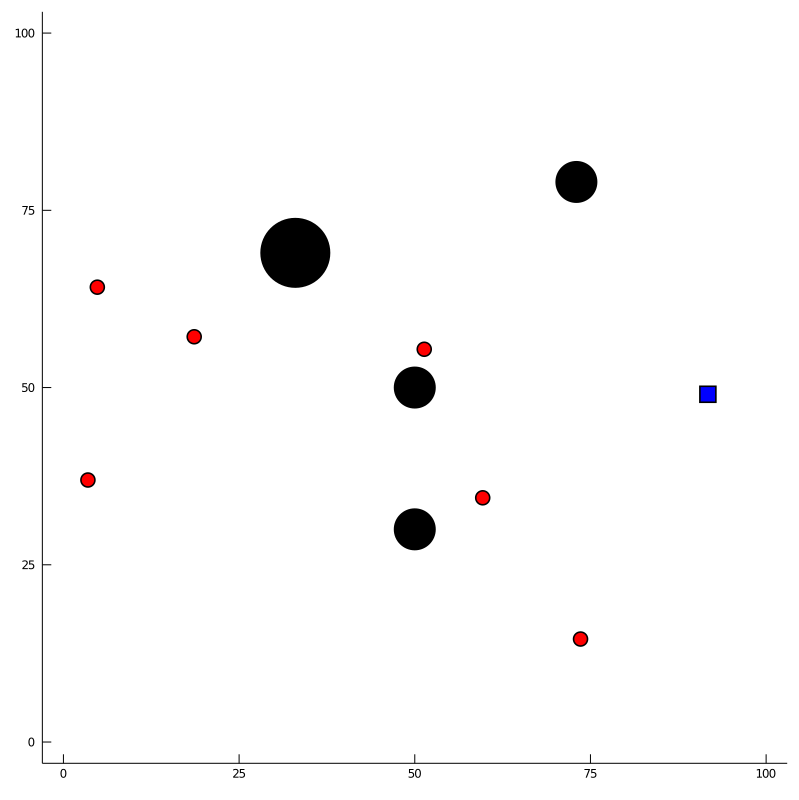

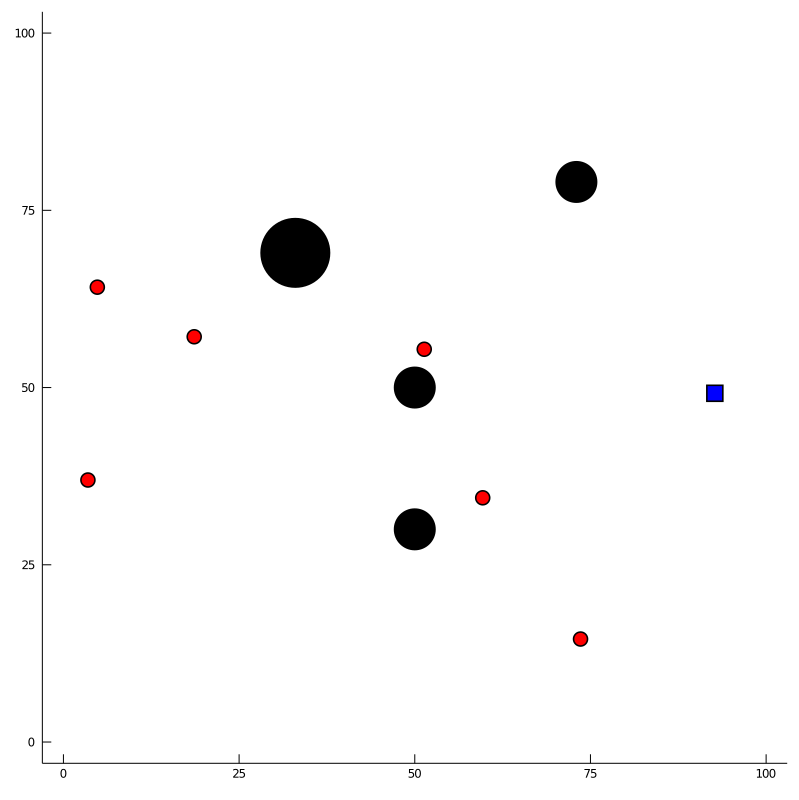

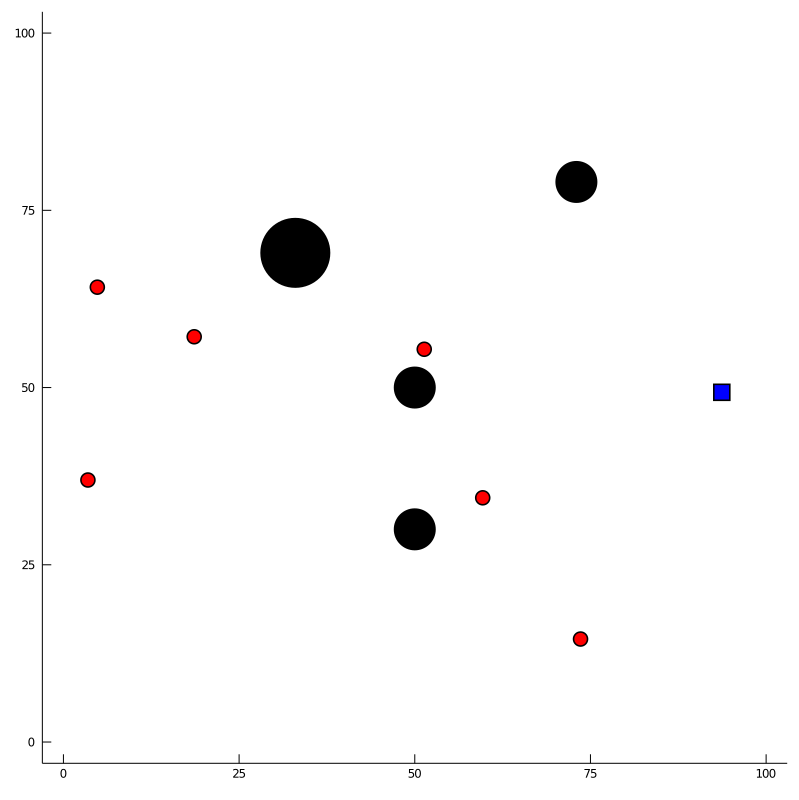

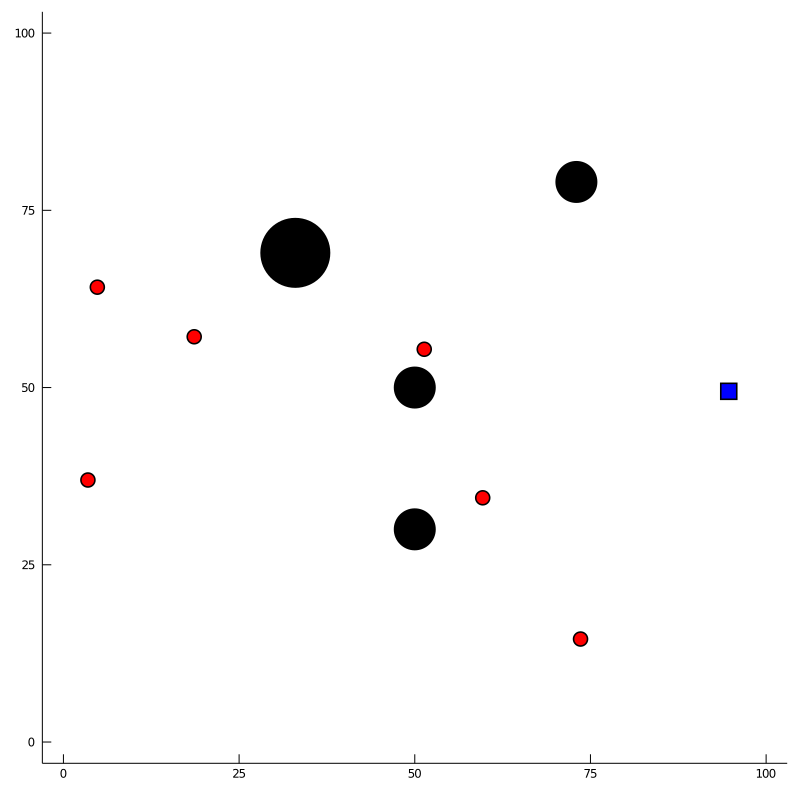

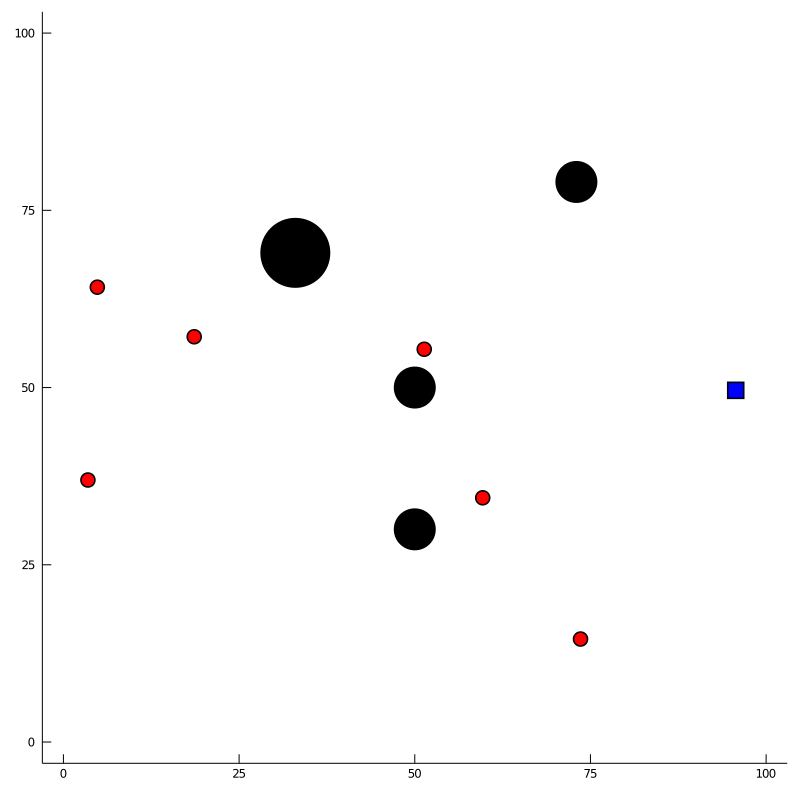

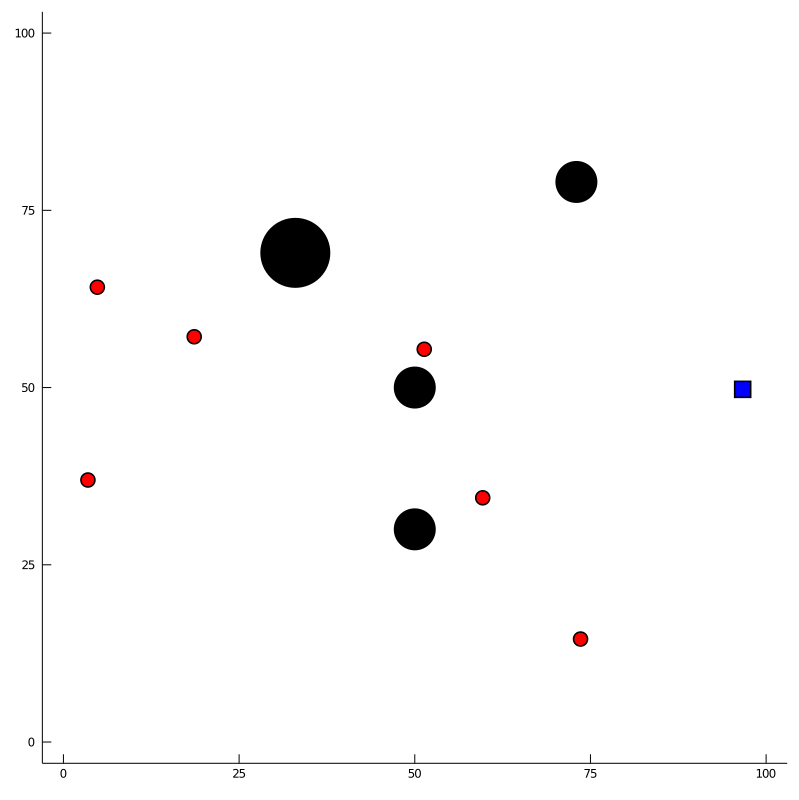

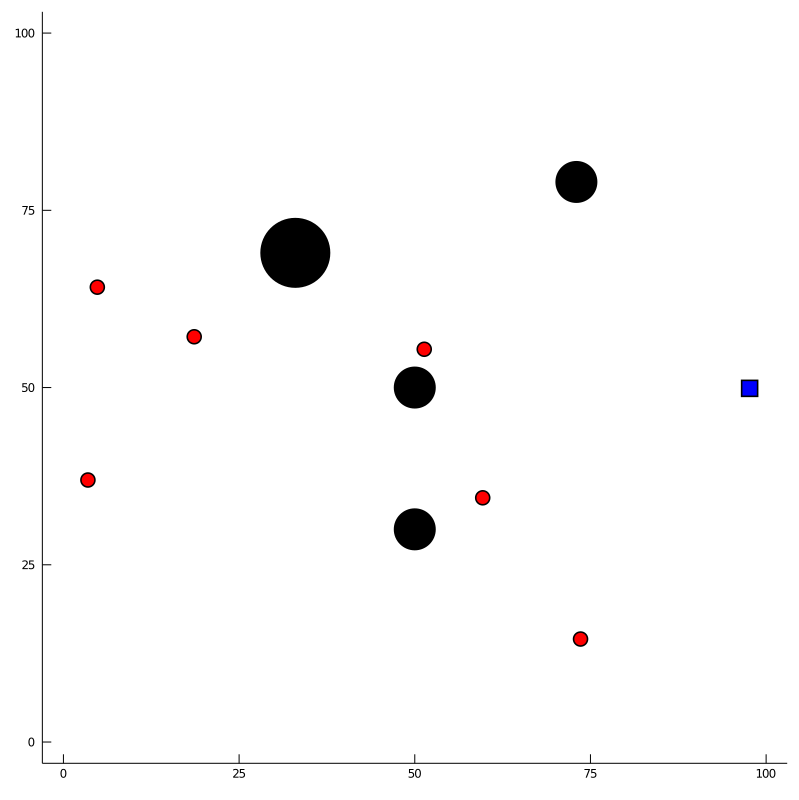

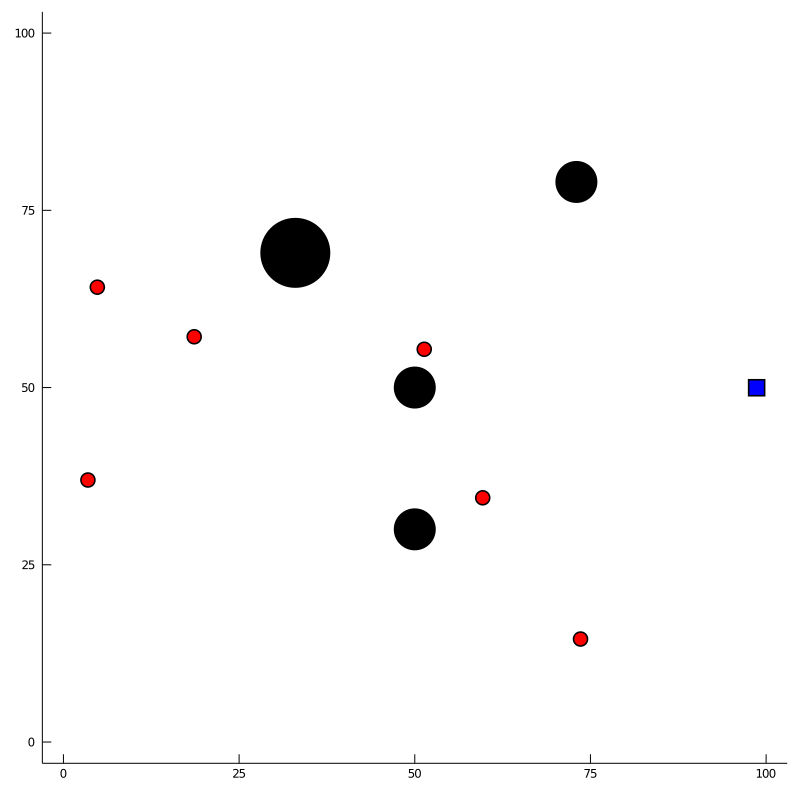

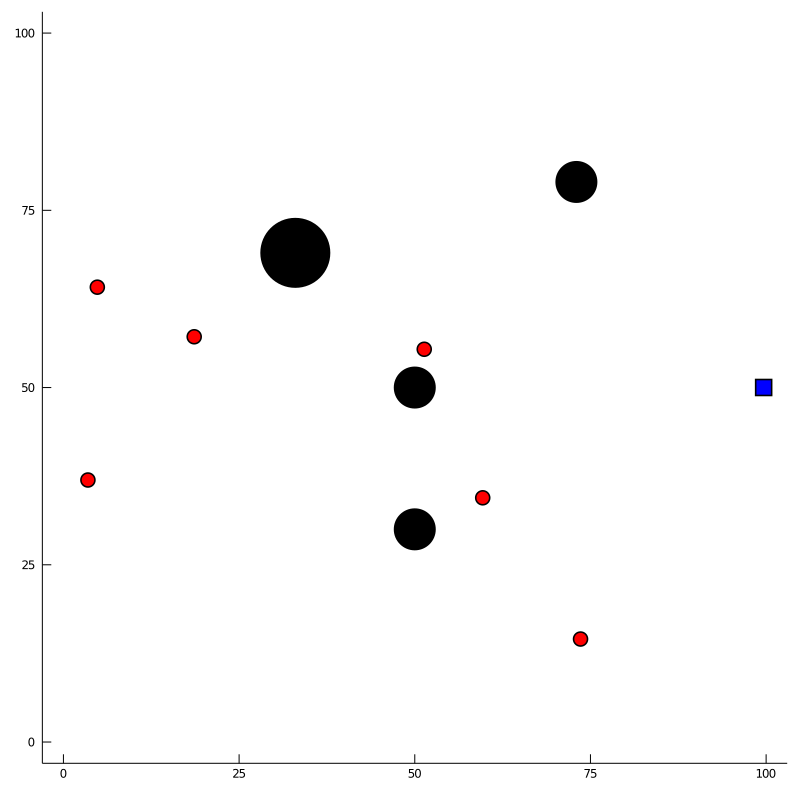

┌ Info: Saved animation to 
│   fn = /home/himanshu/Documents/Padhai/Research_Projects/human_aware_navigation/Pipeline_OG_implementation/hybrid_a_star_path_checking.gif
└ @ Plots /home/himanshu/.julia/packages/Plots/6RLiv/src/animation.jl:104


Plots.AnimatedGif("/home/himanshu/Documents/Padhai/Research_Projects/human_aware_navigation/Pipeline_OG_implementation/hybrid_a_star_path_checking.gif")
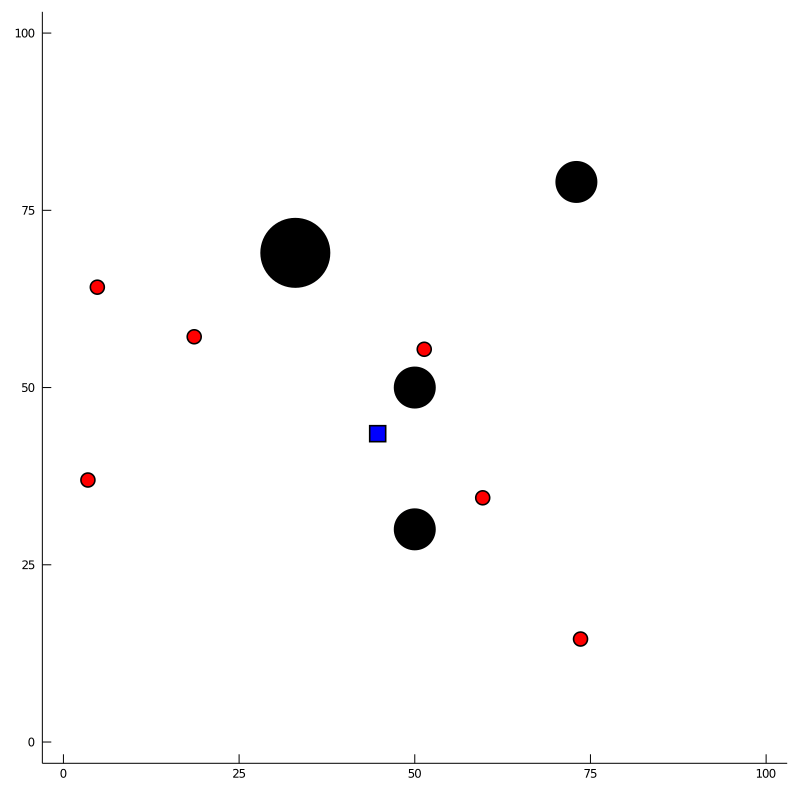

In [140]:
hybrid_astar_debugging_env = deepcopy(pomdp_ub_debugging_env)
# hybrid_astar_debugging_env.cart_hybrid_astar_path = hybrid_a_star_search(hybrid_astar_debugging_env.cart.x,
#     hybrid_astar_debugging_env.cart.y, hybrid_astar_debugging_env.cart.theta, 
#     hybrid_astar_debugging_env.cart.goal.x, hybrid_astar_debugging_env.cart.goal.y, 
#     hybrid_astar_debugging_env,all_observed_environments[1][2]);

x_init,y_init,theta_init = hybrid_astar_debugging_env.cart.x, 
                        hybrid_astar_debugging_env.cart.y, hybrid_astar_debugging_env.cart.theta
initial_state = [x_init,y_init,theta_init]
path_x, path_y, path_theta = [x_init],[y_init],[theta_init]

for steering_angle in hybrid_astar_debugging_env.cart_hybrid_astar_path
    extra_parameters = [1.0, hybrid_astar_debugging_env.cart.L, steering_angle]
    x,y,theta = get_intermediate_points(initial_state, 1.0, extra_parameters);
    push!(path_x,last(x))
    push!(path_y,last(y))
    push!(path_theta,last(theta))
    initial_state = [last(x),last(y),last(theta)]
end

anim = @animate for i ∈ 1:length(path_x)
    hybrid_astar_debugging_env.cart.x = path_x[i]
    hybrid_astar_debugging_env.cart.y = path_y[i]
    display(hybrid_astar_debugging_env);
end
gif(anim, "hybrid_a_star_path_checking.gif", fps = 10)

In [ ]:
#Start Simulation
one_time_step = 1.0
env_copy = deepcopy(env)

#Sense humans near cart before moving
initial_cart_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), 10))
        push!(initial_cart_lidar_data,human)
    end
end
env_copy.cart_lidar_data = initial_cart_lidar_data

#Generate Initial Belief for humans near cart
initial_belief = update_belief([],env_copy.goals,[],env_copy.cart_lidar_data)

#Propogate humans for one time step
moved_human_positions = Array{human_state,1}()
for human in env_copy.humans
    push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
end
env_copy.humans = moved_human_positions

#Sense humans near cart after the first time step
new_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), 10))
        push!(new_lidar_data,human)
    end
end
    
current_belief = update_belief(initial_belief, env_copy.goals, env_copy.cart_lidar_data, new_lidar_data)
env_copy.cart_lidar_data = new_lidar_data


while(!is_within_range(location(env.cart.x,env.cart.y), env.cart.goal, 1.0))
    env.cart_hybrid_astar_path = hybrid_a_star_search(env.cart.x, env.cart.y, env.cart.theta, env.cart.goal.x, env.cart.goal.y, env);
    if(length(env.cart_hybrid_astar_path) == 0)
        @show("SOme error")
        break
    end
    @show("Before updated",env.cart)
    m = golfcart_pomdp()
    b = initialstate_distribution(m,initial_human_dis_list)
    a = action(planner, b);
    @show("Action",a)
    env.cart.v = clamp(env.cart.v + a,0,m.max_cart_speed)
    if(env.cart.v != 0.0)
        initial_state = [env.cart.x,env.cart.y,env.cart.theta]
        for i in 1:Int64(env.cart.v)
            if(i>length(env.cart_hybrid_astar_path))
                break
            end
            steering_angle = env.cart_hybrid_astar_path[i]
            extra_parameters = [env.cart.v, env.cart.L, steering_angle]
            x,y,theta = get_intermediate_points(initial_state, 1.0/env.cart.v, extra_parameters);
            env.cart.x, env.cart.y, env.cart.theta = last(x), last(y), last(theta)
            initial_state = [env.cart.x,env.cart.y,env.cart.theta]
        end
    else
        @show("LALA")
    end

    moved_human_positions = Array{human_state,1}()
    for human in env.humans
        push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env,one_time_step))
    end

    current_belief = update_belief(current_belief, env, env.humans, moved_human_positions)
    env.humans = moved_human_positions
    #display(env)
    #@show("After updated",env.cart)
end





#Sense humans near cart before moving
initial_cart_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), 10))
        push!(initial_cart_lidar_data,human)
    end
end
env_copy.cart_lidar_data = initial_cart_lidar_data

#Generate Initial Belief for humans near cart
initial_belief = update_belief([],env_copy.goals,[],env_copy.cart_lidar_data)

#Propogate humans for one time step
moved_human_positions = Array{human_state,1}()
for human in env_copy.humans
    push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
end
env_copy.humans = moved_human_positions

#Sense humans near cart after the first time step
new_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), 10))
        push!(new_lidar_data,human)
    end
end
    
global current_belief = update_belief(initial_belief, env_copy.goals, env_copy.cart_lidar_data, new_lidar_data)
env_copy.cart_lidar_data = new_lidar_data

global j = 1

anim = @animate for j ∈ 1:10000
    if(!is_within_range(location(env_copy.cart.x,env_copy.cart.y), env_copy.cart.goal, 1.0))
        env_copy.cart_hybrid_astar_path = hybrid_a_star_search(env_copy.cart.x, env_copy.cart.y, 
            env_copy.cart.theta, env_copy.cart.goal.x, env_copy.cart.goal.y, env_copy);
        if(length(env_copy.cart_hybrid_astar_path) == 0)
            @show("Some error")
            break
        end
        m = golfcart_pomdp()
        b = initialstate_distribution(m,current_belief)
        a = action(planner, b)
        env_copy.cart.v = clamp(env_copy.cart.v + a,0,m.max_cart_speed)
        if(env_copy.cart.v != 0.0)
            initial_state = [env_copy.cart.x,env_copy.cart.y,env_copy.cart.theta]
            for i in 1:Int64(env_copy.cart.v)
                #@show(initial_state)
                if(i>length(env_copy.cart_hybrid_astar_path))
                    break
                end
                steering_angle = env_copy.cart_hybrid_astar_path[i]
                extra_parameters = [env_copy.cart.v, env_copy.cart.L, steering_angle]
                x,y,theta = get_intermediate_points(initial_state, 1.0/env_copy.cart.v, extra_parameters);
                env_copy.cart.x, env_copy.cart.y, env_copy.cart.theta = last(x), last(y), last(theta)
                initial_state = [env_copy.cart.x,env_copy.cart.y,env_copy.cart.theta]
            end
        else
            @show("LALA")
        end
        @show(i)
        moved_human_positions = Array{human_state,1}()
        for human in env_copy.humans
            push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
        end
        env_copy.humans = moved_human_positions

        new_lidar_data = Array{human_state,1}()
        for human in env_copy.humans
            if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), 10))
                push!(new_lidar_data,human)
            end
        end
        
        global current_belief = update_belief(initial_belief, env_copy.goals, 
            env_copy.cart_lidar_data, new_lidar_data)
        env_copy.cart_lidar_data = new_lidar_data

        #display(env_copy)
        push!(cart_throughout_path,copy(env_copy.cart))
    else
        break
    end
end
gif(anim, "og_pipeline_new.gif", fps = 2)

In [ ]:
env

In [ ]:
is_within_range(location(env.cart.x,env.cart.y), env.cart.goal, 1.0)

In [ ]:
d2 = initialstate_distribution(golfcart_pomdp(),current_belief)
d2.probs

In [ ]:
d1 = initialstate_distribution_modified(golfcart_pomdp(),current_belief);
d1.vals[199]

In [ ]:
d2.vals[199]

In [ ]:
k1,k2,k3 = initialstate_distribution(golfcart_pomdp(),current_belief);

In [ ]:


x1 = Array{SP_POMDP_state,1}()
x2 = Array{Float64,1}()
@show(x1,x2)
#    
x1,x2 = @time generate_pomdp_states_and_probability(1,6,env.humans,env.goals,length(env.goals),current_belief,env.cart,1,x1,x2);
#dd = recursive_function(1,6,env.humans,env.goals,length(env.goals),initial_human_dis_list,x1,x2);

In [ ]:
xx = []
for i in 1:length(xx)
    @show(i)
end

In [ ]:
#OLD INITIAL STATE DISTRIBUTION FUNCTION


# function initialstate_distribution(m::Speed_Planner_POMDP,initial_human_goal_probability)
#     initial_cart_state = m.world.cart
#     all_human_goal_locations = m.world.goals
#     initial_human_states = m.world.humans
#     initial_path_start_index = m.start_path_index
#     num_goals = length(all_human_goal_locations)
    
#     all_possible_states = SP_POMDP_state[]
#     all_probability_values = Float64[]
    
#     for goal_human1_index in (1:num_goals)
#         for goal_human2_index in (1:num_goals)
#             for goal_human3_index in (1:num_goals)
#                 for goal_human4_index in (1:num_goals)
#                     for goal_human5_index in (1:num_goals)
#                         for goal_human6_index in (1:num_goals)
#                             sampled_human1_state = human_state(initial_human_states[1].x,initial_human_states[1].y,initial_human_states[1].v,all_human_goal_locations[goal_human1_index])
#                             sampled_human2_state = human_state(initial_human_states[2].x,initial_human_states[2].y,initial_human_states[2].v,all_human_goal_locations[goal_human2_index])
#                             sampled_human3_state = human_state(initial_human_states[3].x,initial_human_states[3].y,initial_human_states[3].v,all_human_goal_locations[goal_human3_index])
#                             sampled_human4_state = human_state(initial_human_states[4].x,initial_human_states[4].y,initial_human_states[4].v,all_human_goal_locations[goal_human4_index])
#                             sampled_human5_state = human_state(initial_human_states[5].x,initial_human_states[5].y,initial_human_states[5].v,all_human_goal_locations[goal_human5_index])
#                             sampled_human6_state = human_state(initial_human_states[6].x,initial_human_states[6].y,initial_human_states[6].v,all_human_goal_locations[goal_human6_index])
#                             sampled_humans = [sampled_human1_state, sampled_human2_state, sampled_human3_state, sampled_human4_state,sampled_human5_state,sampled_human6_state]                    
#                             generated_state = SP_POMDP_state(initial_cart_state,sampled_humans,initial_path_start_index)
#                             push!(all_possible_states,generated_state)

#                             human1_prob = initial_human_goal_probability[1].distribution[goal_human1_index]
#                             human2_prob = initial_human_goal_probability[2].distribution[goal_human2_index]
#                             human3_prob = initial_human_goal_probability[3].distribution[goal_human3_index]
#                             human4_prob = initial_human_goal_probability[4].distribution[goal_human4_index]
#                             human5_prob = initial_human_goal_probability[5].distribution[goal_human5_index]
#                             human6_prob = initial_human_goal_probability[6].distribution[goal_human6_index]
#                             probability_for_generated_state =  human1_prob*human2_prob*human3_prob*human4_prob*human5_prob*human6_prob
#                             push!(all_probability_values,probability_for_generated_state)
#                         end
#                     end
#                 end
#             end
#         end
#     end
#     d = SparseCat(all_possible_states, all_probability_values)
#     #@show(eltype(d.probs))               
#     return d
# end

In [ ]:
#OLD HYBRID A* APPROACH WITH STEERING ANGLE ACTION SPACE

# function hybrid_a_star_search(start_x, start_y, start_theta, goal_x, goal_y, env)
    
#     #Action Set
#     #set_of_steering_angles = [0.0,+pi/12,-pi/12,+pi/6,-pi/6]
#     set_of_steering_angles = Array{Float64,1}([0.0])
#     for i in 1:36
#         push!(set_of_steering_angles, float(i*pi/180))
#         push!(set_of_steering_angles, float(-i*pi/180))
#     end
#     #delta_t = 1 second
#     time_step = 1
#     #Radius of circle around goal = 1m
#     radius_around_goal_threshold = 0.5
#     #Obstacle collision threshold
#     obstacle_collision_threshold = 10.0
#     #Human collision threshold
#     human_collision_threshold = 20.0
#     #Distance covered in one time interval
#     arc_length = 1.0
    
#     path = Array{Float64,1}()
#     open = PriorityQueue{String,Float64}(Base.Order.Forward)
#     closed = Dict{String,graph_node}()
#     dict_of_nodes = Dict{String,graph_node}()
#     start_theta = wrap_between_0_and_2Pi(start_theta)
#     start_discrete_x, start_discrete_y, start_discrete_theta = get_discrete_state(env,start_x,start_y,start_theta)
    
#     start_node = graph_node(start_x, start_y, start_theta, 0, 
#         calculate_heuristic_cost(start_x,start_y,goal_x,goal_y), -100.0, start_discrete_x, start_discrete_y, start_discrete_theta,nothing)
    
#     node_key = string("x"*string(start_node.discrete_x)*"y"*string(start_node.discrete_y)*"theta"*string(start_node.discrete_theta))
#     open[node_key] = start_node.actual_cost + start_node.heuristic_cost
#     dict_of_nodes[node_key] = start_node
    
#     while(length(open) != 0)
#         current_node = dict_of_nodes[dequeue!(open)]
#         if(is_goal(current_node, goal_x, goal_y, radius_around_goal_threshold))
#             path = get_path(current_node)
#             return path
#         end
#         node_key = string("x"*string(current_node.discrete_x)*"y"*string(current_node.discrete_y)*"theta"*string(current_node.discrete_theta))
#         closed[node_key] = current_node
#         for steering_angle in set_of_steering_angles
#             final_x::Float64,final_y::Float64,final_theta::Float64 = get_new_x_y_theta(current_node.x, current_node.y, current_node.theta, steering_angle, time_step, env, arc_length)
#             discrete_x, discrete_y, discrete_theta = get_discrete_state(env,final_x,final_y,final_theta)
#             node_key = string("x"*string(discrete_x)*"y"*string(discrete_y)*"theta"*string(discrete_theta))
#             if(haskey(closed,node_key))
#                 continue
#             end
#             g = current_node.actual_cost + get_action_cost(env, final_x, final_y, discrete_x, discrete_y, obstacle_collision_threshold, human_collision_threshold, steering_angle)
#             h = calculate_heuristic_cost(final_x, final_y, goal_x, goal_y)
#             new_node = graph_node(final_x, final_y, final_theta, g, h, 
#                 steering_angle, discrete_x, discrete_y, discrete_theta, current_node)

#             if(new_node.actual_cost == Inf)
#                 closed[node_key] = new_node
#                 continue
#             end
#             if(haskey(open,node_key))
#                 if(dict_of_nodes[node_key].actual_cost > new_node.actual_cost)
#                     dict_of_nodes[node_key] = new_node
#                     open[node_key] = new_node.heuristic_cost + new_node.actual_cost
#                 end
#             else
#                 dict_of_nodes[node_key] = new_node
#                 open[node_key] = new_node.heuristic_cost + new_node.actual_cost
#                 #@show(new_node.x,new_node.y,new_node.theta,new_node.actual_cost)
#             end
#         end
#     end
    
#     return path
# end

In [ ]:
#OLD UPDATE_BELIEF FUNCTION

# function update_belief(current_belief, world, old_human_positions, new_human_positions)
#     new_belief = Array{human_probability_over_goals,1}()
#     for human_index in 1:length(new_human_positions)
#         old_human_dist_from_all_goals_list = calculate_human_dist_from_all_goals(old_human_positions[human_index],world.goals)
#         new_human_dist_from_all_goals_list = calculate_human_dist_from_all_goals(new_human_positions[human_index],world.goals)
#         human_prob_over_goals_list = old_human_dist_from_all_goals_list .- new_human_dist_from_all_goals_list
#         minimum_unnormalized_value = abs(minimum(human_prob_over_goals_list))
#         for i in 1:length(human_prob_over_goals_list)
#             human_prob_over_goals_list[i] += (minimum_unnormalized_value + 1)
#         end
#         #human_prob_over_goals_list = broadcast(x-> x+1+abs(minimum(human_prob_over_goals_list)),human_prob_over_goals_list)
#         updated_belief_for_current_human = (current_belief[human_index].distribution).*human_prob_over_goals_list
#         updated_belief_for_current_human = updated_belief_for_current_human/sum(updated_belief_for_current_human)
#         #@show(updated_belief_for_current_human)
#         push!(new_belief,human_probability_over_goals(updated_belief_for_current_human))
#     end
#     return new_belief
# end

In [ ]:
#OLD HYBRID A* BLOCK


# # Functions for Hybrid A* 

# function wrap_between_0_and_2Pi(theta)
#    return mod(theta,2*pi) 
# end

# function is_goal(node, goal_x, goal_y, threshold)
#     euclidean_distance =  ( (node.x - goal_x)^2 + (node.y - goal_y)^2 )^ 0.5
#     if(euclidean_distance < threshold)
#         return true
#     else
#         return false
#     end
# end

# function calculate_heuristic_cost(node_x, node_y, goal_x, goal_y, world)
#     euclidean_distance =  ( (node_x - goal_x)^2 + (node_y - goal_y)^2 )^ 0.5
    
#     return euclidean_distance
# end

# function get_path(current_node)
#     steering_angle_controls_sequence = Array{Float64,1}()
#     @show(current_node.actual_cost)
#     while(current_node.parent!= nothing)
#         #@show(current_node.x,current_node.y,current_node.theta,current_node.action_taken_to_reach_here)
#         push!(steering_angle_controls_sequence, current_node.action_taken_to_reach_here)
#         current_node = current_node.parent
#     end
#     return reverse(steering_angle_controls_sequence)
# end     

# function get_new_x_y_theta(current_x, current_y, current_theta, steering_angle,time_interval, env, arc_length)
#     if(steering_angle == 0.0)
#         new_theta = current_theta
#         new_x = current_x + arc_length*cos(current_theta)*time_interval
#         new_y = current_y + arc_length*sin(current_theta)*time_interval
#     else
#         new_theta = current_theta + (arc_length * tan(steering_angle) * time_interval / env.cart.L)
#         new_theta = wrap_between_0_and_2Pi(new_theta)

#         new_x = current_x + ((env.cart.L / tan(steering_angle)) * (sin(new_theta) - sin(current_theta)))
#         new_y = current_y + ((env.cart.L / tan(steering_angle)) * (cos(current_theta) - cos(new_theta)))
#     end
#     return float(new_x), float(new_y), float(new_theta)
# end

# function get_discrete_state(environment, x, y, theta)
#     discretization_width = 0.5
#     max_num_bins_x = ceil(environment.length/discretization_width)
#     discrete_x = clamp(ceil(x/discretization_width),1,max_num_bins_x)
#     max_num_bins_y = ceil(environment.breadth/discretization_width)
#     discrete_y = clamp(ceil(y/discretization_width),1,max_num_bins_y)
#     discrete_theta = theta
#     return discrete_x::Float64,discrete_y::Float64,discrete_theta::Float64 
# end

# function get_action_cost(environment, final_x::Float64, final_y::Float64, discrete_x::Float64, discrete_y::Float64, obs_thresold::Float64, hum_threshold::Float64, action::Float64)
#     total_cost::Float64 = 0.0

#     #Cost from going out of bounds
#     if(final_x<=0.0 || final_x>=env.length)
#         return Inf
#     end
#     if(final_y<=0.0 || final_y>=env.breadth)
#         return Inf
#     end

#     #Cost from obstacles
#     for obstacle in environment.obstacles
#         euclidean_distance::Float64 = ( (final_x - obstacle.x)^2 + (final_y - obstacle.y)^2 )^ 0.5
#         if(euclidean_distance >= obstacle.r + 5)
#             continue
#         elseif(euclidean_distance <= obstacle.r)
#             total_cost = Inf
#         else
#             distance_between_cart_and_obstacle = euclidean_distance - obstacle.r
#             total_cost += obs_thresold* (5 - distance_between_cart_and_obstacle) 
#         end
#     end

#     #Cost from humans
#     for human in environment.cart_lidar_data
#         euclidean_distance::Float64 = ( (final_x - human.x)^2 + (final_y - human.y)^2 )^ 0.5
#         if(euclidean_distance >= 1 + 5)
#             continue
#         elseif(euclidean_distance <= 1)
#             total_cost = Inf
#         else
#             total_cost += hum_threshold * (5 + 1 - euclidean_distance) 
#         end
#     end
    
#     #Cost from no change in steering angle 
#     if(action == 0.0)
#        total_cost += -0.1 
#     end
#     #Cost from Long Paths
#     total_cost += 1

#     return total_cost

# end


# function hybrid_a_star_search(start_x, start_y, start_theta, goal_x, goal_y, env)
    
#     #Action Set
#     #set_of_delta_angles = [0,-pi/180,pi/180,-pi/90,pi/90,-pi/360,pi/360]
#     #set_of_delta_angles = [-pi/12,pi/12,-pi/6,pi/6,-pi/4,pi/4]
#     #set_of_delta_angles = [0,-pi/18,pi/18,-pi/9,pi/9,-pi/6,pi/6]
#     set_of_delta_angles = Array{Float64,1}([0.0])
#     for i in 1:18
#         push!(set_of_delta_angles, float(i*pi/180))
#         push!(set_of_delta_angles, float(-i*pi/180))
#     end
    
#     #delta_t = 1 second
#     time_step = 1
#     #Radius of circle around goal = 1m
#     radius_around_goal_threshold = 1.0
#     #Obstacle collision threshold
#     obstacle_collision_threshold = 10.0
#     #Human collision threshold
#     human_collision_threshold = 10.0
#     #Distance covered in one time interval
#     arc_length = 1.0
#     #Factor to give less weight to distant points
#     lambda = 0.99
        
#     path = Array{Float64,1}() 
#     open = PriorityQueue{String,Float64}(Base.Order.Forward)
#     closed = Dict{String,graph_node}()
#     dict_of_nodes = Dict{String,graph_node}()
#     start_theta = wrap_between_0_and_2Pi(start_theta)
#     start_discrete_x, start_discrete_y, start_discrete_theta  = get_discrete_state(env,start_x,start_y, start_theta)
    
#     start_node = graph_node(start_x, start_y, start_theta, 0.0, 
#         calculate_heuristic_cost(start_x,start_y,goal_x,goal_y), -100.0,
#         start_discrete_x, start_discrete_y, nothing, 0.0)
    
#     node_key = "x"*string(start_node.discrete_x)*"y"*string(start_node.discrete_y)*"theta"*string(start_discrete_theta)
#     open[node_key] = (lambda^start_node.time_stamp)*start_node.actual_cost + start_node.heuristic_cost
#     dict_of_nodes[node_key] = start_node
    
#     while(length(open) != 0)
#         current_node = dict_of_nodes[dequeue!(open)]
#         if(is_goal(current_node, goal_x, goal_y, radius_around_goal_threshold))
#             path = get_path(current_node)
#             return path
#         end
        
#         node_key = "x"*string(current_node.discrete_x)*"y"*string(current_node.discrete_y)*"theta"*string(ceil(current_node.theta))
#         closed[node_key] = current_node
#         current_state = [current_node.x,current_node.y,current_node.theta]        
#         for delta in set_of_delta_angles
#             steering_angle = atan((env.cart.L*delta)/arc_length)
#             final_x,final_y,final_theta = get_new_x_y_theta(current_node.x, current_node.y, 
#                 current_node.theta, steering_angle, time_step, env, arc_length)
#             discrete_x, discrete_y, discrete_theta = get_discrete_state(env,final_x,final_y,final_theta)
#             node_key = "x"*string(discrete_x)*"y"*string(discrete_y)*"theta"*string(discrete_theta)
#             if(haskey(closed,node_key))
#                 continue
#             end
#             g = current_node.actual_cost + (lambda^(current_node.time_stamp+1))*get_action_cost(env, final_x, final_y, discrete_x, 
#                 discrete_y, obstacle_collision_threshold, human_collision_threshold, steering_angle)
#             h = calculate_heuristic_cost(final_x, final_y, goal_x, goal_y)
#             new_node = graph_node(final_x, final_y, final_theta, g, h, 
#                 steering_angle, discrete_x, discrete_y, current_node,current_node.time_stamp+1)
#             #@show([new_node.x,new_node.y,new_node.theta,new_node.actual_cost,new_node.discrete_x,new_node.discrete_y,node_key])
#             if(new_node.actual_cost == Inf)
#                 closed[node_key] = new_node
#                 continue
#             end
#             if(haskey(open,node_key))
#                 if(dict_of_nodes[node_key].actual_cost > new_node.actual_cost)
#                     dict_of_nodes[node_key] = new_node
#                     open[node_key] = new_node.heuristic_cost + new_node.actual_cost
#                 end
#             else
#                 dict_of_nodes[node_key] = new_node
#                 open[node_key] = new_node.heuristic_cost + new_node.actual_cost
#             end
#         end
#         #@show(length(open))
#     end
#     return path
# end

# #@code_warntype hybrid_a_star_search(0.0, 0.0, 0.0, 100.0, 100.0, env);
# #@benchmark hybrid_a_star_search(0.0, 0.0, 0.0, 100.0, 100.0, env);

In [66]:
one_time_step = 0.5
env_copy = deepcopy(env)
all_observed_environments = []
lidar_range = 30

#Sense humans near cart before moving
initial_cart_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
        push!(initial_cart_lidar_data,human)
    end
end
env_copy.cart_lidar_data = initial_cart_lidar_data

#Generate Initial Belief for humans near cart
initial_belief = update_belief([],env_copy.goals,[],env_copy.cart_lidar_data)

#Propogate humans for one time step
moved_human_positions = Array{human_state,1}()
for human in env_copy.humans
    push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
end
env_copy.humans = moved_human_positions

#Sense humans near cart after the first time step
new_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
        push!(new_lidar_data,human)
    end
end
    
global current_belief = @time update_belief(initial_belief, env_copy.goals, 
    env_copy.cart_lidar_data, new_lidar_data)
env_copy.cart_lidar_data = new_lidar_data

#Propogate humans for one more time step
moved_human_positions = Array{human_state,1}()
for human in env_copy.humans
    push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
end
env_copy.humans = moved_human_positions

#Sense humans near cart after the first time step
new_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
        push!(new_lidar_data,human)
    end
end
    
global current_belief = @time update_belief(current_belief, env_copy.goals, 
    env_copy.cart_lidar_data, new_lidar_data)
env_copy.cart_lidar_data = new_lidar_data

#Propogate humans for one more time step
moved_human_positions = Array{human_state,1}()
for human in env_copy.humans
    push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
end
env_copy.humans = moved_human_positions

#Sense humans near cart after the first time step
new_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
        push!(new_lidar_data,human)
    end
end
    
global current_belief = @time update_belief(current_belief, env_copy.goals, 
    env_copy.cart_lidar_data, new_lidar_data)
env_copy.cart_lidar_data = new_lidar_data

#Propogate humans for one more time step
moved_human_positions = Array{human_state,1}()
for human in env_copy.humans
    push!(moved_human_positions,get_new_human_position_actual_environemnt(human,env_copy,one_time_step))
end
env_copy.humans = moved_human_positions

#Sense humans near cart after the first time step
new_lidar_data = Array{human_state,1}()
for human in env_copy.humans
    if(is_within_range(location(env_copy.cart.x,env_copy.cart.y), location(human.x,human.y), lidar_range))
        push!(new_lidar_data,human)
    end
end
    
global current_belief = @time update_belief(current_belief, env_copy.goals, 
    env_copy.cart_lidar_data, new_lidar_data)
env_copy.cart_lidar_data = new_lidar_data

current_belief

  0.000006 seconds (30 allocations: 2.063 KiB)
  0.000006 seconds (30 allocations: 2.063 KiB)
  0.000006 seconds (30 allocations: 2.063 KiB)
  0.000006 seconds (30 allocations: 2.063 KiB)


3-element Array{human_probability_over_goals,1}:
 human_probability_over_goals([0.5396093884842005, 0.053157941577135784, 0.10280945341734733, 0.30442321652131643])
 human_probability_over_goals([0.02701301361245805, 0.6241029194764395, 0.2861915916841297, 0.06269247522697292])  
 human_probability_over_goals([0.04046842305990763, 0.20681806590142518, 0.47805344815567163, 0.2746600628829957]) 